# Sheet 2 - Hopfield Network

No AI tool has been used to produce this solution.

Names:
- Julius Teuber
- Conrad Dobberstein

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib import colors
from matplotlib.image import AxesImage
from typing import Final, Any, Literal
from matplotlib.ticker import MaxNLocator
import string

from numpy.typing import NDArray

In [20]:
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 300

RNG: Final[np.random.Generator] = np.random.default_rng(8)

In [21]:
class HopfieldNetwork:

    def __init__(
        self, patterns: NDArray[np.int8], rng: np.random.Generator = RNG
    ) -> None:
        """Initalizes a Hopfield Network.

        Args:
            patterns: The patterns to learn. Shape: [#patterns, pattern_size].
            rng: A numpy random number generaetor.
        """
        if patterns.ndim != 2:
            msg: str = f"Invalid pattern dimension '{pattern.ndim}'"
            raise ValueError(msg)

        self._patterns = (
            patterns  # Shape: [#patterns, pattern_size], where pattern_size = #neurons
        )
        self.w = self._initialize_weights()  # Shape: [#neurons, #neurons]

        self.rng = rng

    def _initialize_weights(self) -> NDArray[np.float64]:
        w: NDArray[np.float64] = np.zeros(
            (self.num_neurons, self.num_neurons), dtype=np.float64
        )
        for pattern in self._patterns:
            w += np.outer(pattern, pattern)

        # No self-connections
        np.fill_diagonal(w, 0)

        return w

    def update_state(
        self, state: NDArray[np.int8], synchron: bool = True
    ) -> NDArray[np.int8]:
        updated_state: NDArray[np.int8]  # Shape: [#neurons]

        if synchron:
            updated_state = np.sign(self.w @ state).astype(np.int8)
        else:
            unit_index: np.uint64 = self.rng.integers(low=0, high=self.num_neurons)
            updated_state = state.copy()
            updated_state[unit_index] = np.sign(self.w[unit_index].T @ state)

        return updated_state

    def stabilize(
        self, state: NDArray[np.int8], synchron: bool = True
    ) -> tuple[NDArray[np.int8], NDArray[np.float64]]:
        energies: list[np.float64] = [self.get_energy(state)]

        while True:
            # Checking for convergence via 'is_stable' for every iteration could also be integrated
            # into the function's state updates. We refrained from it for readability purposes.

            # TODO: Is it legal to use a synchronous update to check stability here?
            #       Otherwise, we would need to check if the energy does not decrease
            #       after every neuron has been updated asynchronously.
            if self.is_stable(state):
                break

            state = self.update_state(state, synchron=synchron)
            energies.append(self.get_energy(state))

        return state, np.array(energies, dtype=np.float64)

    def is_stable(self, state: NDArray[np.int8]) -> bool:
        return np.array_equal(state, self.update_state(state, synchron=True))

    def get_energy(self, state: NDArray[np.int8]) -> np.float64:
        return -0.5 * (state @ self.w @ state.T)

    @property
    def patterns(self) -> NDArray[np.int8]:
        return self._patterns

    @property
    def num_neurons(self) -> int:
        # The number of neurons corresponds to the dimensionality of the patterns (pattern_size = #neurons).
        return self._patterns.shape[1]

In [22]:
def plot_weights(figure: Figure, ax: Axes, weights: NDArray[np.float64]) -> None:
    image: AxesImage = ax.imshow(
        weights,
        norm=colors.TwoSlopeNorm(vcenter=0),
        interpolation="None",
        cmap="coolwarm",
    )
    figure.colorbar(image)

    for (j, i), label in np.ndenumerate(weights):
        ax.text(i, j, label, ha="center", va="center")

    weight_range: NDArray[np.int64] = np.arange(len(weights))
    ax.set_xticks(weight_range)
    ax.set_yticks(weight_range)

    ax.set_xlabel("Index $j$")
    ax.set_ylabel("Index $i$")

    ax.grid(False)

In [23]:
def multi_plot_states(
    states: NDArray[np.int8],
    orientation: Literal["vertical", "horizontal"] = "vertical",
    show_axis: bool = True,
    show_legend: bool = True,
) -> tuple[Figure, NDArray[Axes]]:
    """Plots states of a Hopfield Network.

    Args:
        states: The states to plot.
            Shape: [#states, state_size] or [#states, height, width], where state_size = height * width.
        orientation: The orientation of the state subplots.
        show_axis: Flag that controls the visibility of the x and y axis.
        show_legend: Flag that controls the visibility of the legend.
    """
    rows, cols = (len(states), 1) if orientation == "vertical" else (1, len(states))
    figure, axes = plt.subplots(rows, cols, sharex=True, squeeze=False)

    image: AxesImage | None = None
    for ax, state in zip(axes.flatten(), states, strict=True):

        image_array: NDArray[np.uint8] = (
            np.expand_dims(state, axis=0) if state.ndim == 1 else state.copy()
        )
        image_array[image_array == -1] = 0

        image = ax.imshow(image_array, cmap="cividis")

        ax.set_xticks(np.arange(image_array.shape[1]))
        if state.ndim == 1:
            ax.yaxis.set_visible(False)
        else:
            ax.set_ylabel("$S_{i,:}$")
            ax.set_yticks(np.arange(image_array.shape[0]))

        if not show_axis:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

        ax.grid(False)

    if states.ndim == 2:
        axes[-1, -1].set_xlabel("$S_{i}$")
    else:
        axes[-1, -1].set_xlabel("$S_{:,j}$")

    assert image is not None
    if show_legend:
        state_values: list[int] = [-1, 1]
        state_colors: list[int] = [
            image.cmap(image.norm(value)) for value in state_values
        ]
        variable_label: str = "S_{i}" if state.ndim == 1 else "S_{i,j}"
        patches: list[mpatches.Patch] = [
            mpatches.Patch(color=color, label=f"${variable_label}={value:+}$")
            for value, color in zip(state_values, state_colors)
        ]
        figure.legend(handles=patches, loc="center right")

    return figure, axes

In [24]:
def multi_plot_energy_evolution(
    energy_evolutions: list[NDArray[np.float64]],
    style: Literal["line", "stem"] = "line",
    **subplots_kwargs: Any,
) -> tuple[Figure, NDArray[Axes]]:
    figure, axes = plt.subplots(
        len(energy_evolutions), sharex=True, squeeze=False, **subplots_kwargs
    )

    for idx, (ax, energies) in enumerate(
        zip(axes.flatten(), energy_evolutions, strict=True)
    ):

        if style == "stem":
            ax.stem(energies, linefmt="-.")
        else:
            ax.plot(energies)

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ymargin(0.1)

    figure.supxlabel("Time $t$")
    figure.supylabel("Energy $E$")

    return figure, axes

## Task 1

---

In [25]:
patterns: NDArray[np.int8] = np.array(
    [
        [1, -1, 1, -1],
        [-1, 1, 1, 1],
        [-1, -1, -1, 1],
    ],
    dtype=np.int8,
)

hopfield_network: HopfieldNetwork = HopfieldNetwork(patterns)

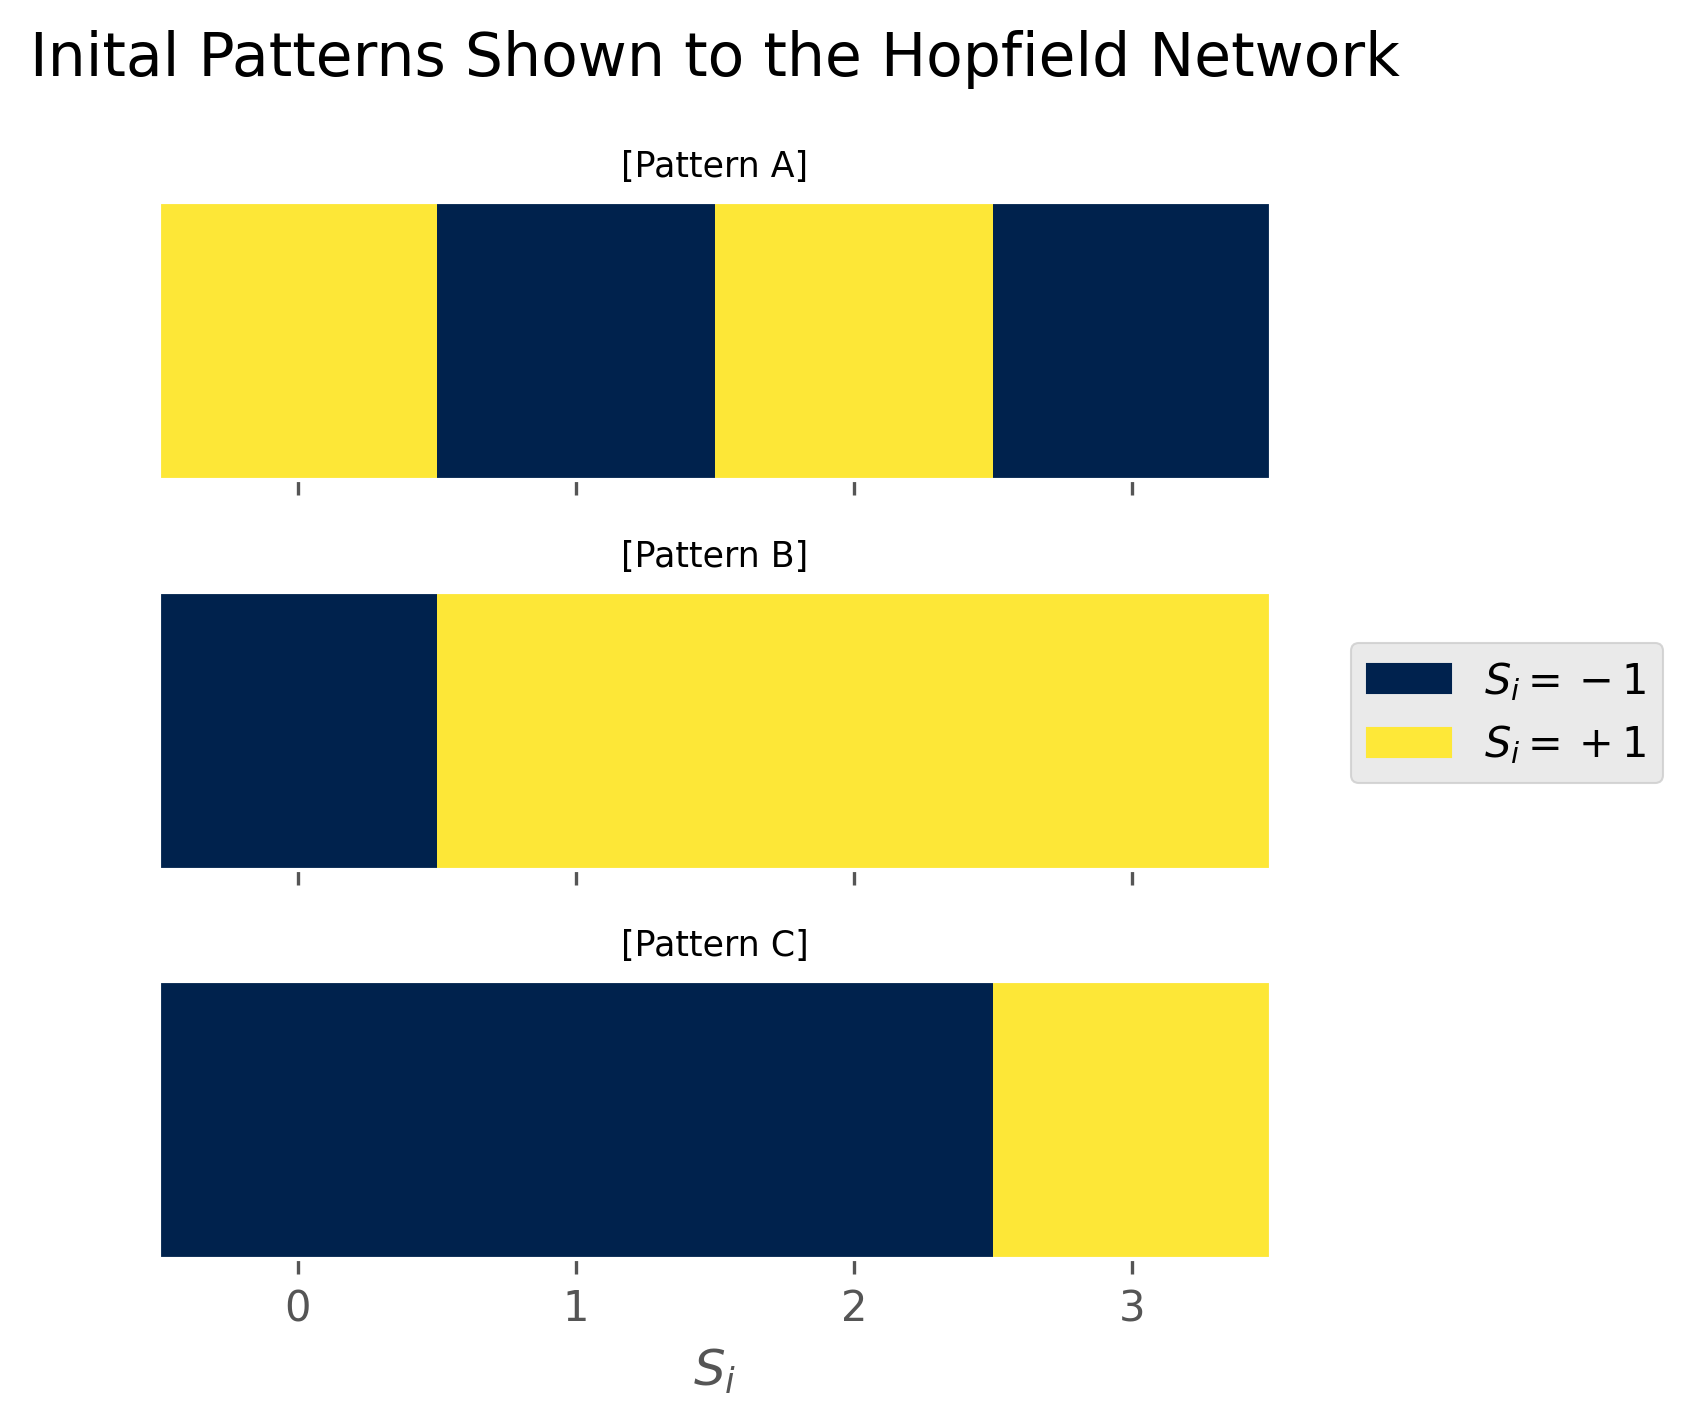

In [26]:
figure, axes = multi_plot_states(patterns)
for idx, ax in enumerate(axes.flatten()):
    ax.set_title(f"[Pattern {string.ascii_uppercase[idx]}]", fontsize="small")

figure.suptitle("Inital Patterns Shown to the Hopfield Network", fontsize="x-large")
figure.tight_layout()

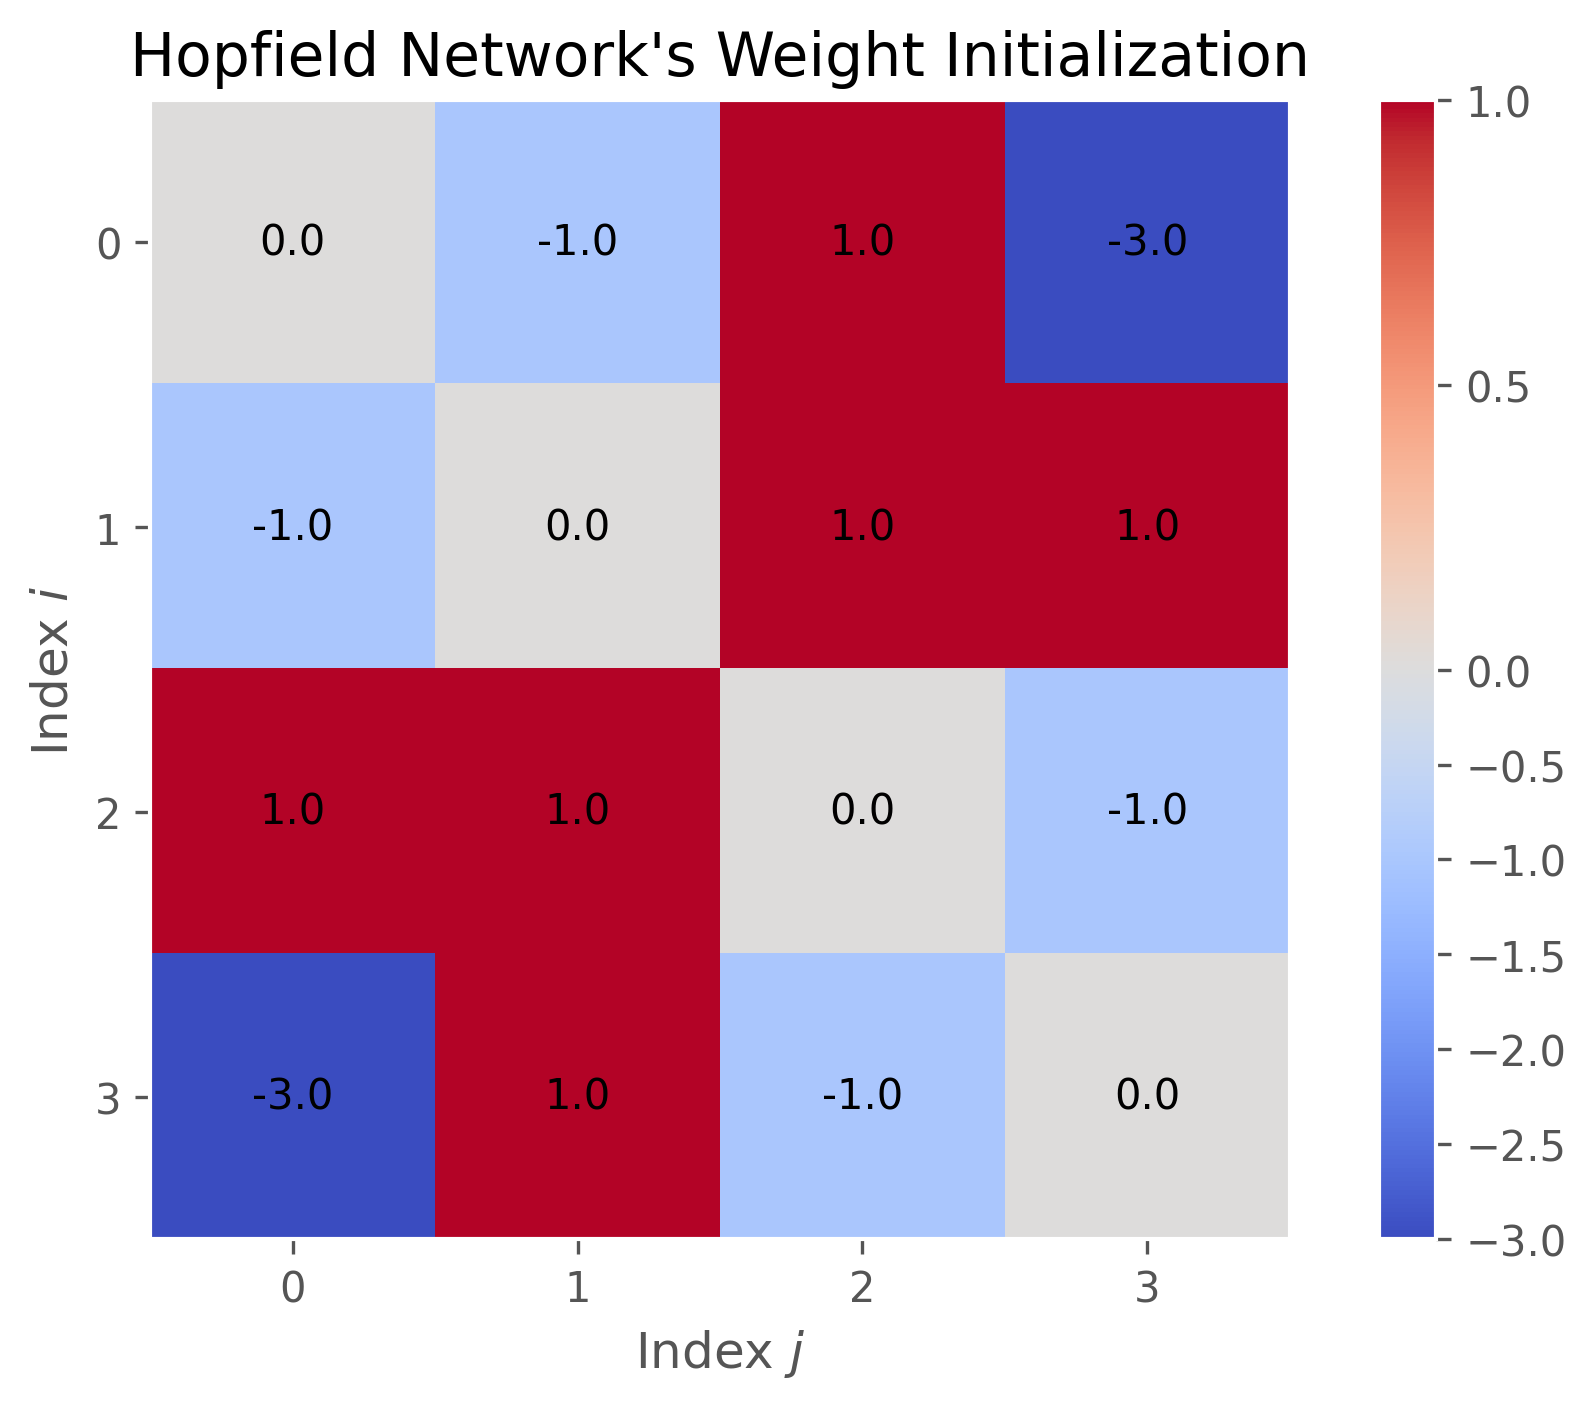

In [27]:
figure, ax = plt.subplots()
plot_weights(figure, ax, hopfield_network.w)
ax.set_title("Hopfield Network's Weight Initialization")
figure.tight_layout()

In [28]:
for idx, pattern in enumerate(patterns):
    if hopfield_network.is_stable(pattern):
        print(f"Pattern {string.ascii_uppercase[idx]} is stable.")
    else:
        print(f"Pattern {string.ascii_uppercase[idx]} is not stable.")

Pattern A is not stable.
Pattern B is not stable.
Pattern C is not stable.


## Task 2

---

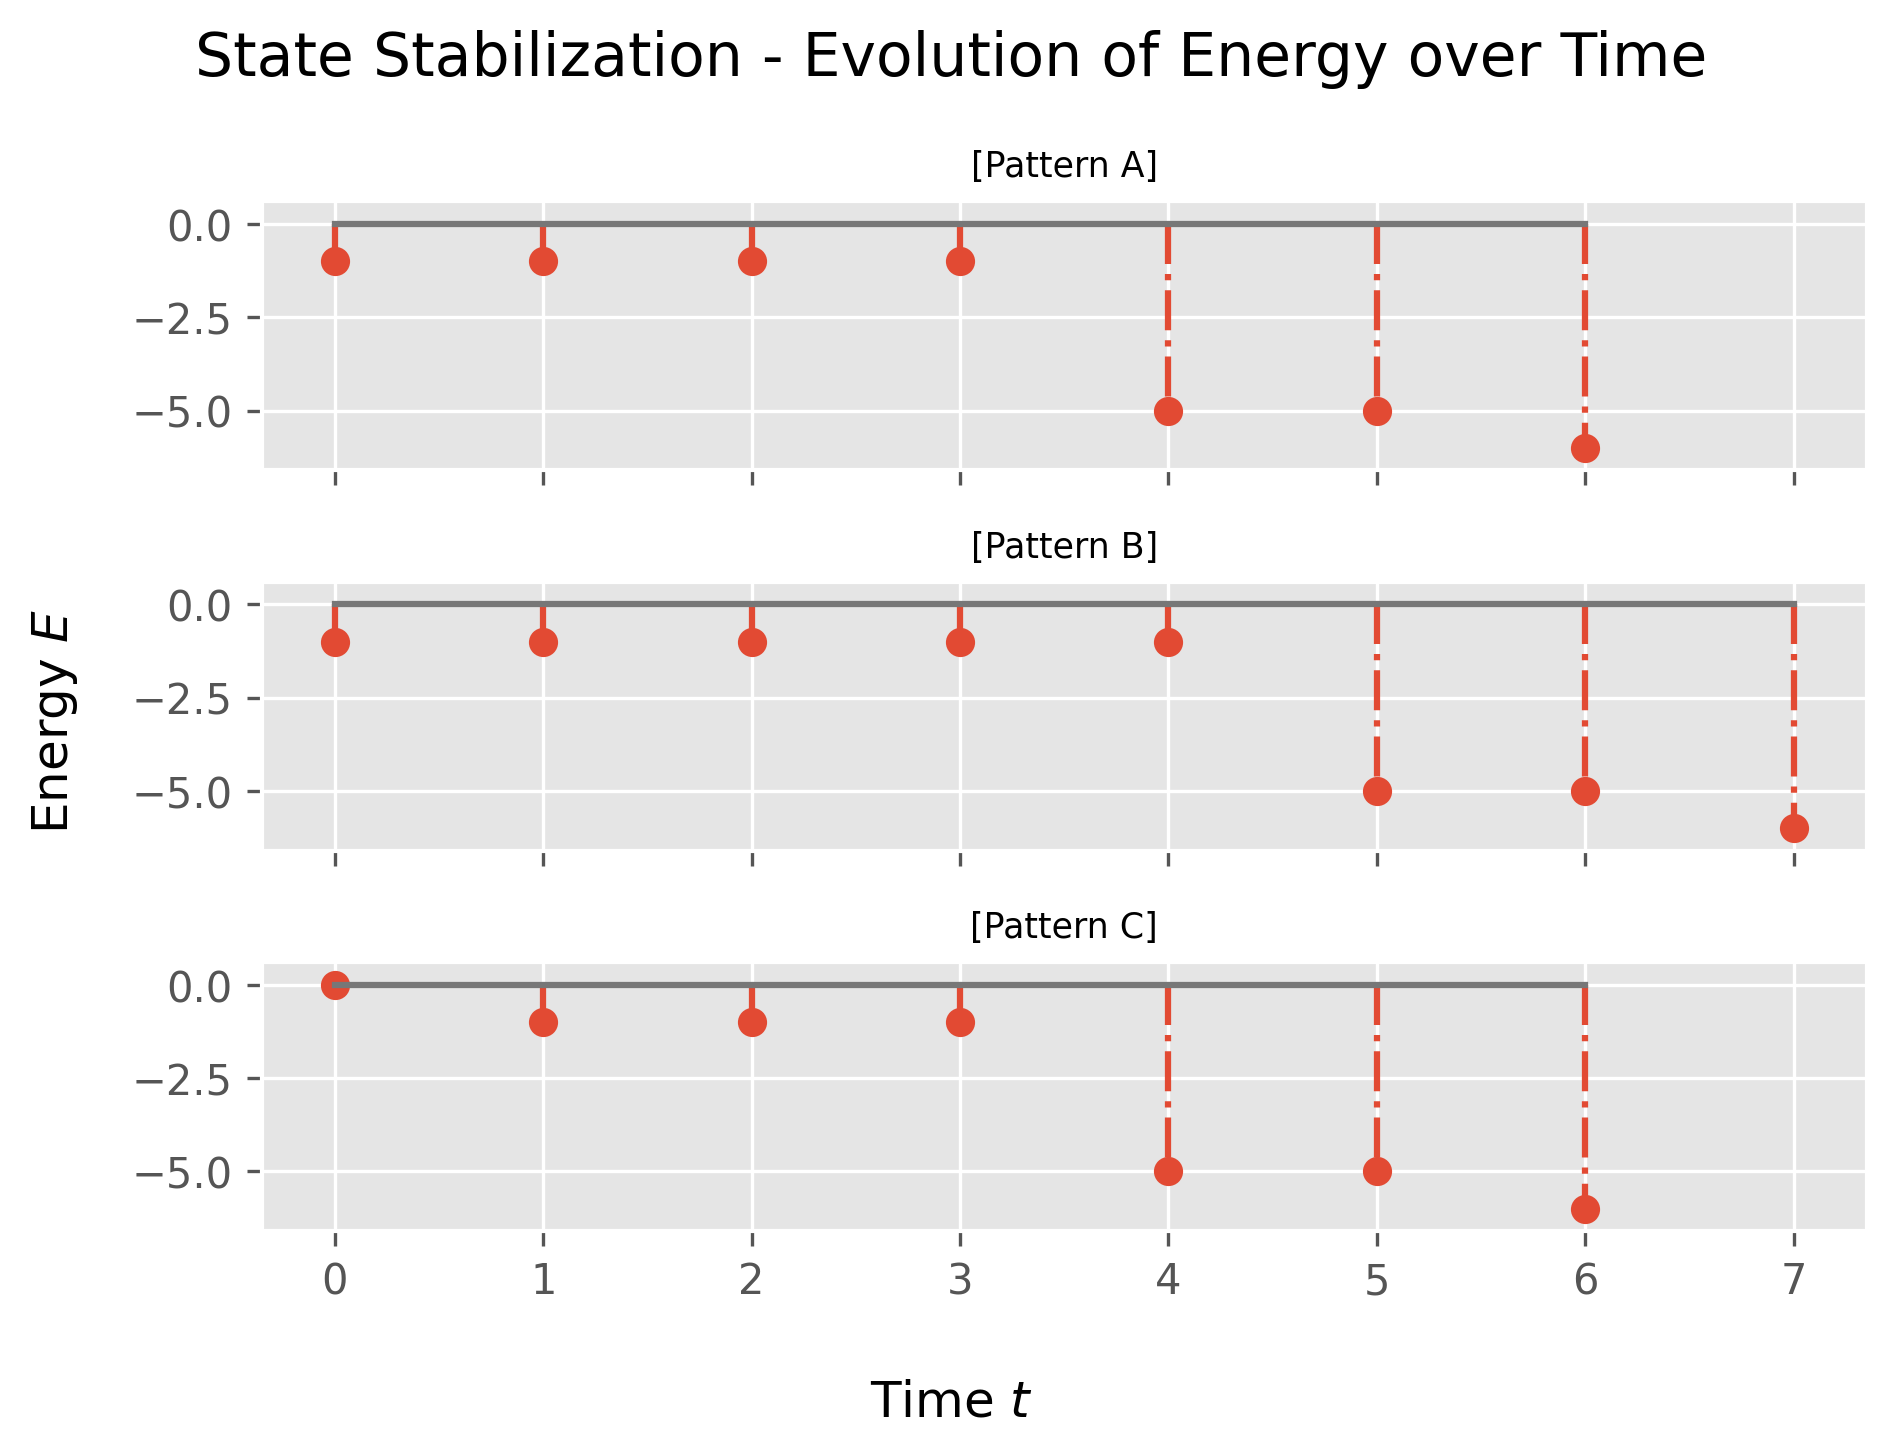

In [29]:
stabelize_results: list[tuple[NDArray[np.int8], NDArray[np.float64]]] = [
    hopfield_network.stabilize(pattern, synchron=False) for pattern in patterns
]
stabelized_states, energy_evolutions = zip(*stabelize_results)

figure, axes = multi_plot_energy_evolution(energy_evolutions, style="stem")
for idx, ax in enumerate(axes.flatten()):
    ax.set_title(f"[Pattern {string.ascii_uppercase[idx]}]", fontsize="small")

figure.suptitle(
    "State Stabilization - Evolution of Energy over Time", fontsize="x-large"
)
figure.tight_layout()

## Task 3

---

In [30]:
images: NDArray[np.int8] = np.load("images.npz")["arr_0"].astype(
    np.int8
)  # Shape: [#patterns, height, width]

image_shape: tuple[int, int] = images.shape[1:]
flattened_images: NDArray[np.int8] = images.reshape(
    -1, images.shape[1] * images.shape[2]
)

hopfield_network = HopfieldNetwork(flattened_images)

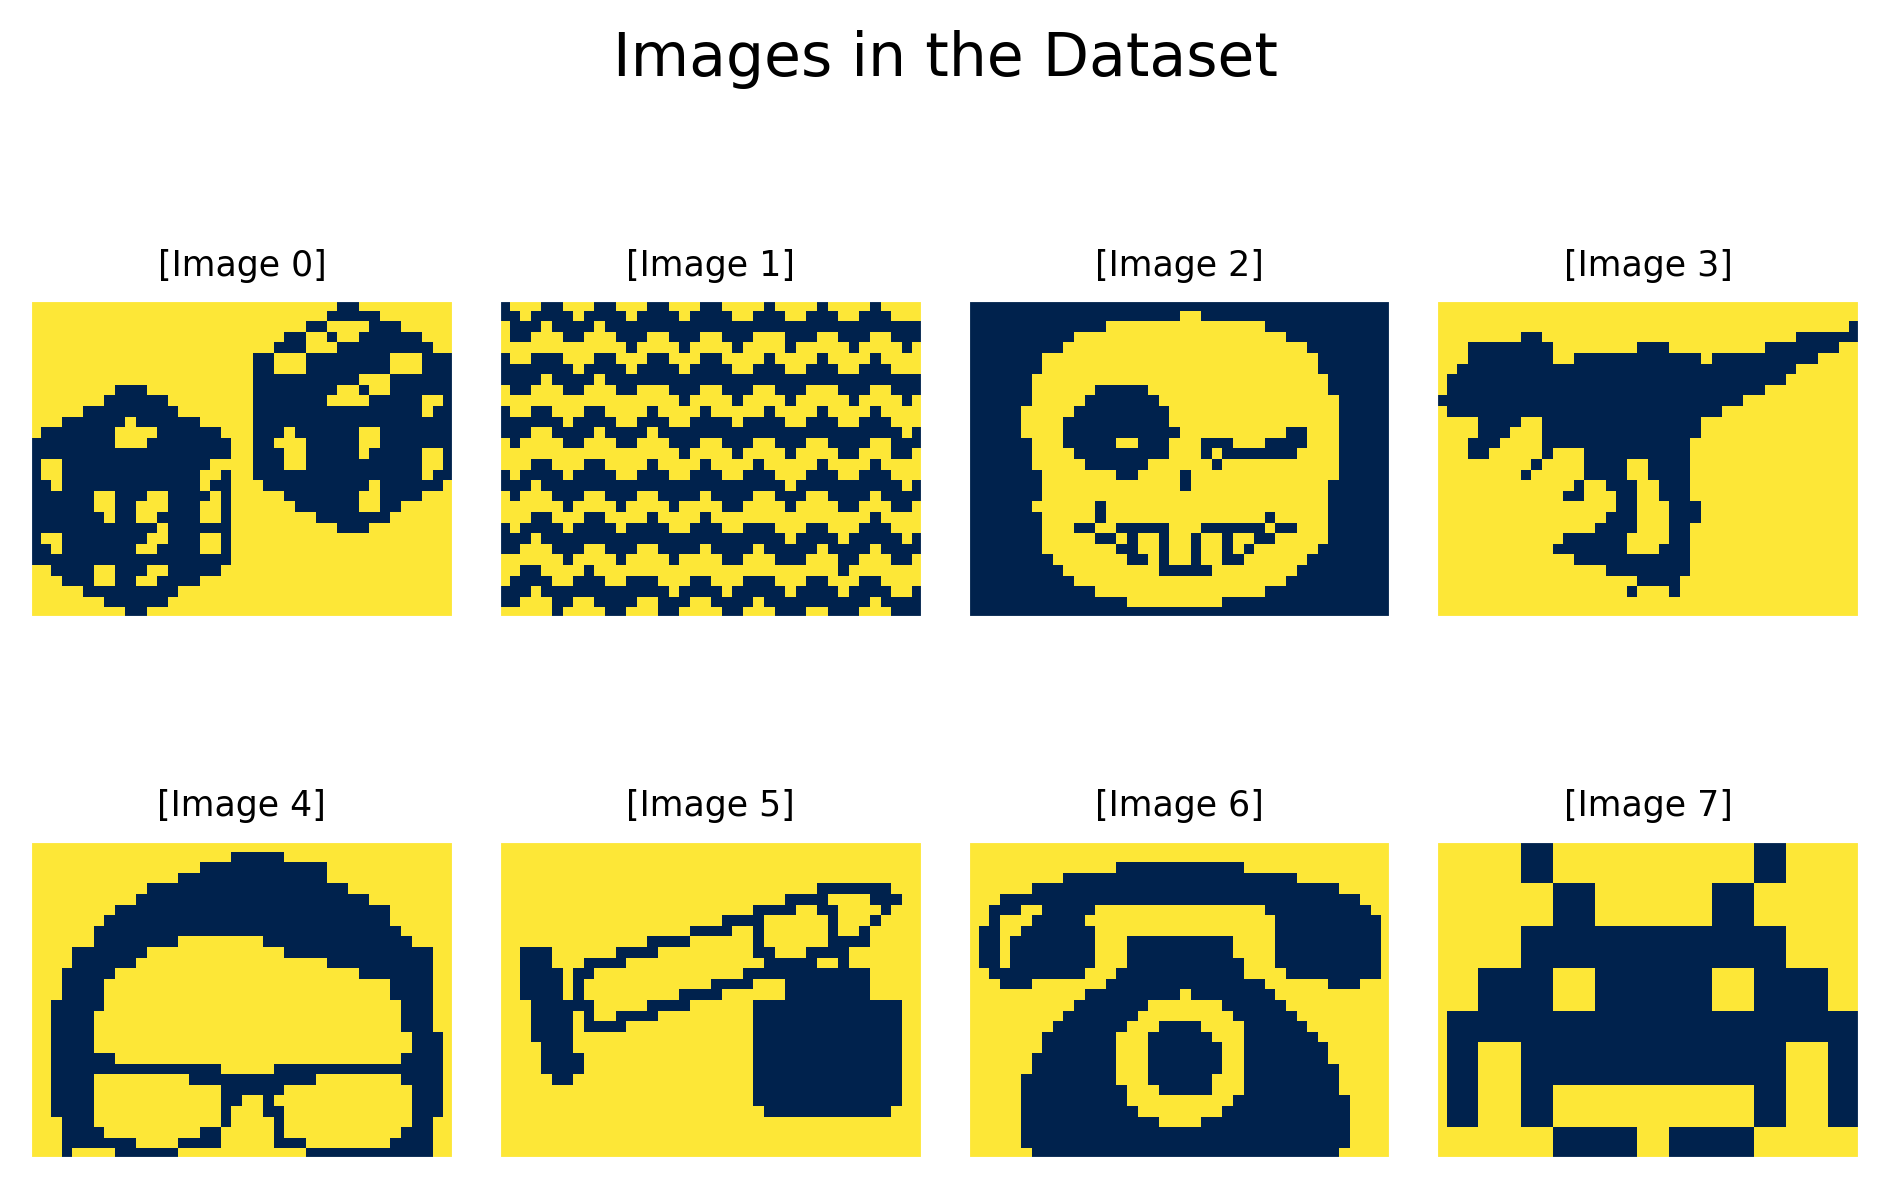

In [31]:
figure, axes = plt.subplots(2, 4)
for idx, (ax, image) in enumerate(zip(axes.flatten(), images, strict=True)):
    ax.imshow(image, cmap="cividis")

    ax.set_title(f"[Image {idx}]", fontsize="small")

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

figure.suptitle("Images in the Dataset", fontsize="x-large", y=0.95)
figure.tight_layout()

### Stabilization of Original Images

In [32]:
for idx, pattern in enumerate(flattened_images):
    if hopfield_network.is_stable(pattern):
        print(f"Image {idx} is stable.")
    else:
        print(f"Image {idx} is not stable.")

Image 0 is stable.
Image 1 is stable.
Image 2 is not stable.
Image 3 is stable.
Image 4 is stable.
Image 5 is stable.
Image 6 is stable.
Image 7 is stable.


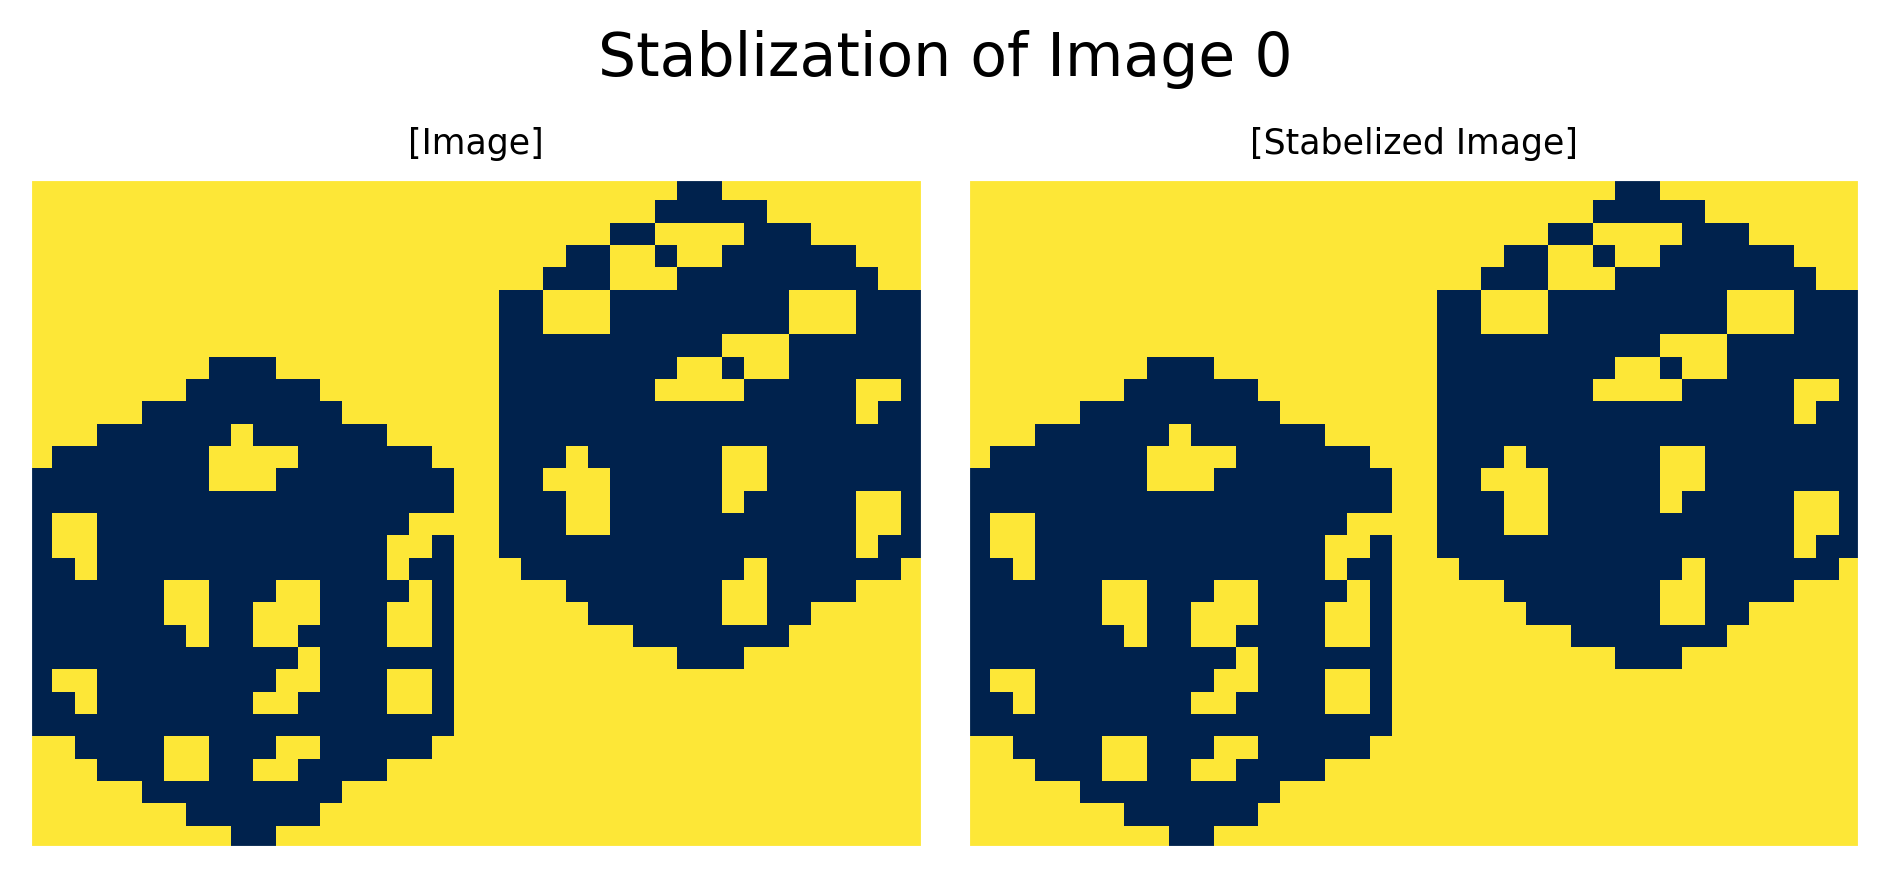

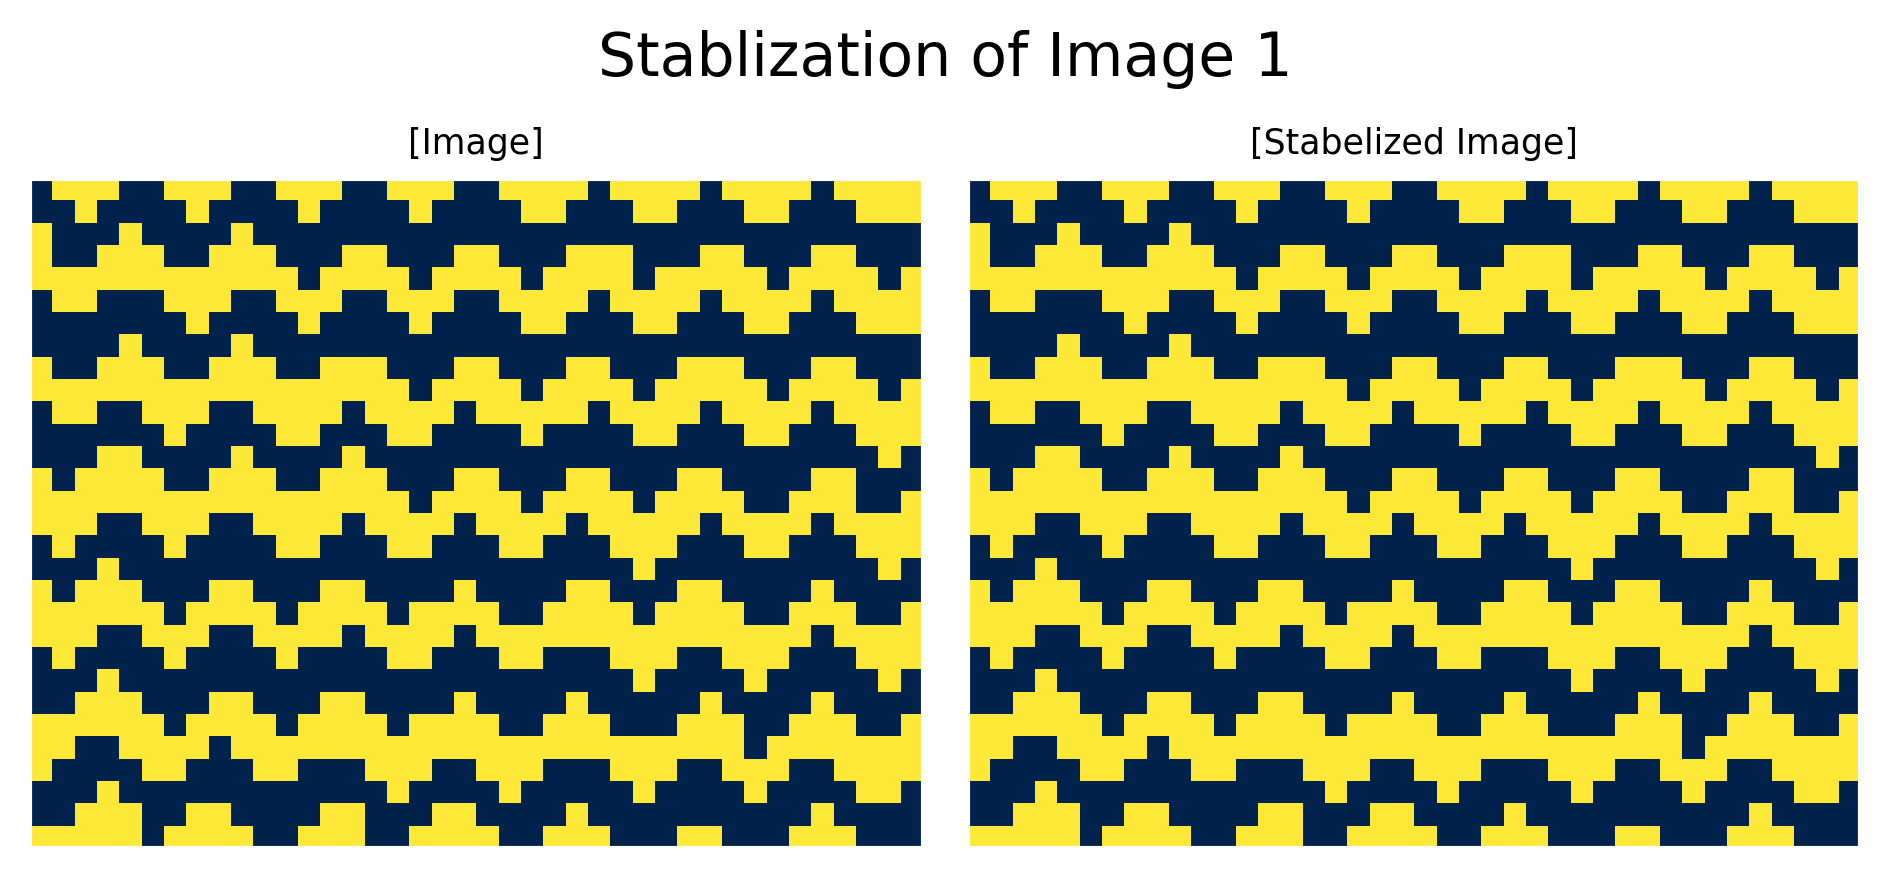

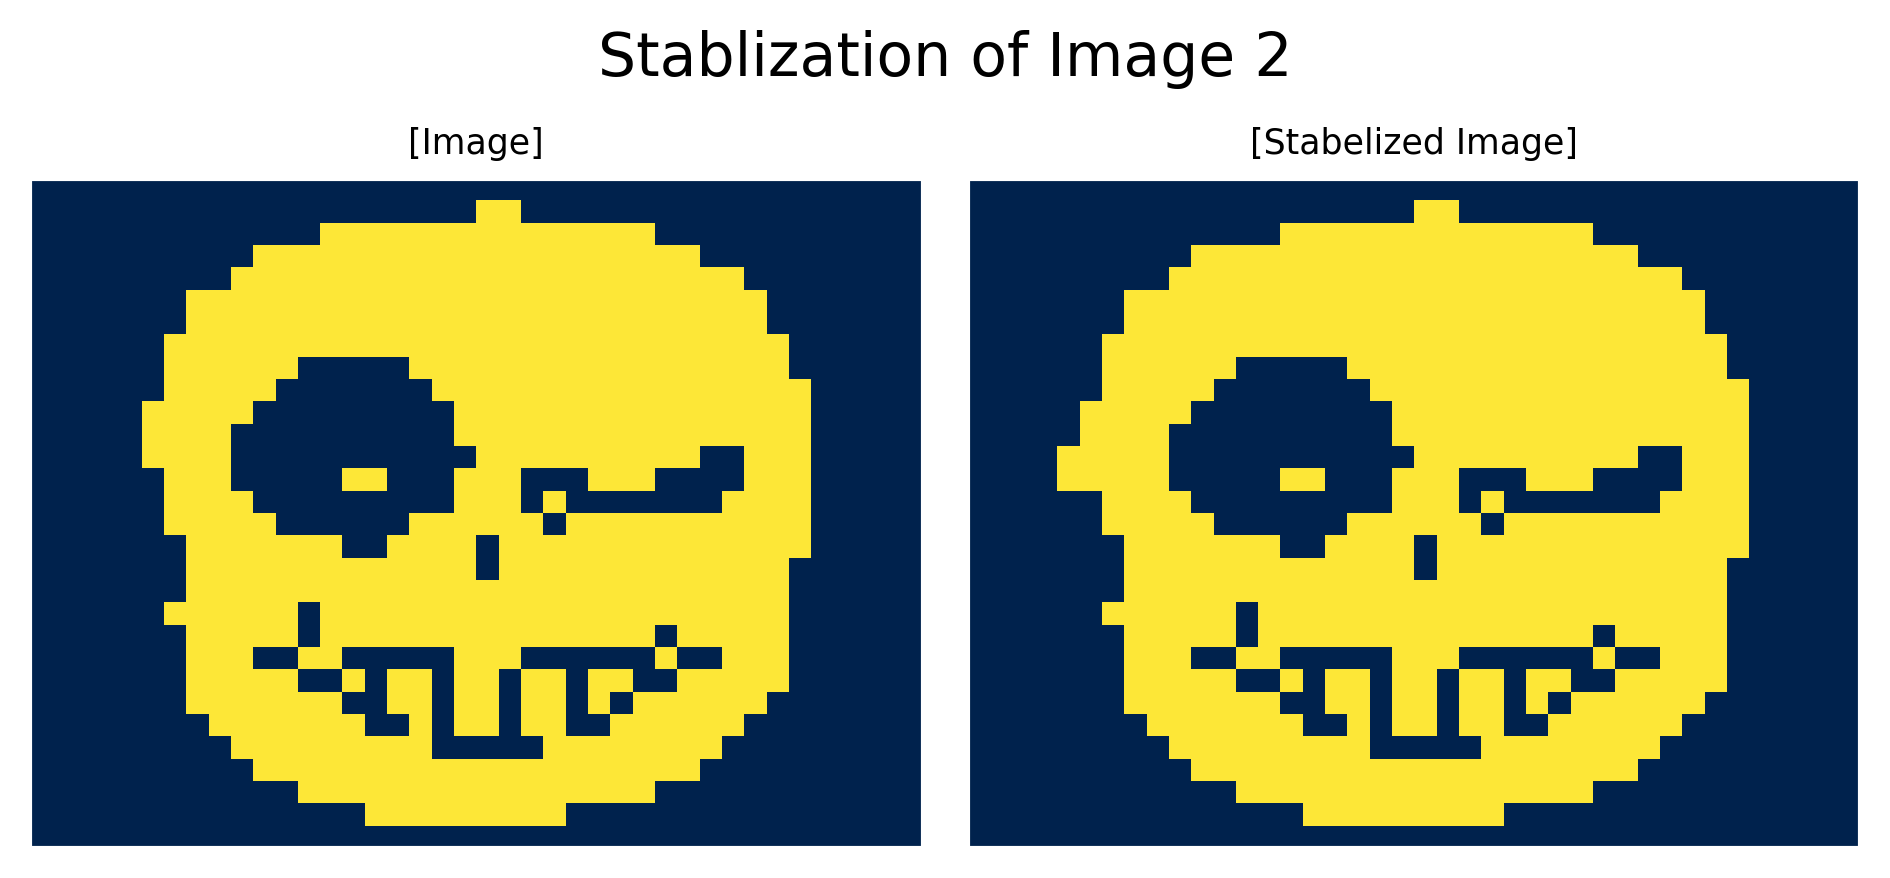

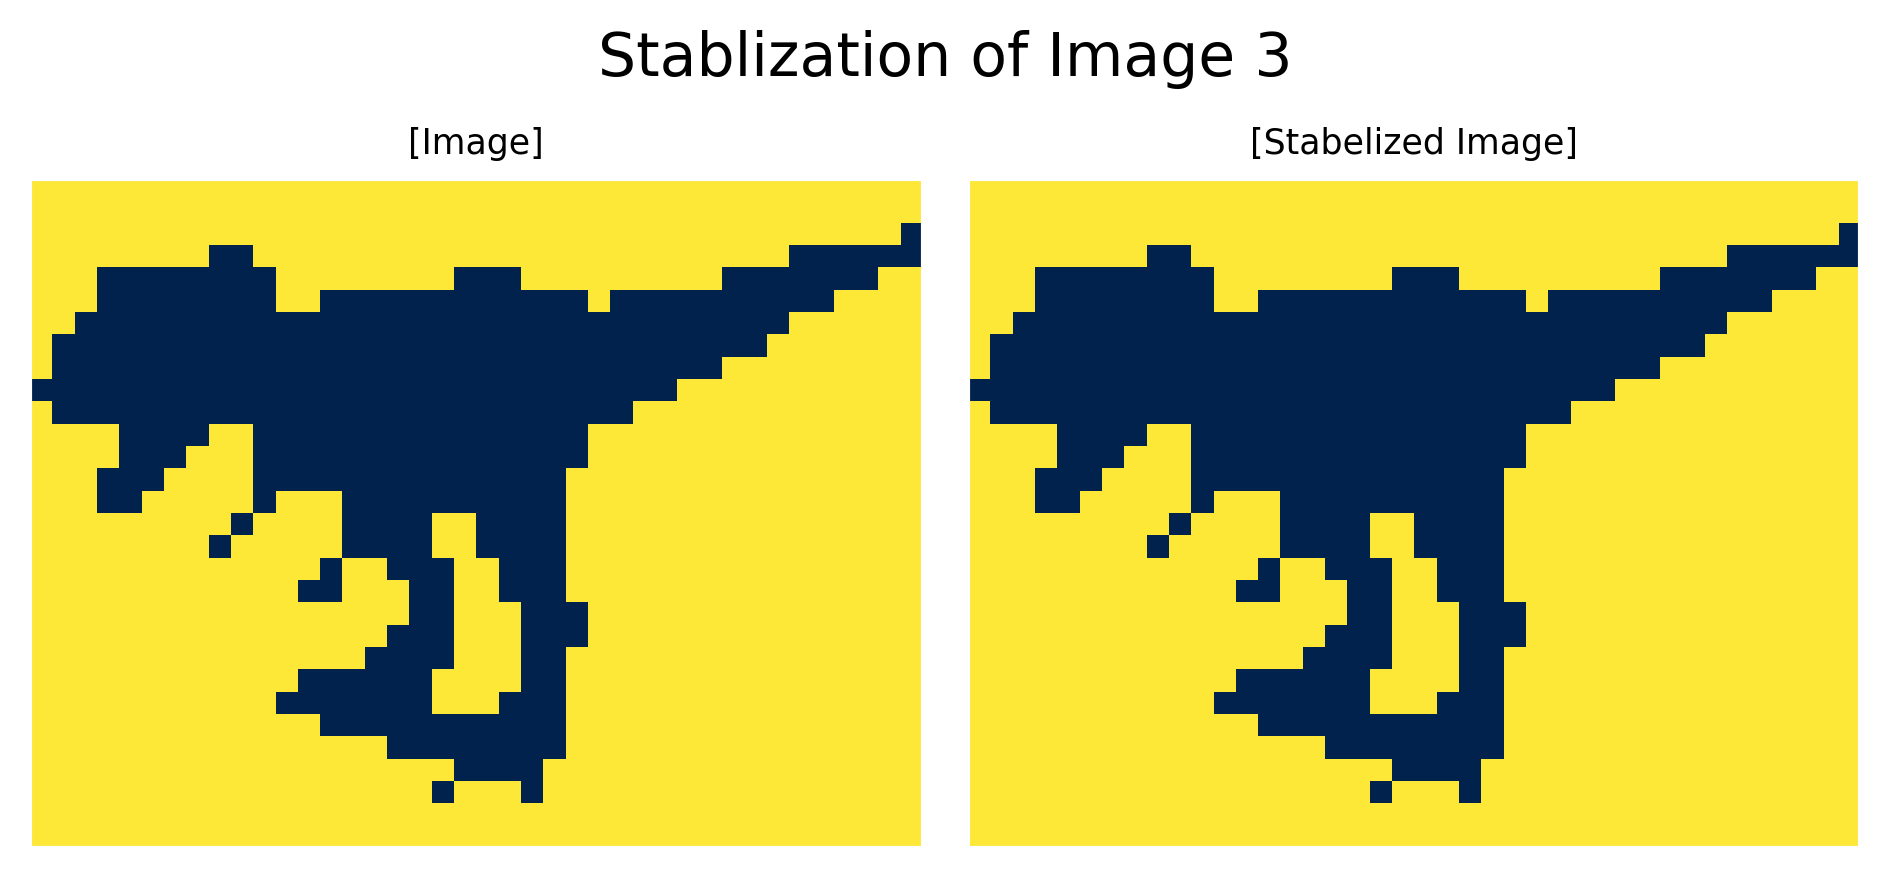

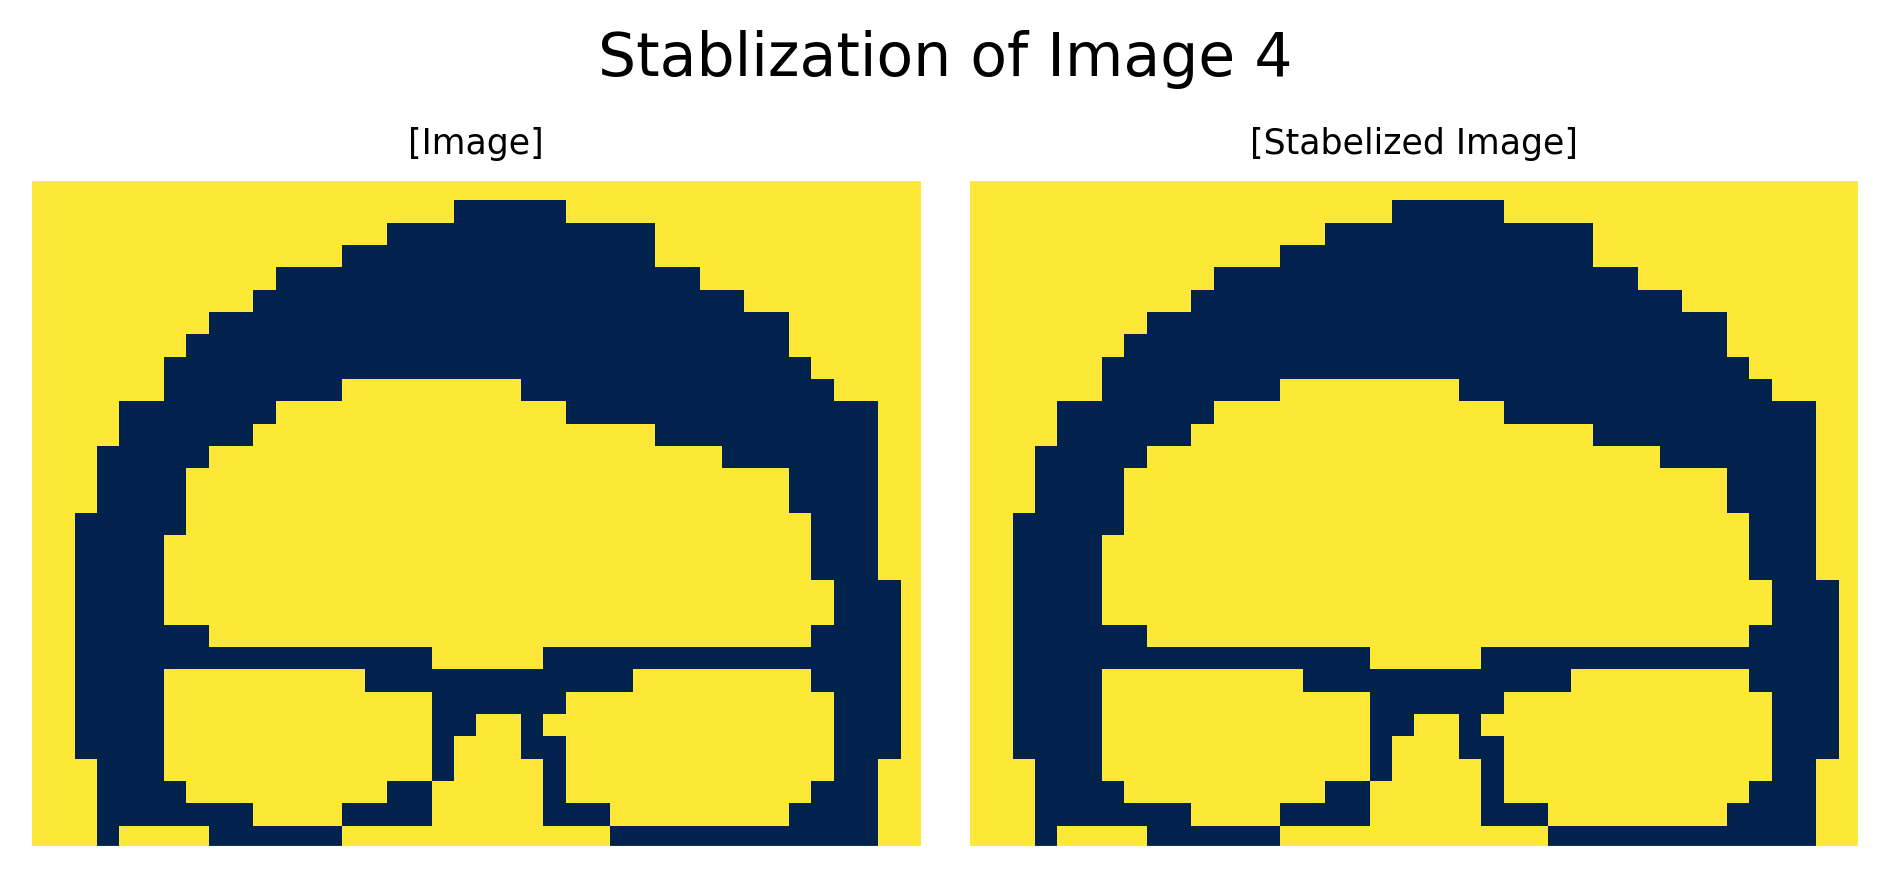

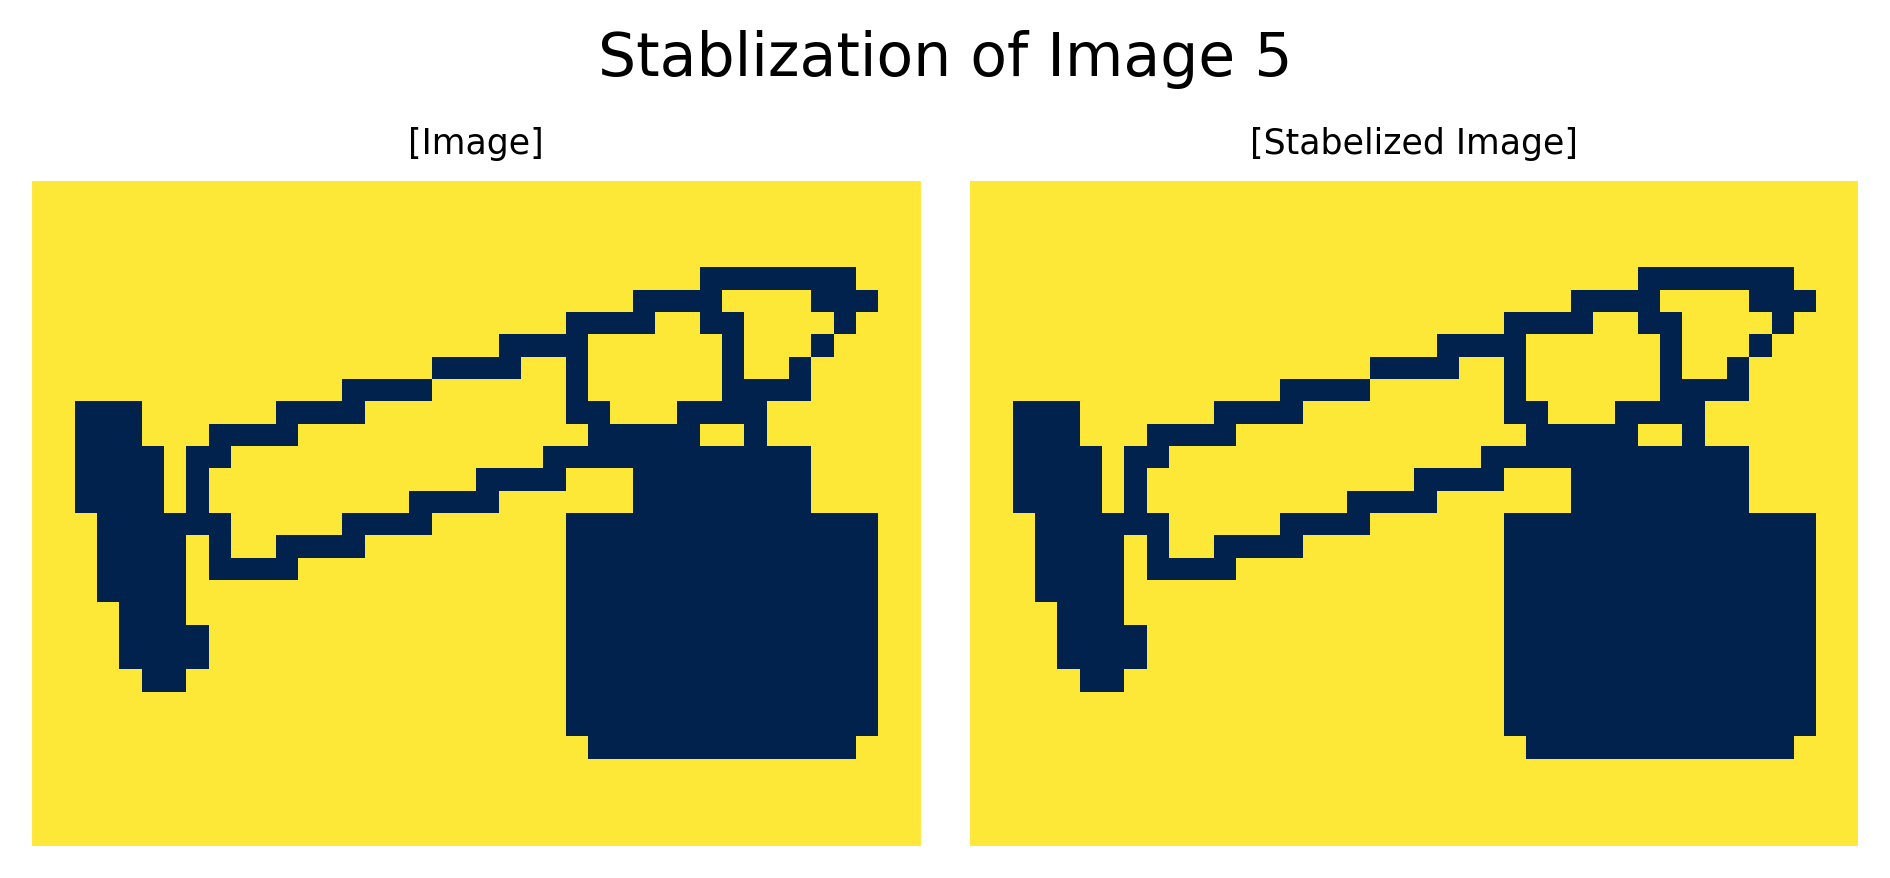

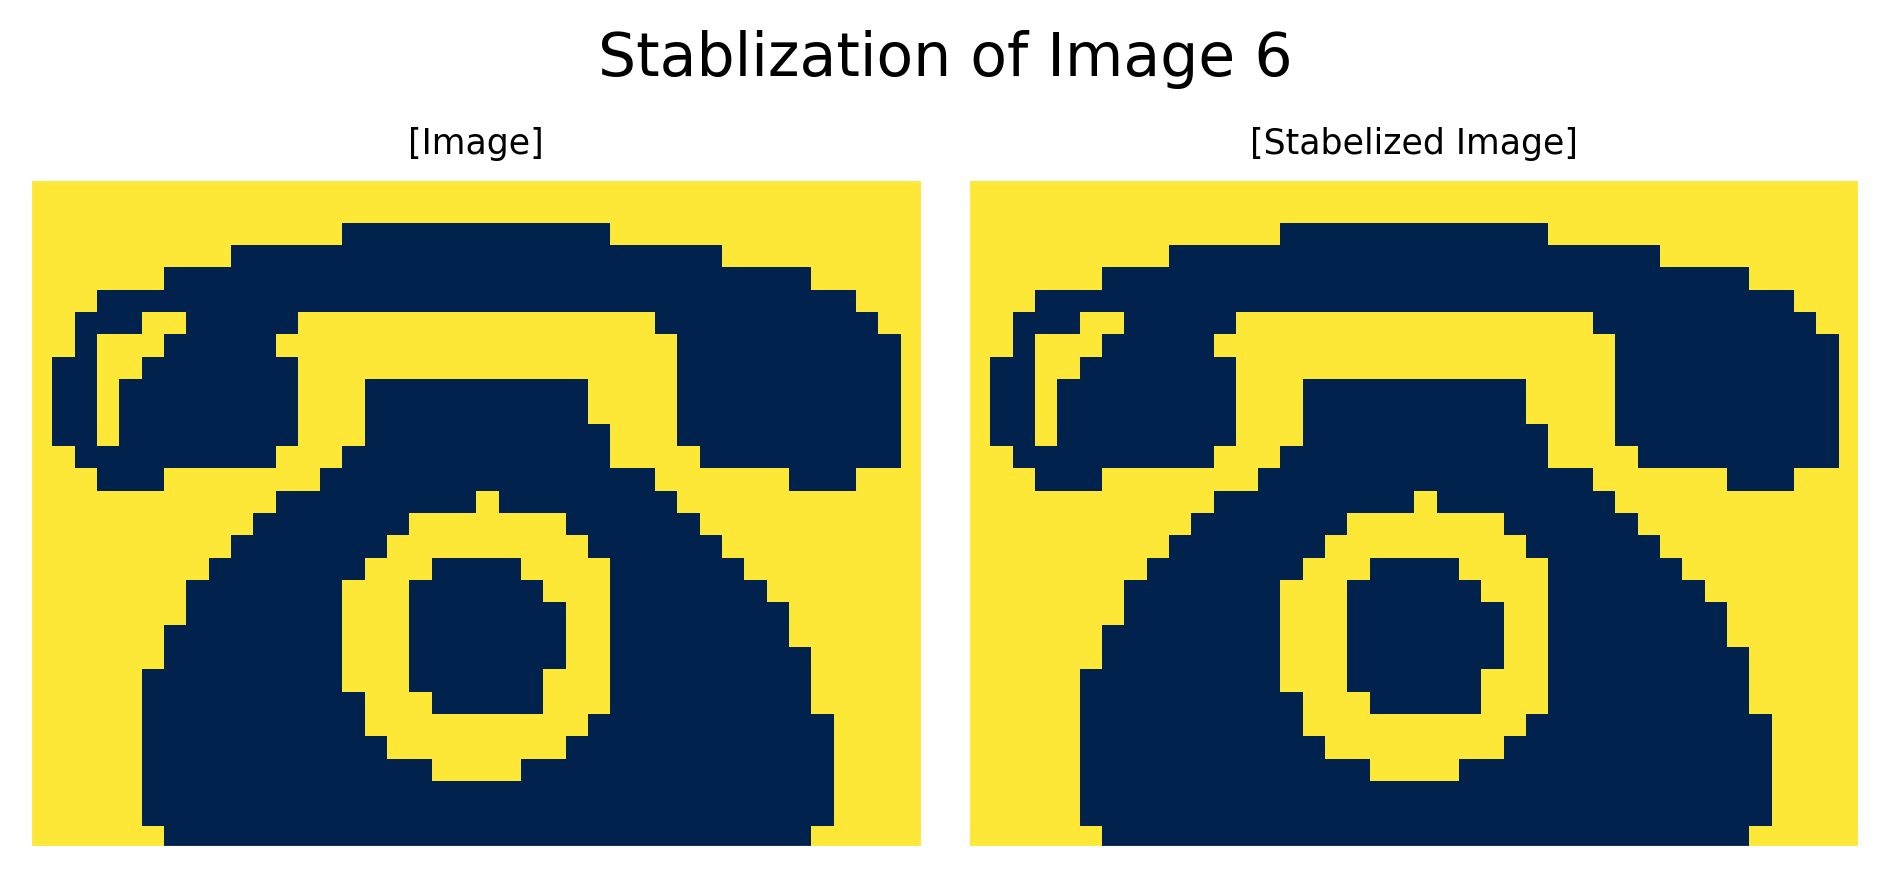

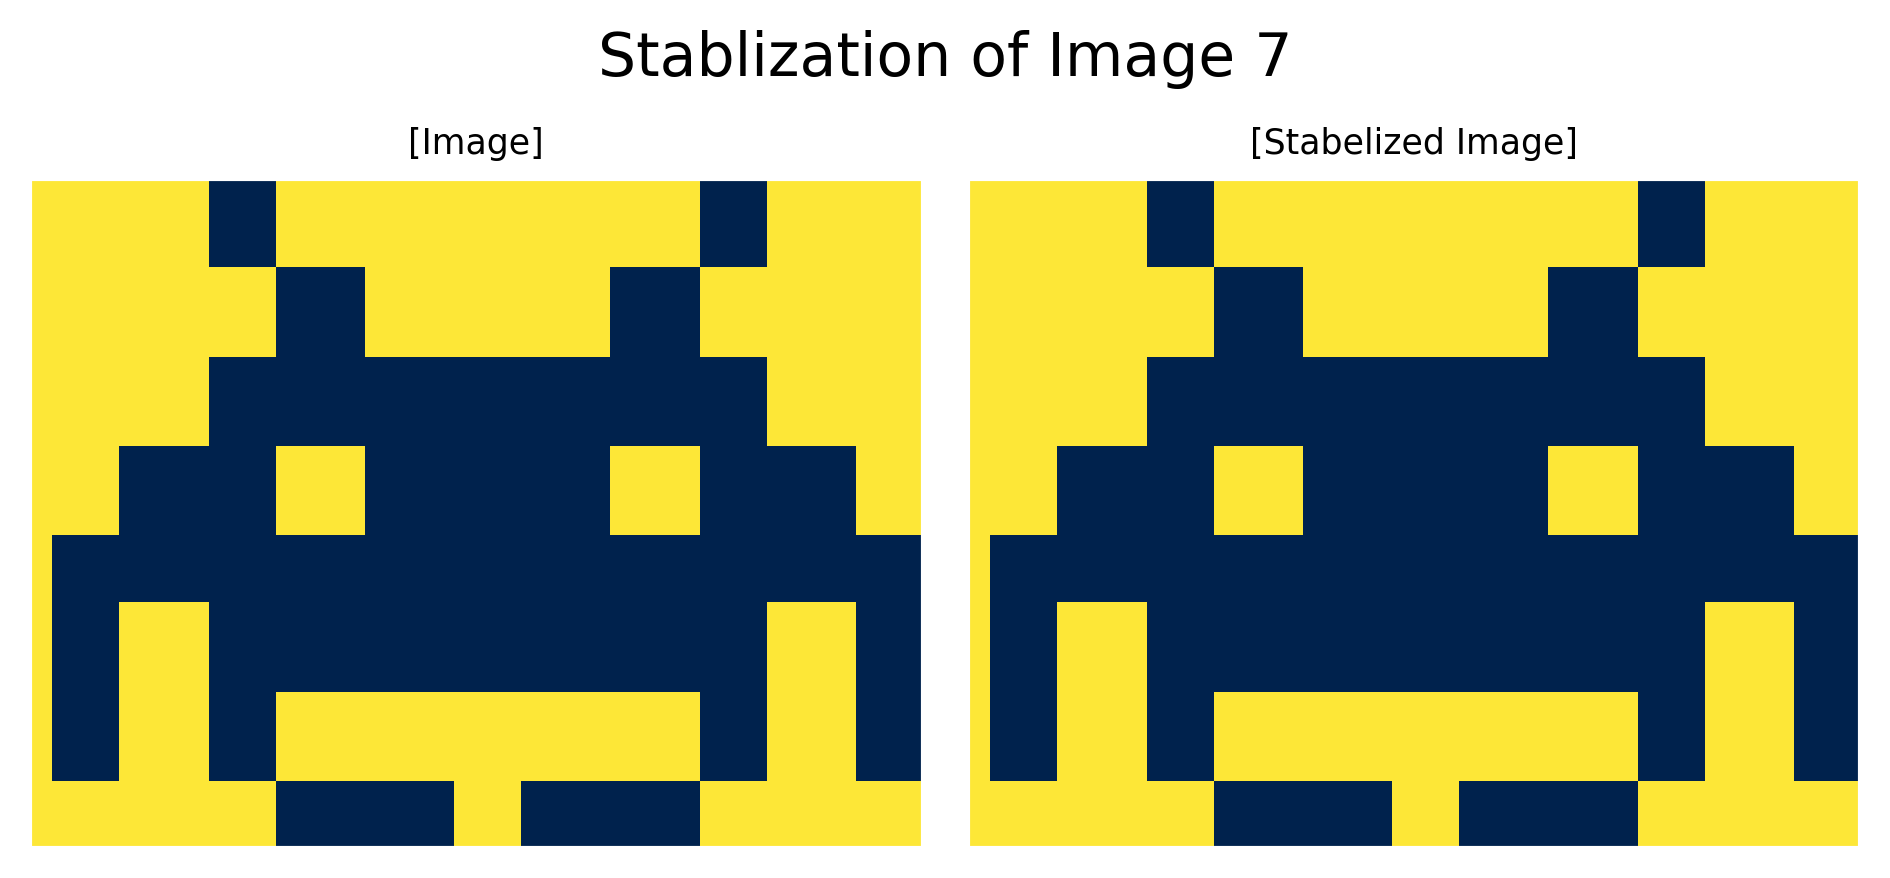

In [33]:
for idx, pattern in enumerate(flattened_images):
    stabelized_state, _ = hopfield_network.stabilize(pattern, synchron=False)
    figure, axes = multi_plot_states(
        np.stack([pattern.reshape(image_shape), stabelized_state.reshape(image_shape)]),
        orientation="horizontal",
        show_axis=False,
        show_legend=False,
    )

    axes[0, 0].set_title("[Image]", fontsize="small")
    axes[0, 1].set_title("[Stabelized Image]", fontsize="small")

    figure.suptitle(f"Stablization of Image {idx}", fontsize="x-large", y=0.8)
    figure.tight_layout()

### Stabilization of Random Images

In [34]:
def generate_random_patterns(
    n: int = 10, rng: np.random.Generator = RNG
) -> NDArray[np.int8]:
    random_patterns: NDArray[np.int8] = rng.integers(
        0,
        1,
        size=(n, *flattened_images.shape[1:]),
        endpoint=True,
        dtype=np.int8,
    )
    random_patterns[random_patterns == 0] = -1
    return random_patterns

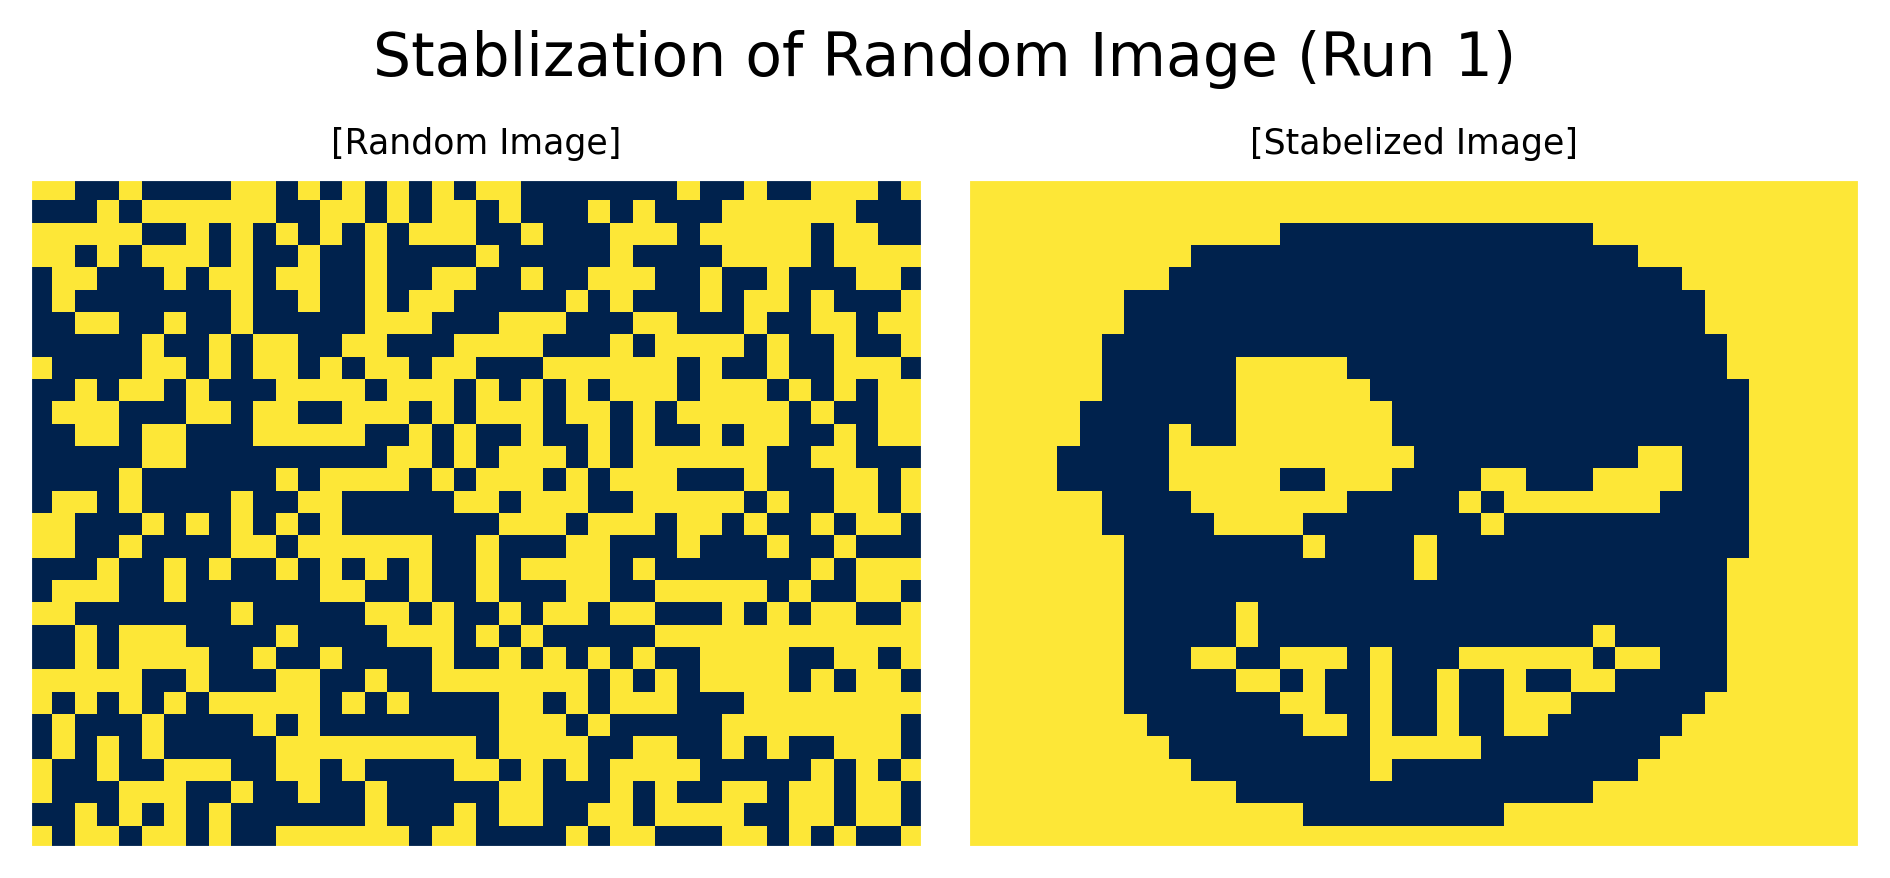

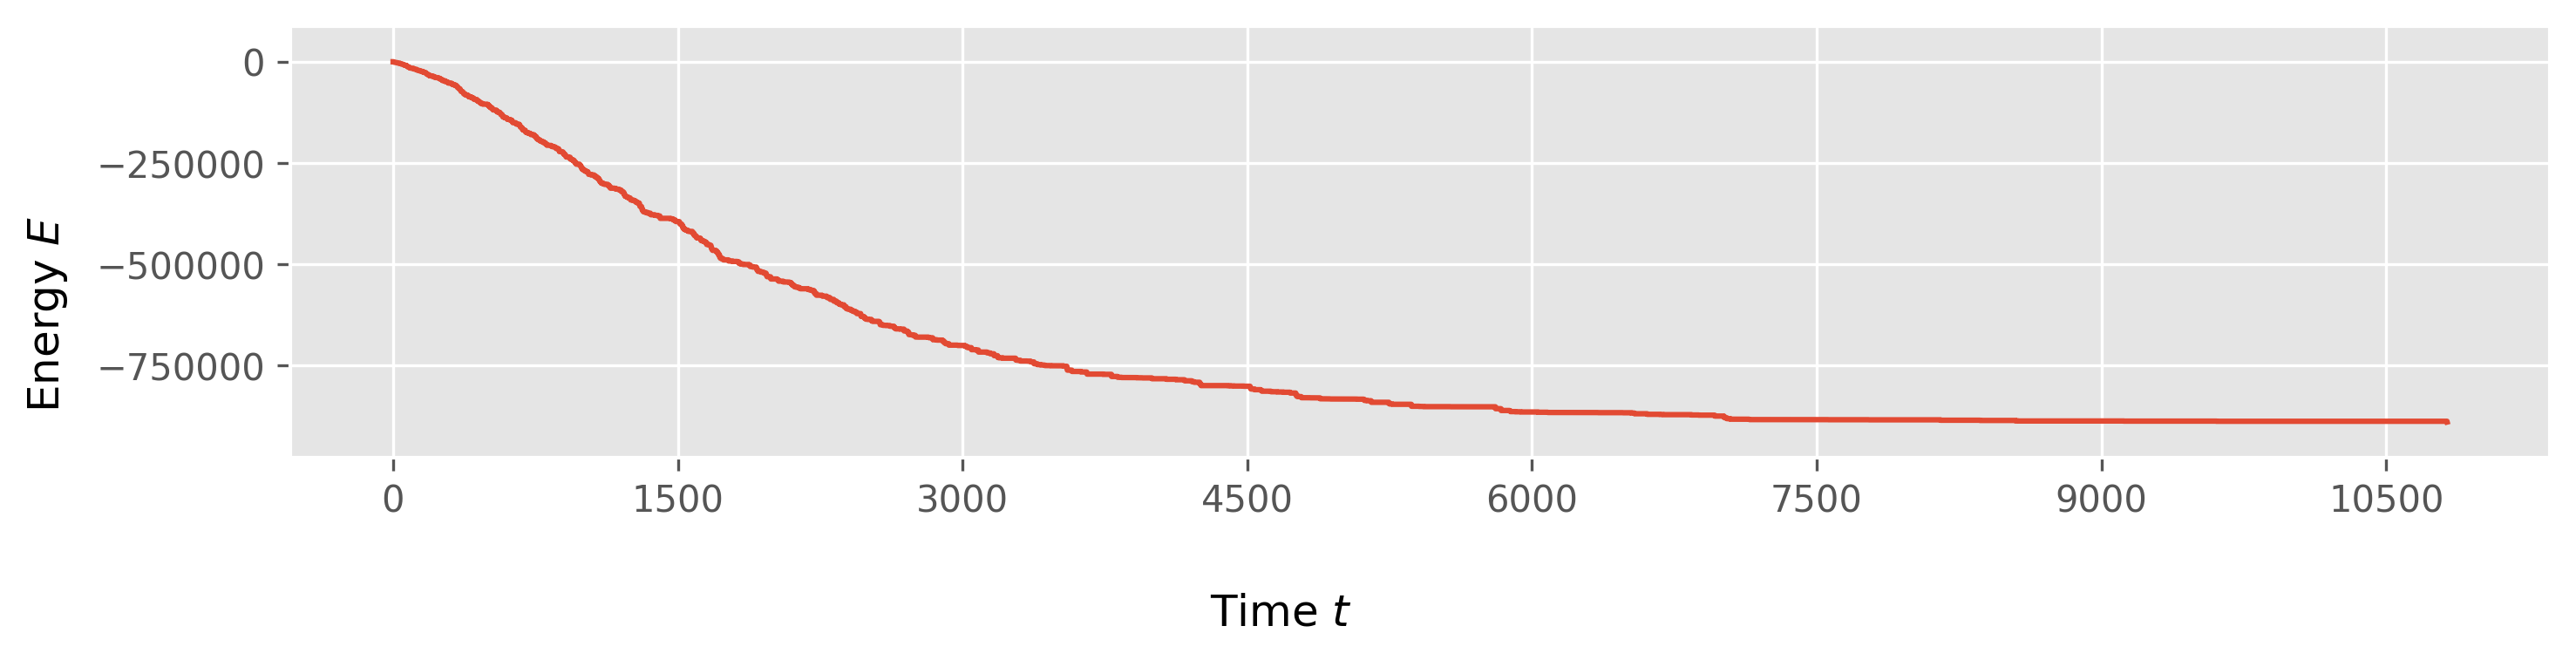

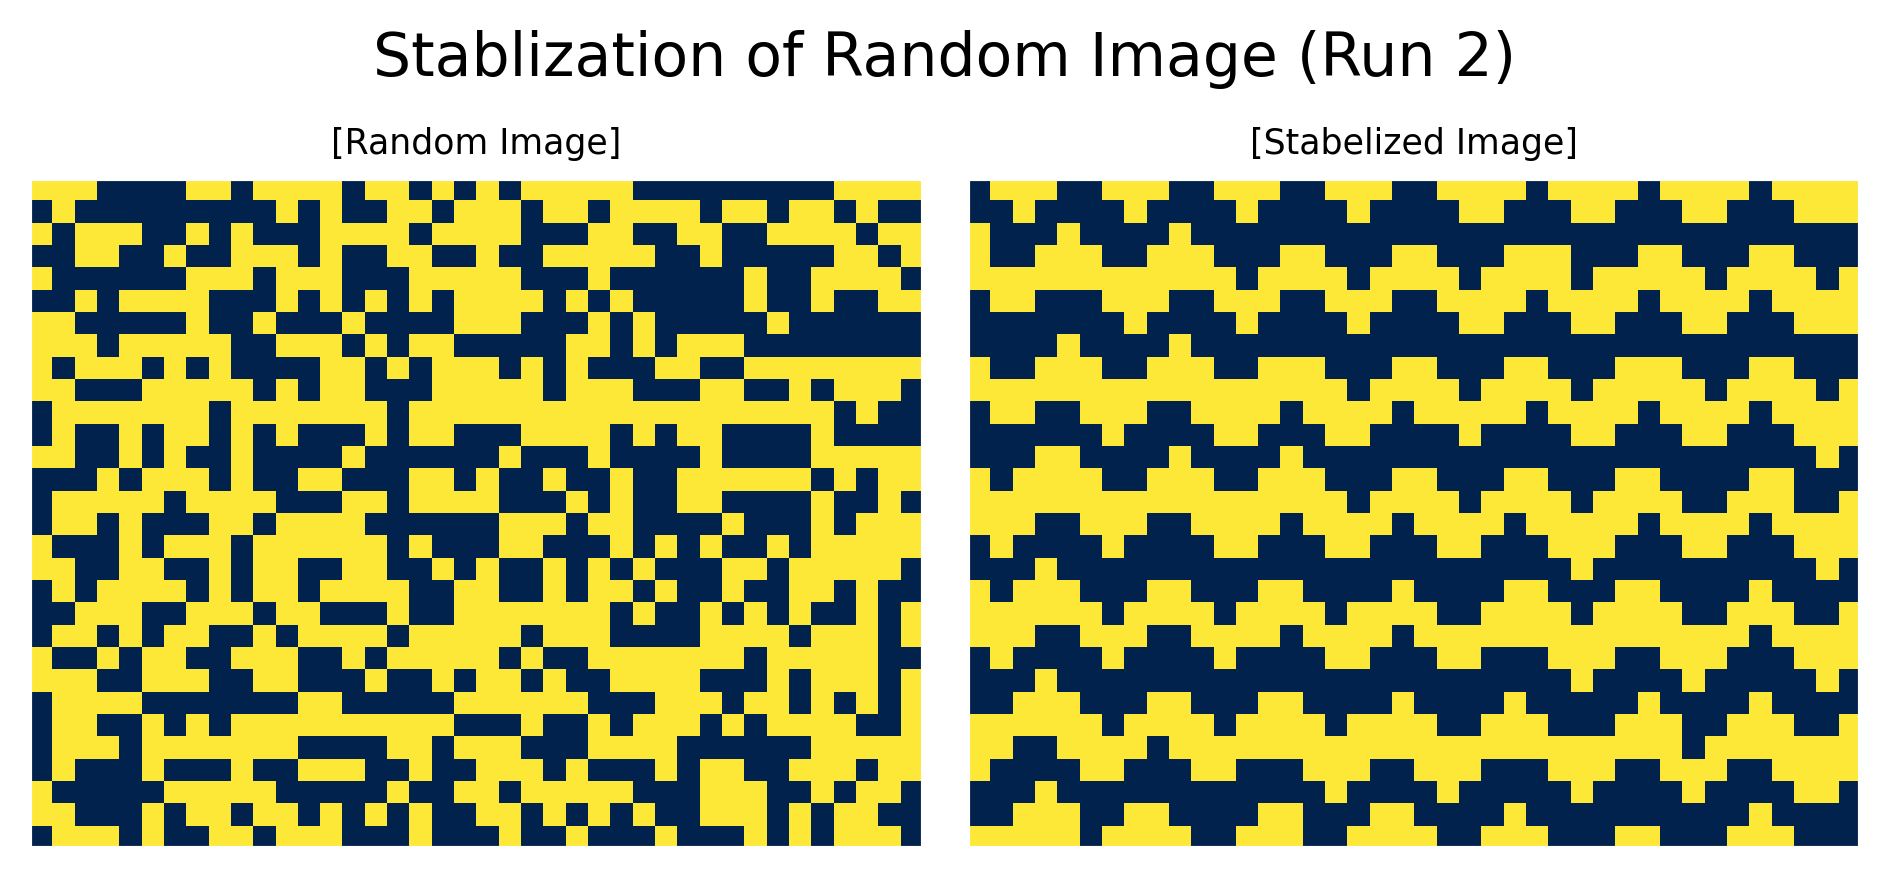

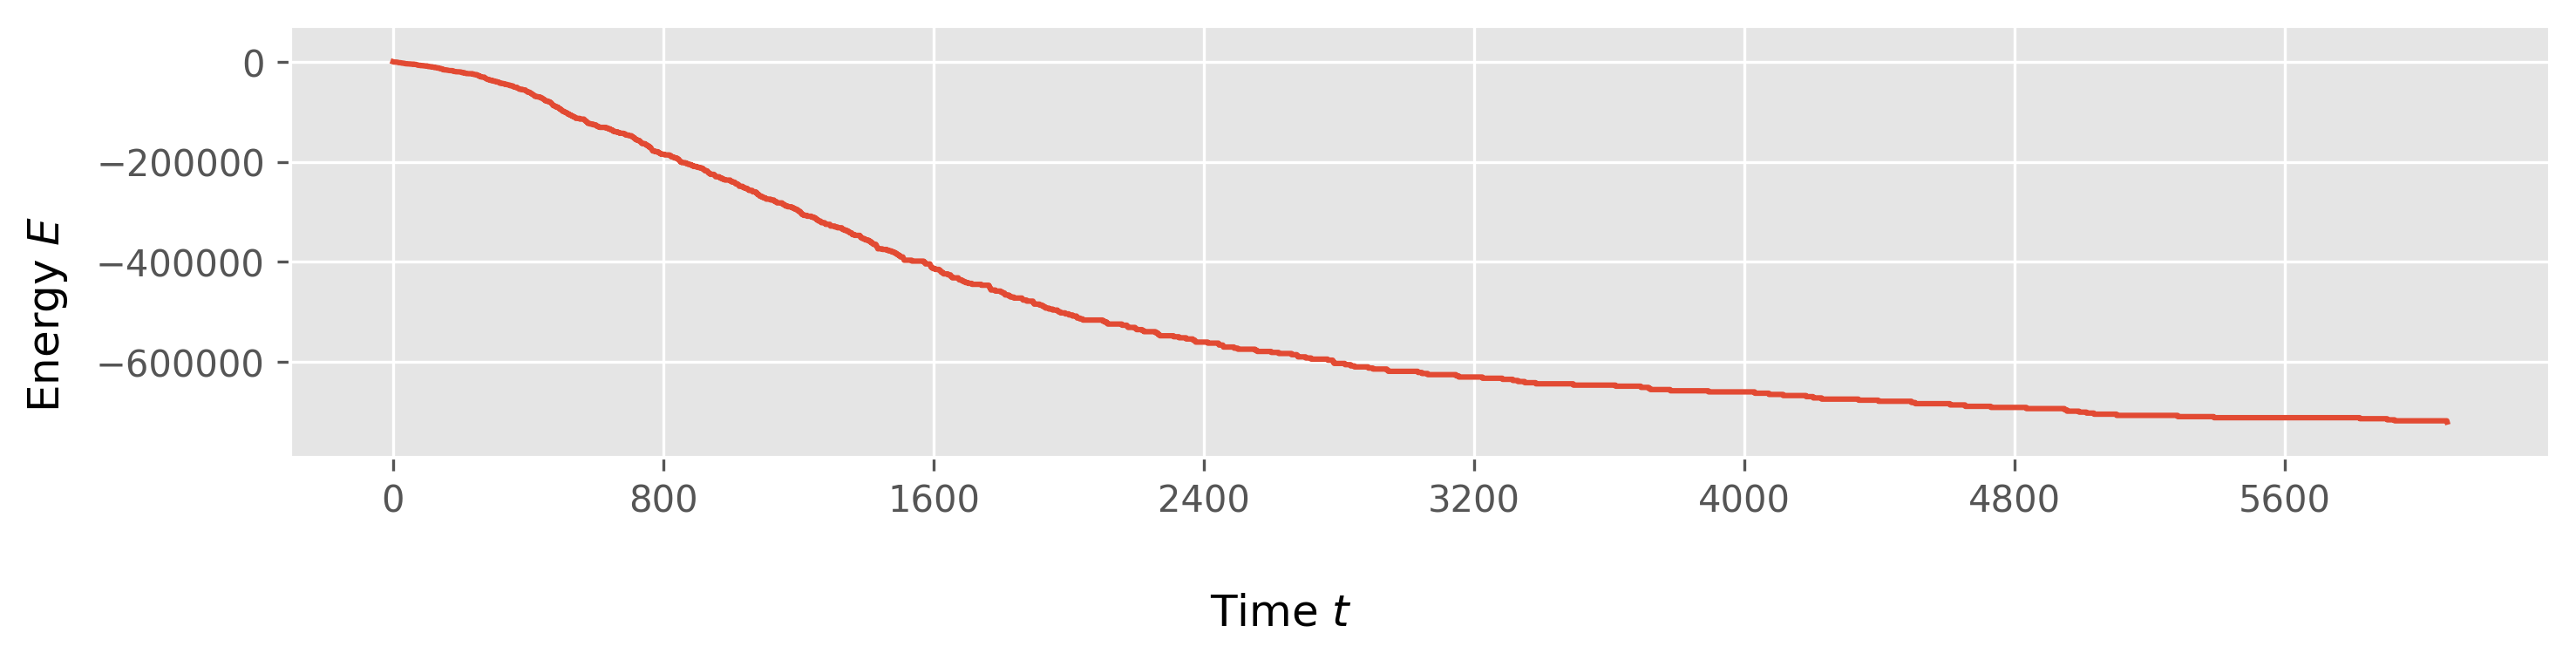

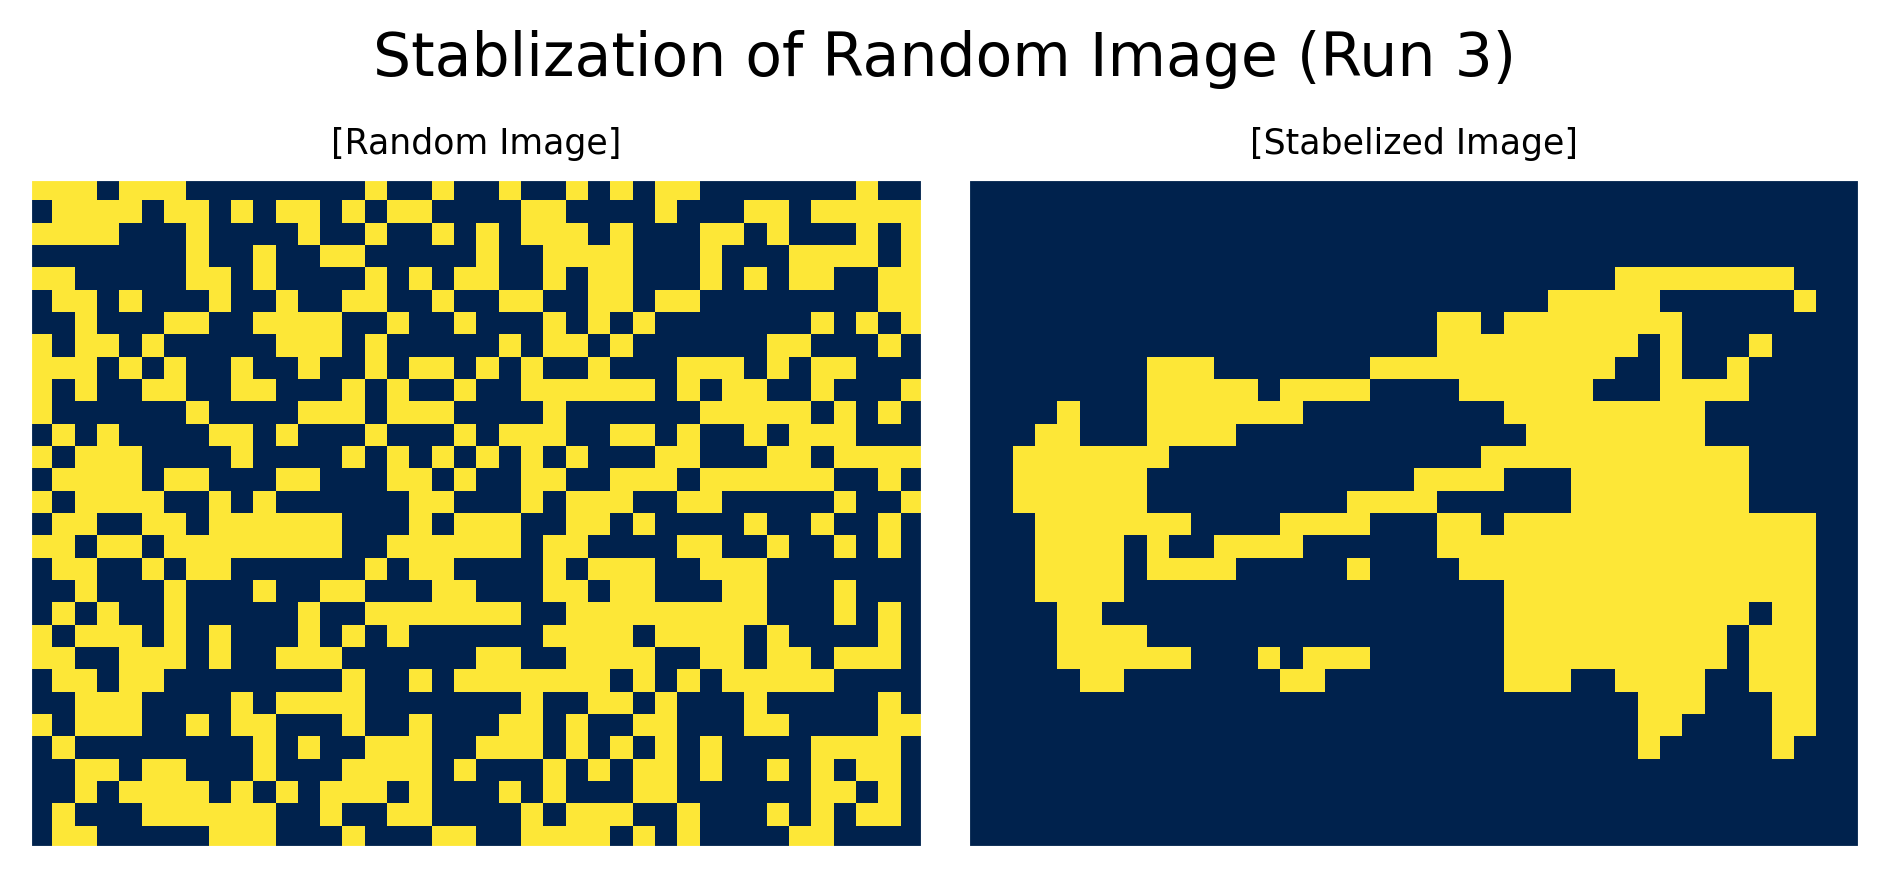

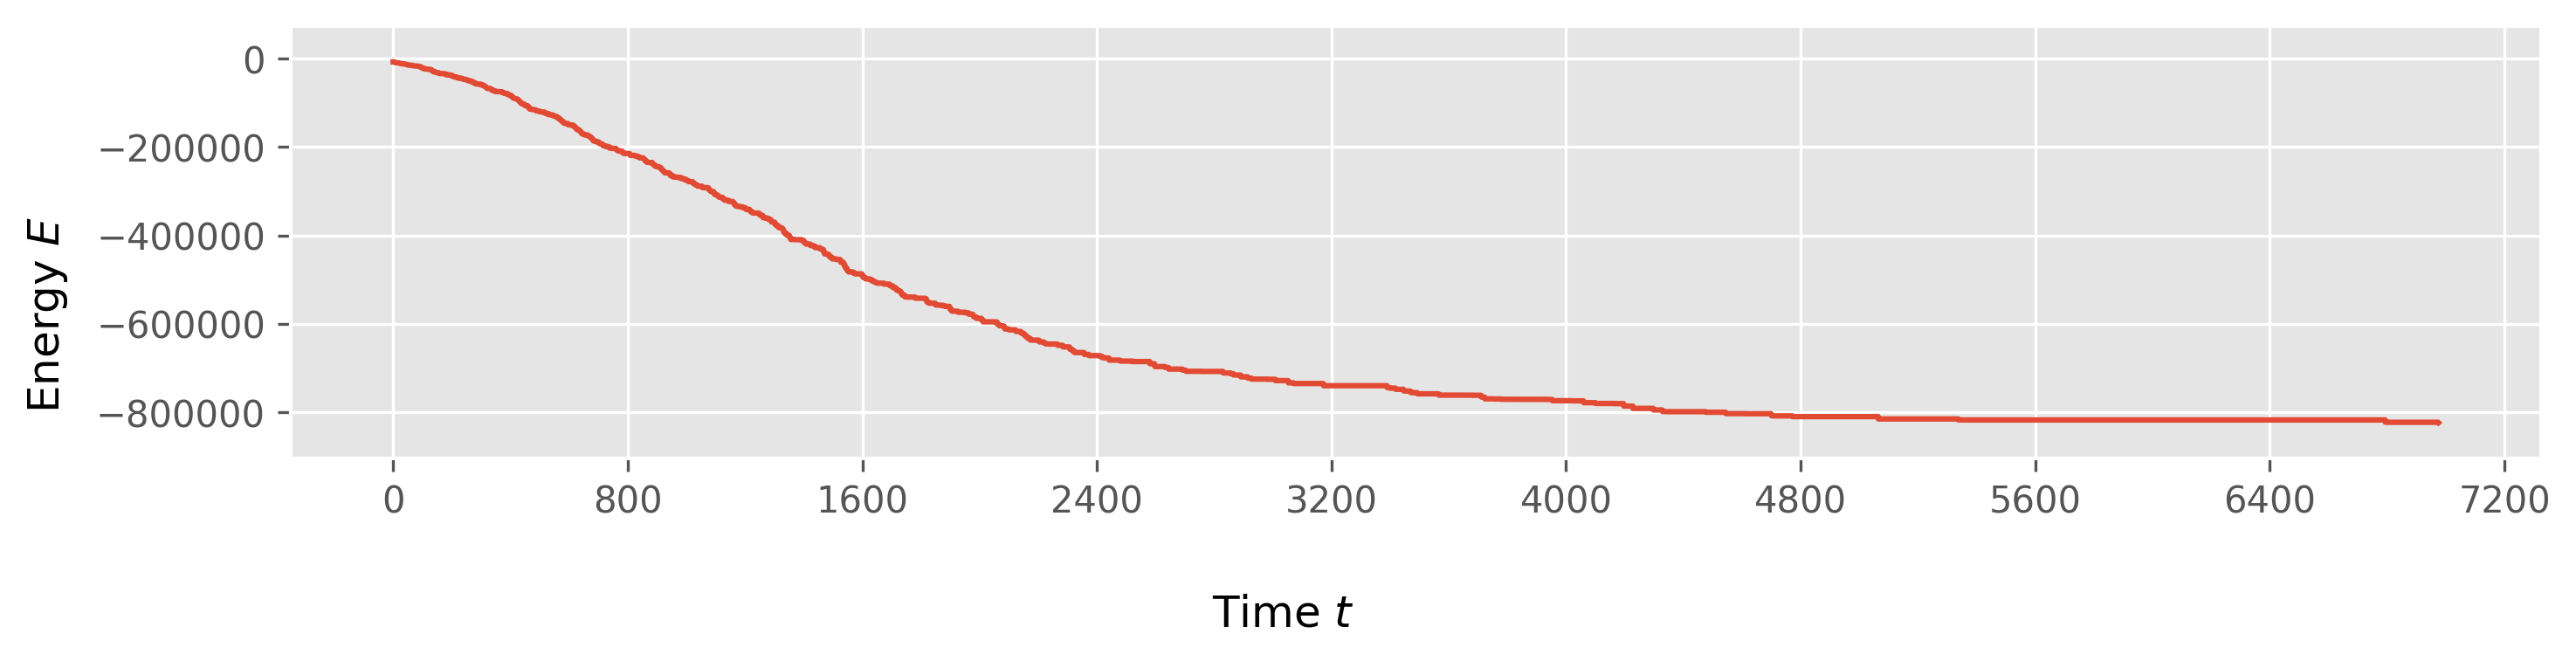

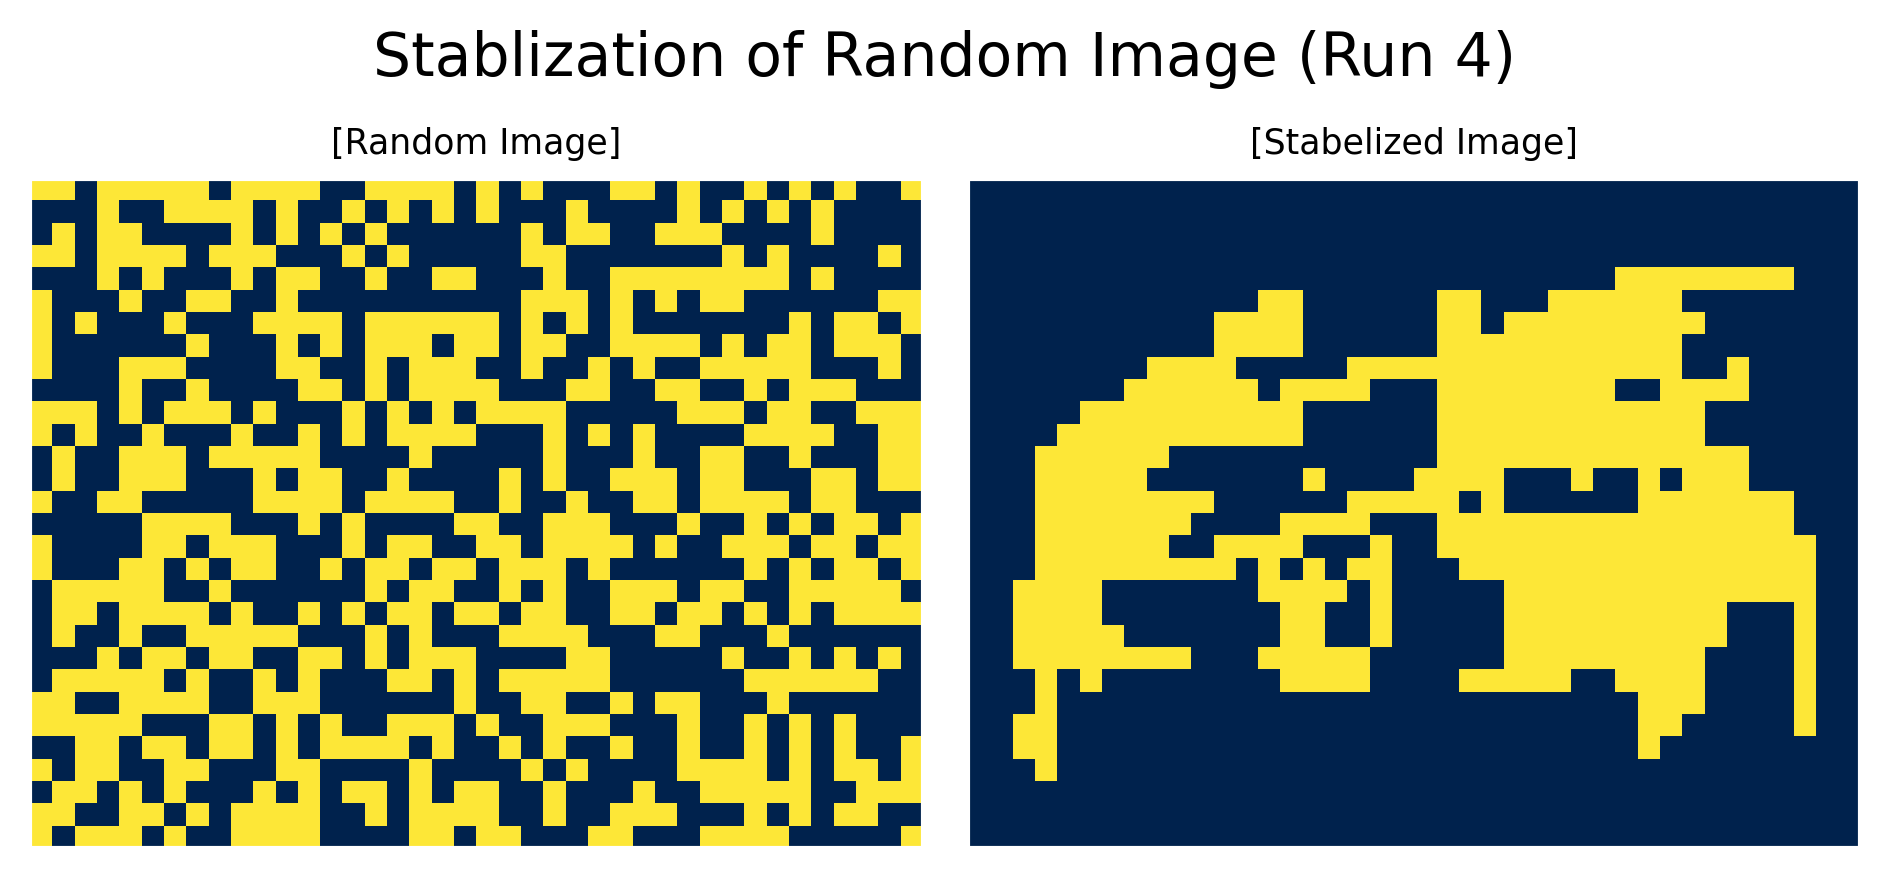

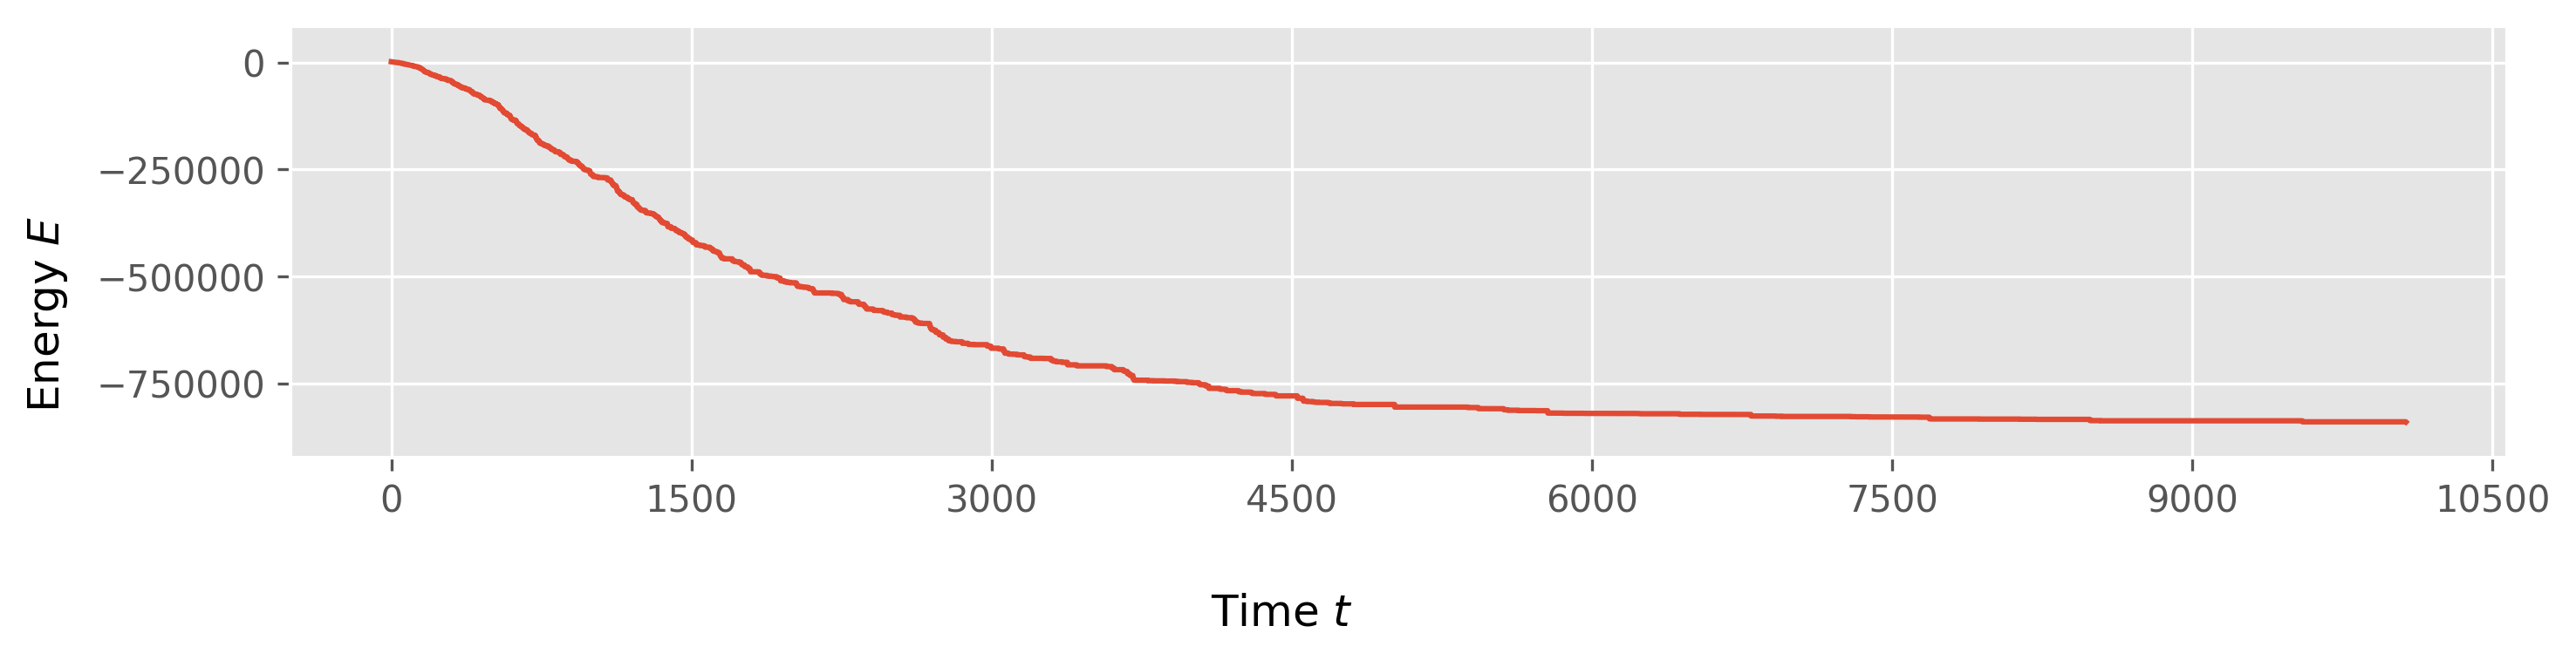

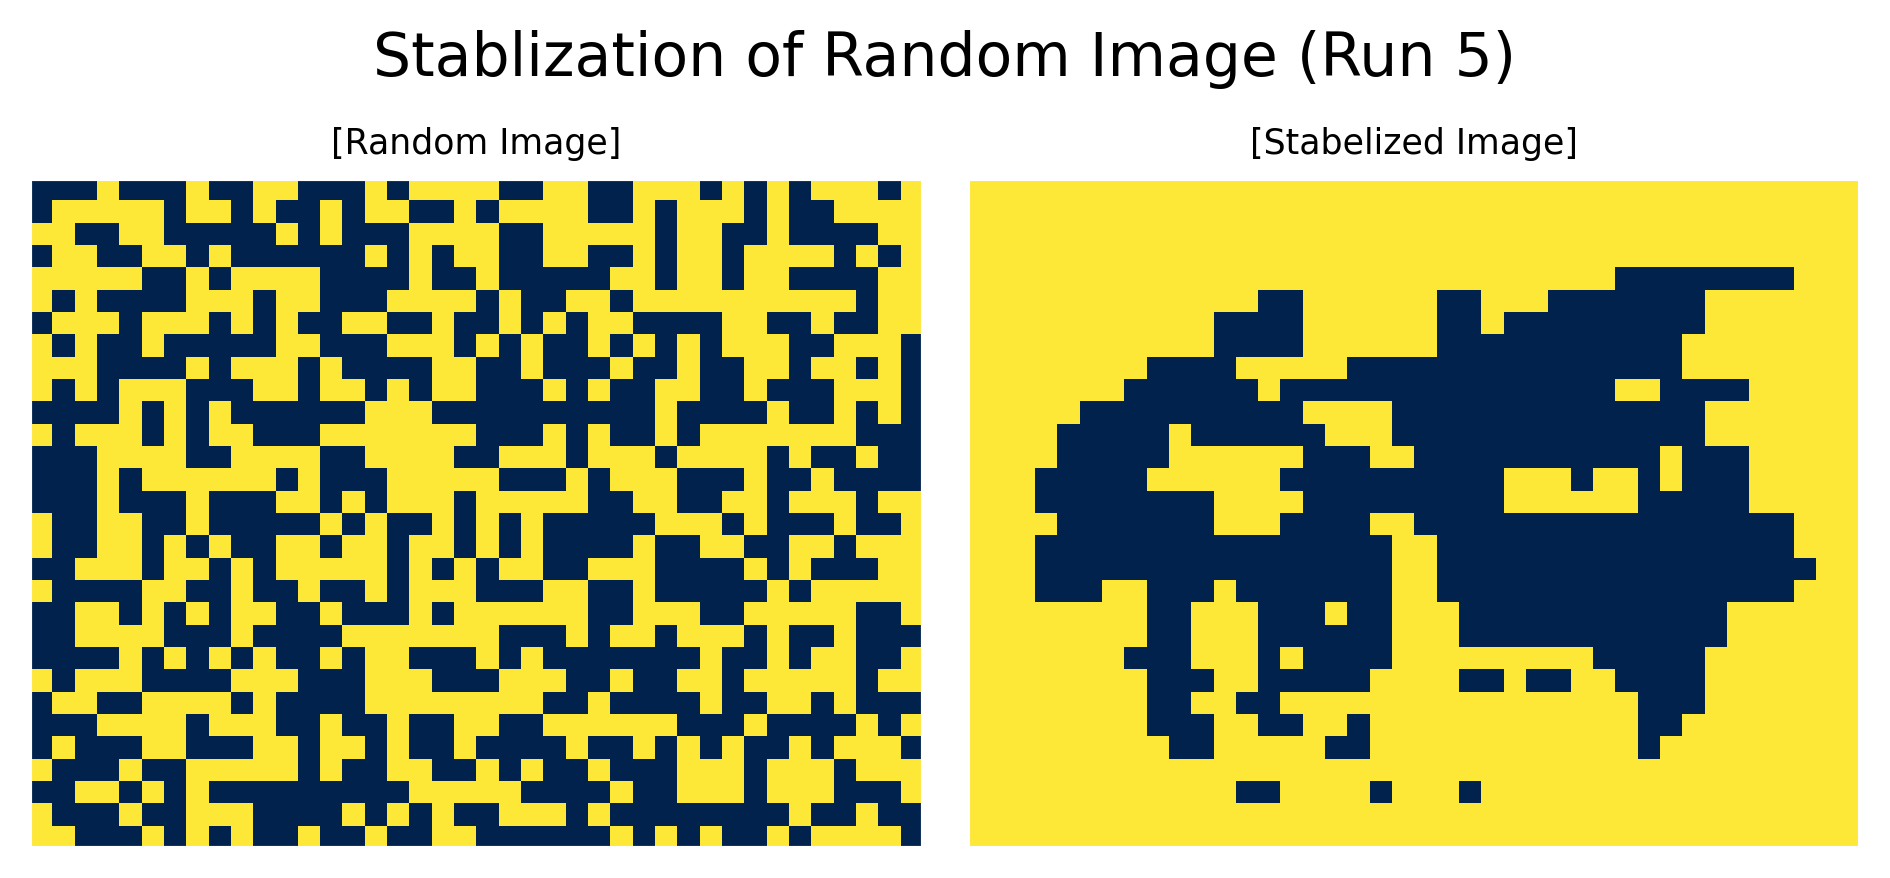

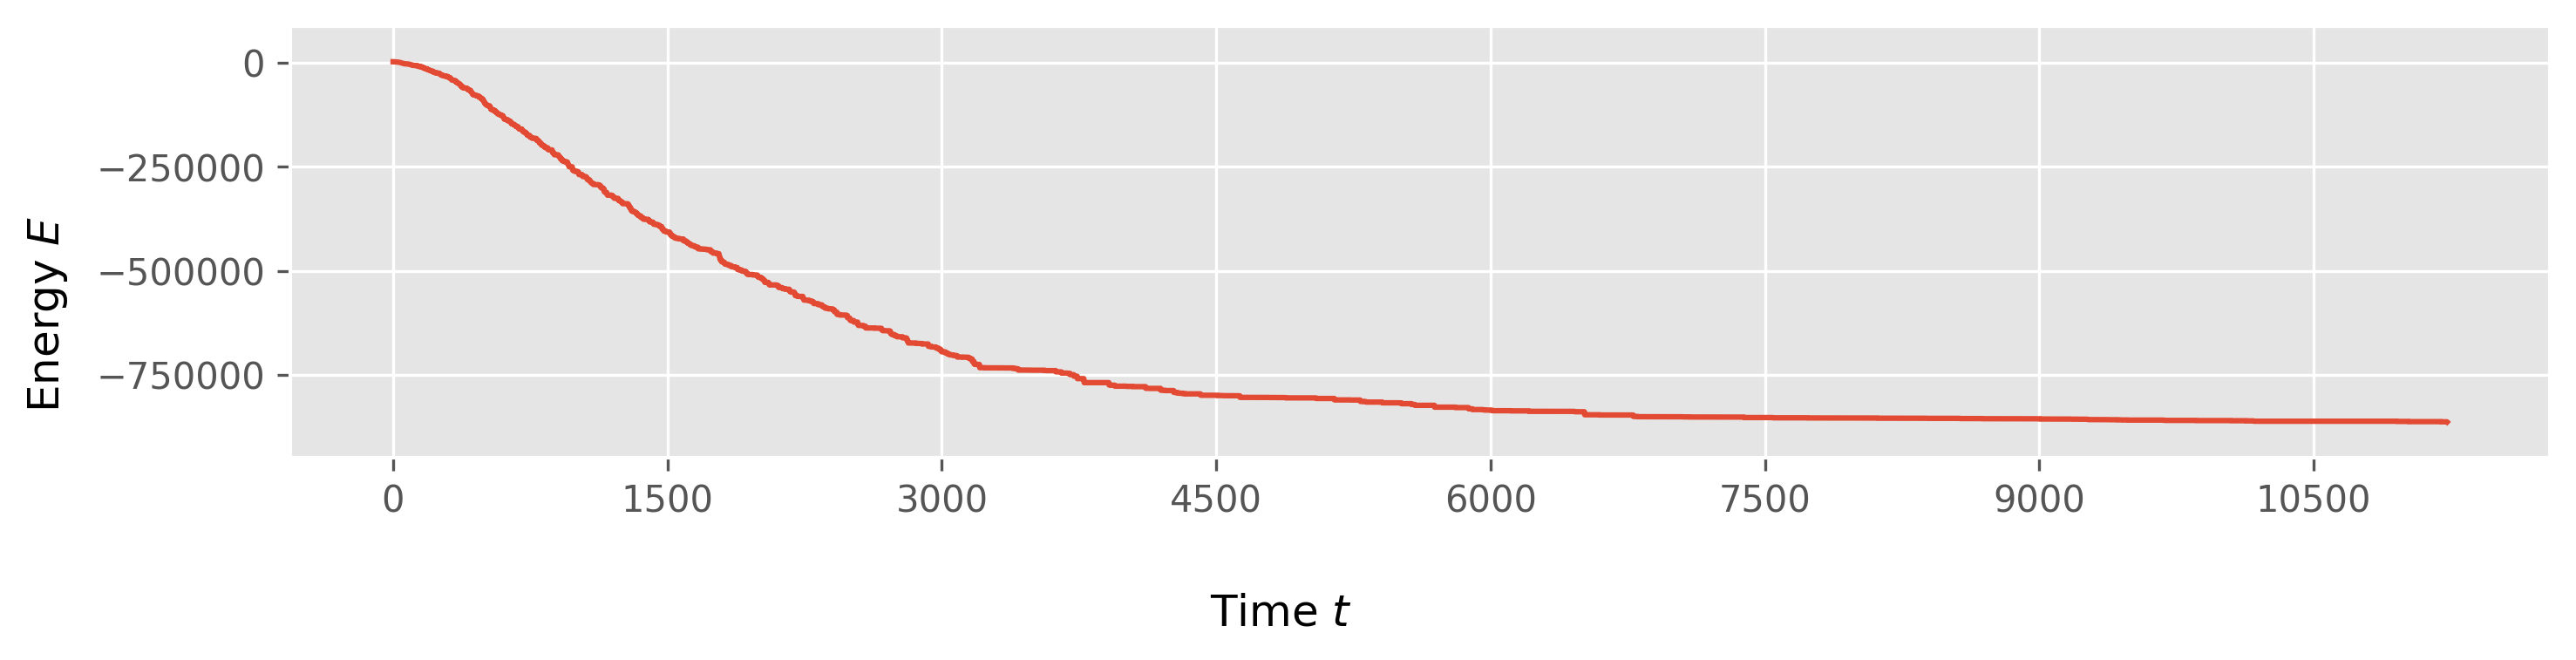

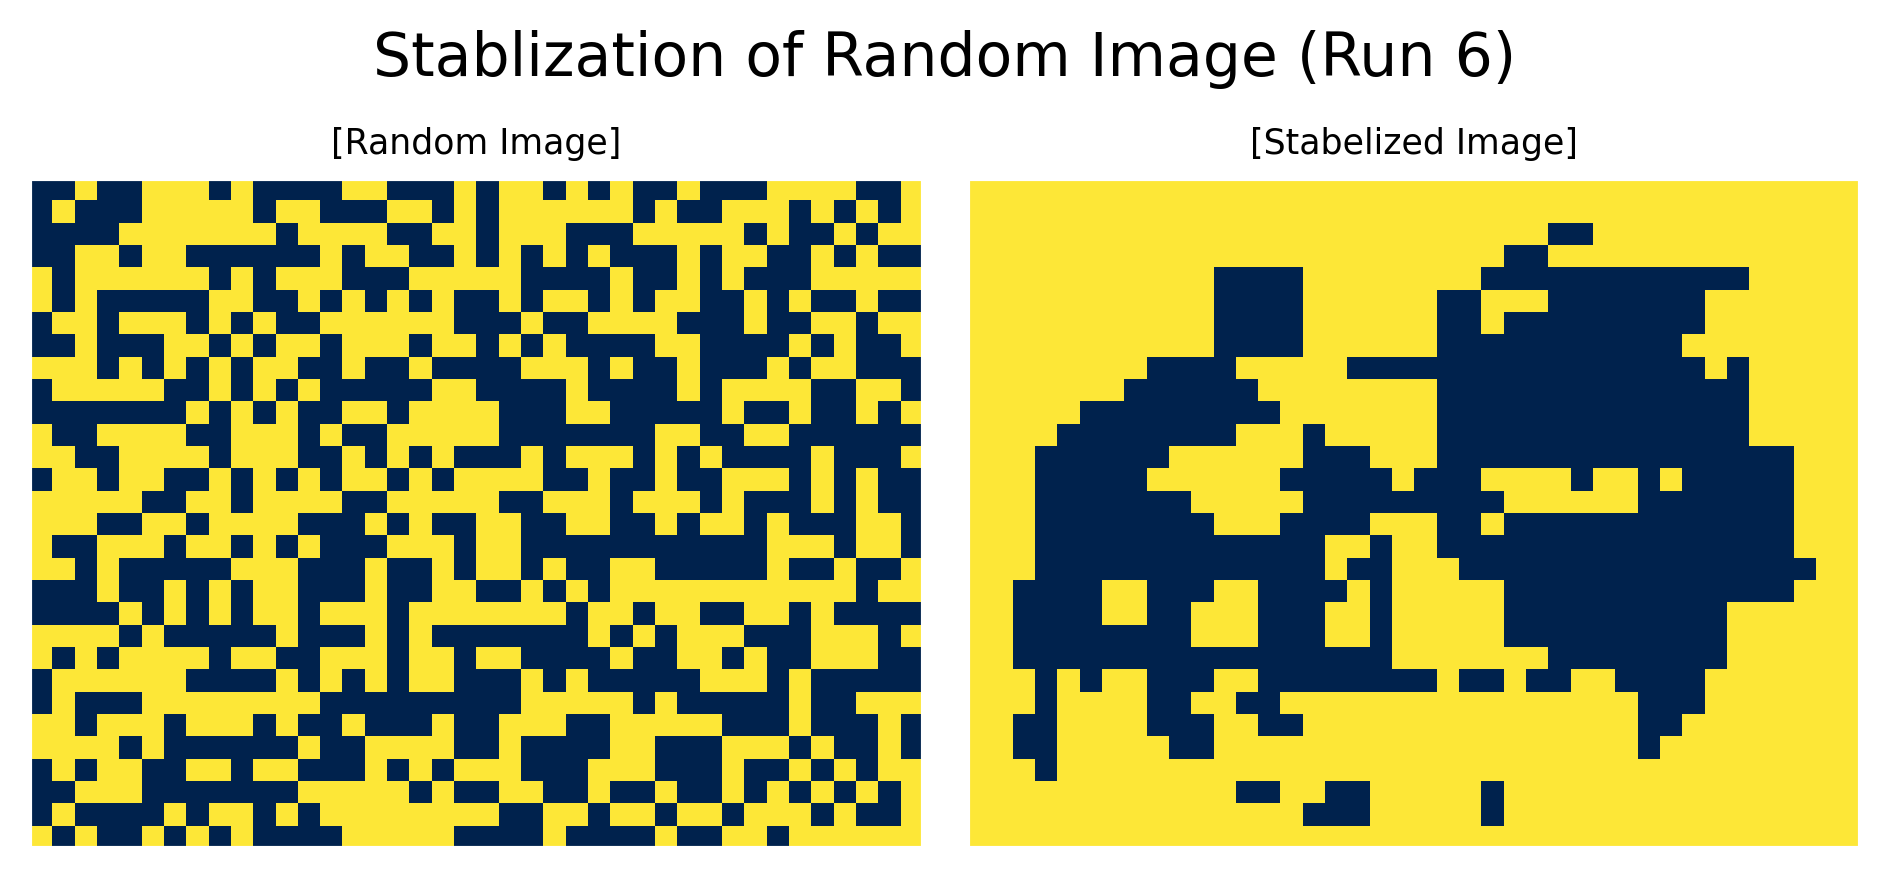

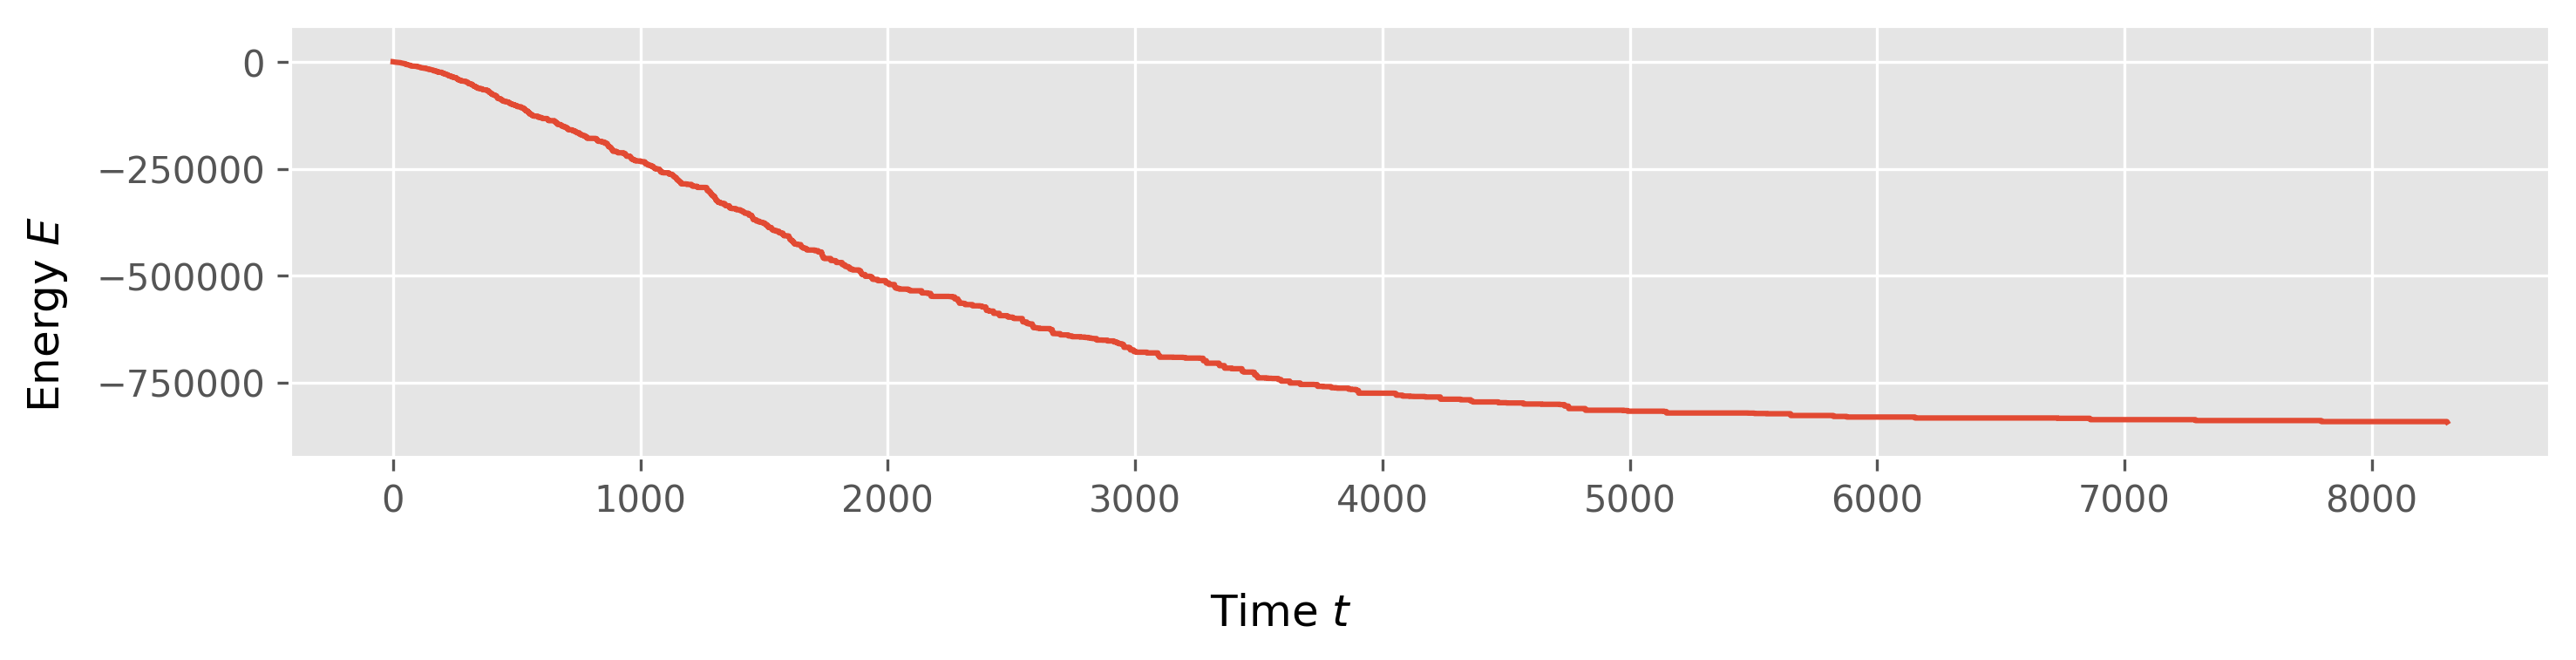

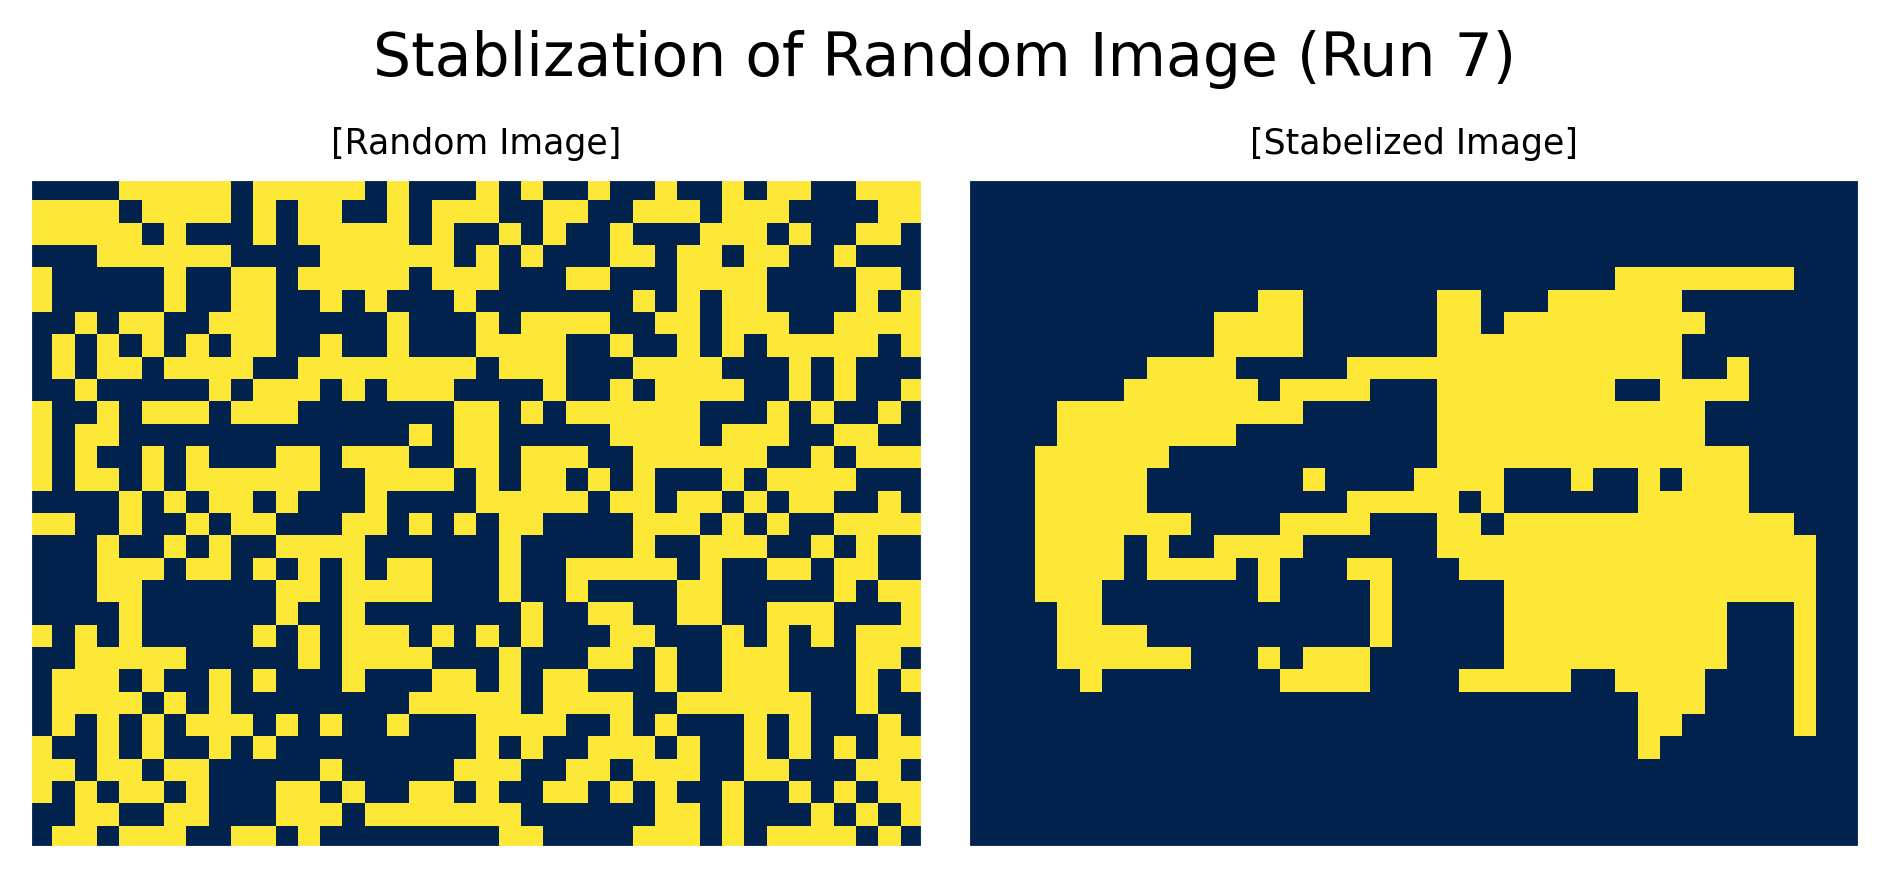

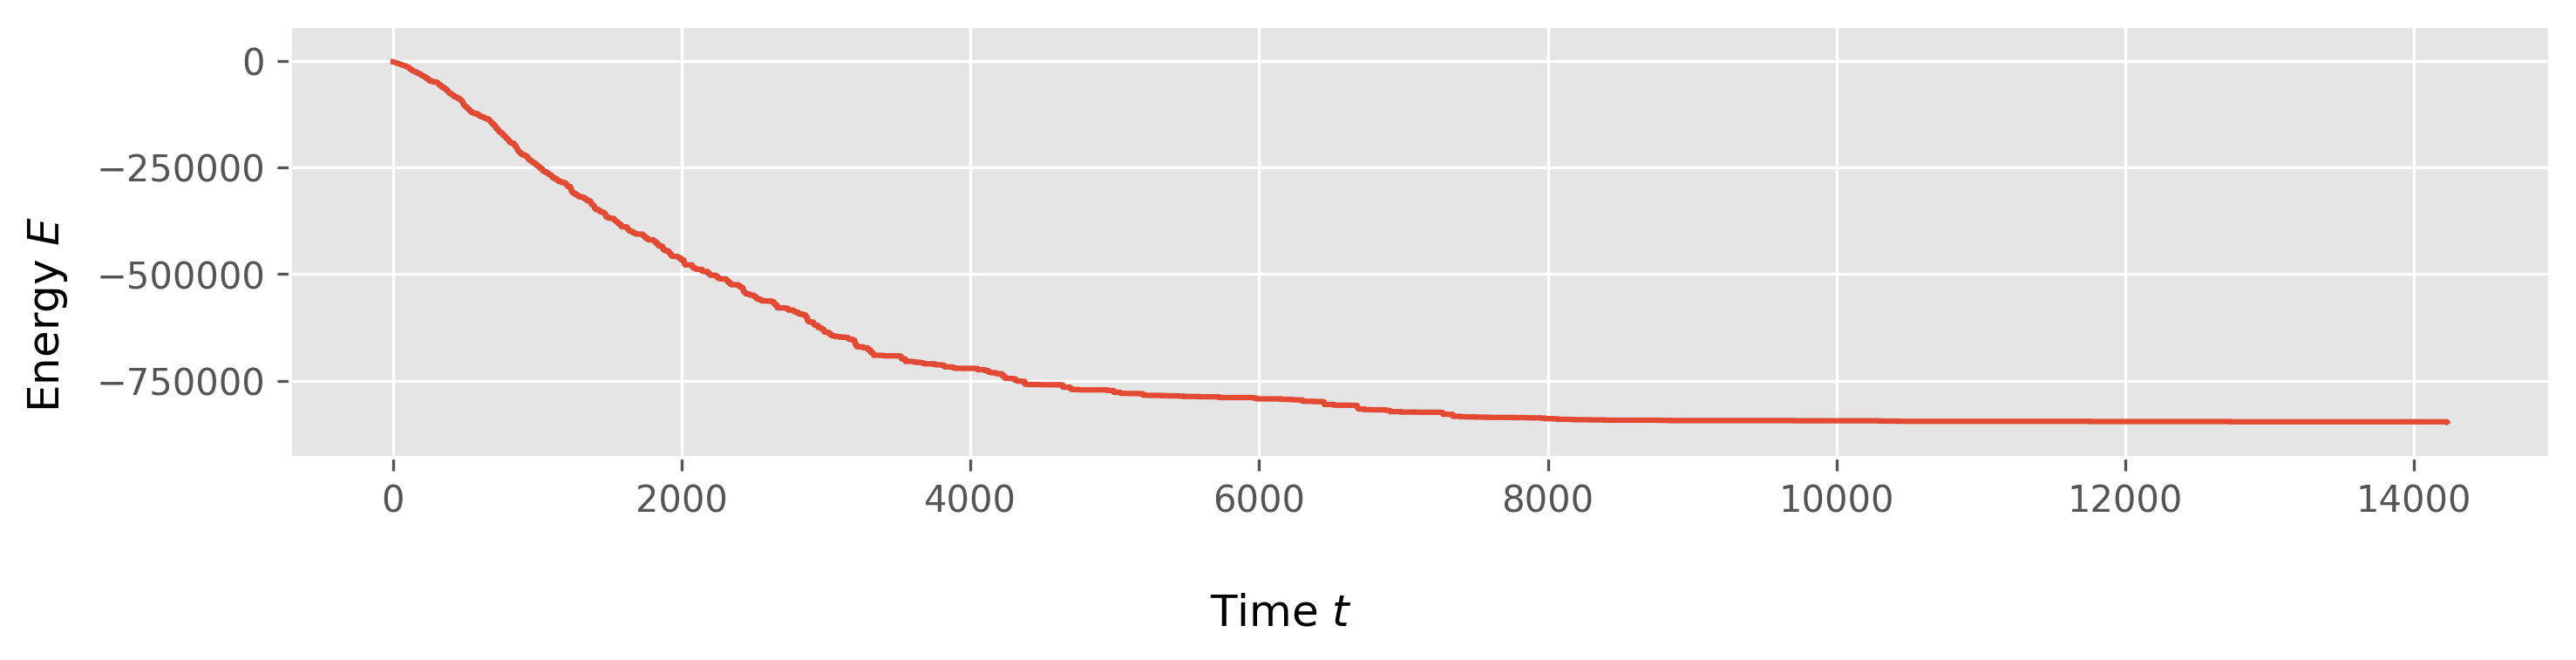

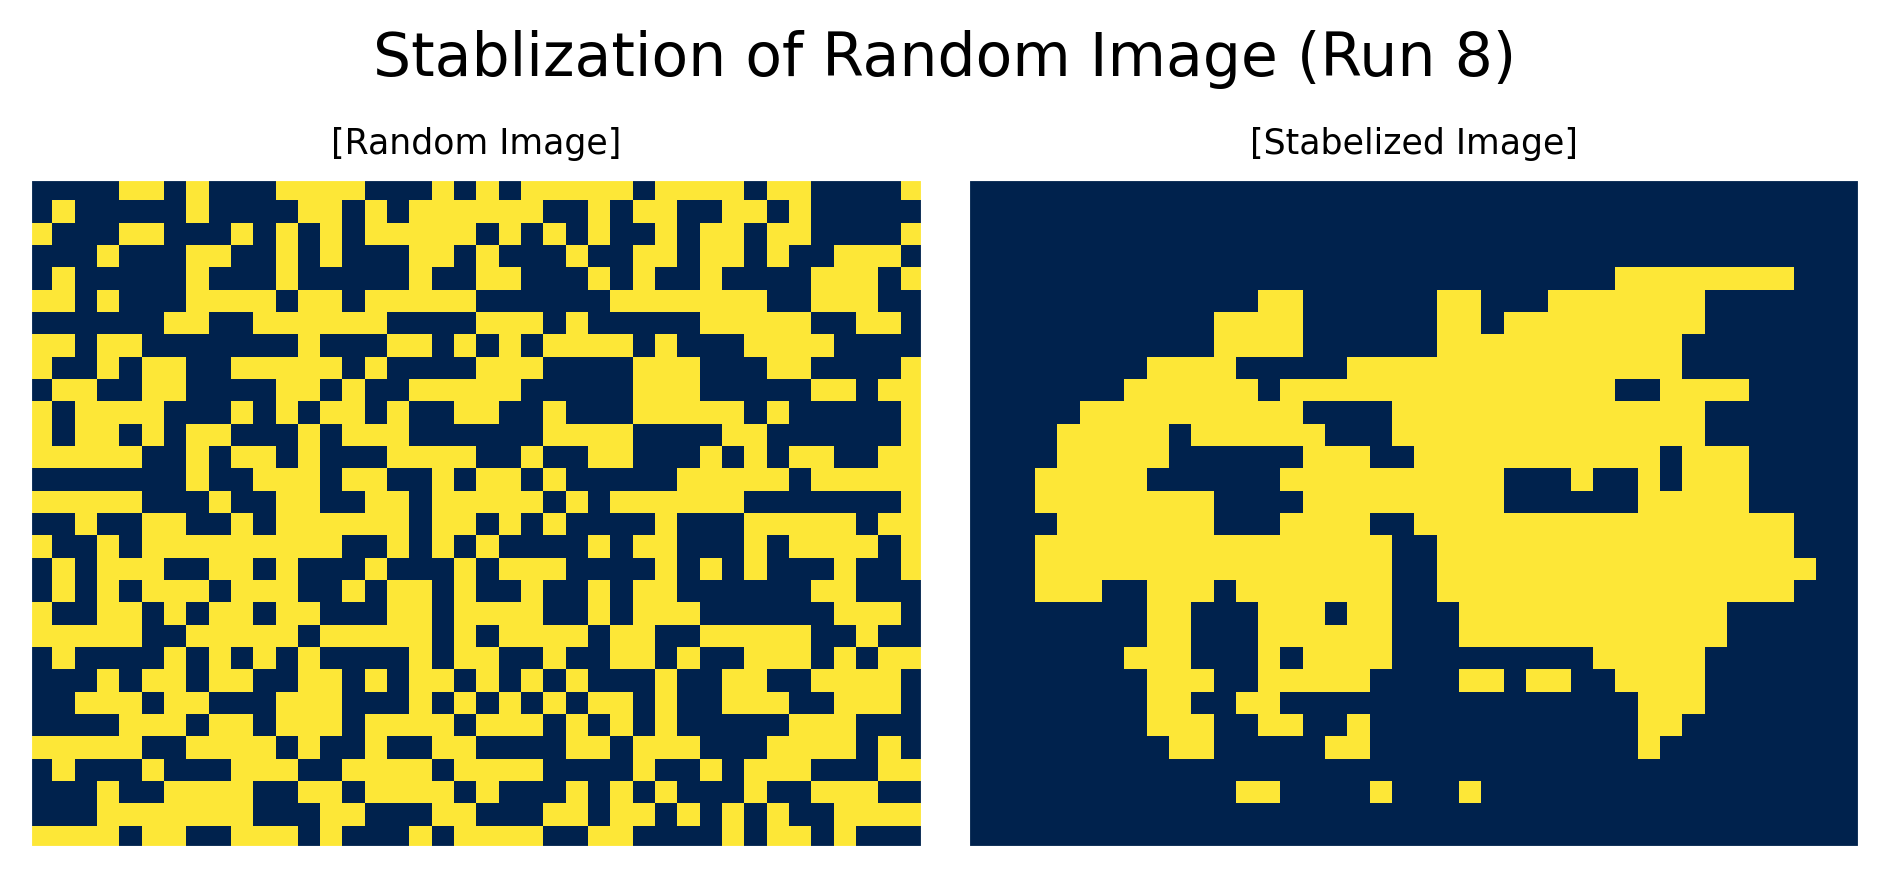

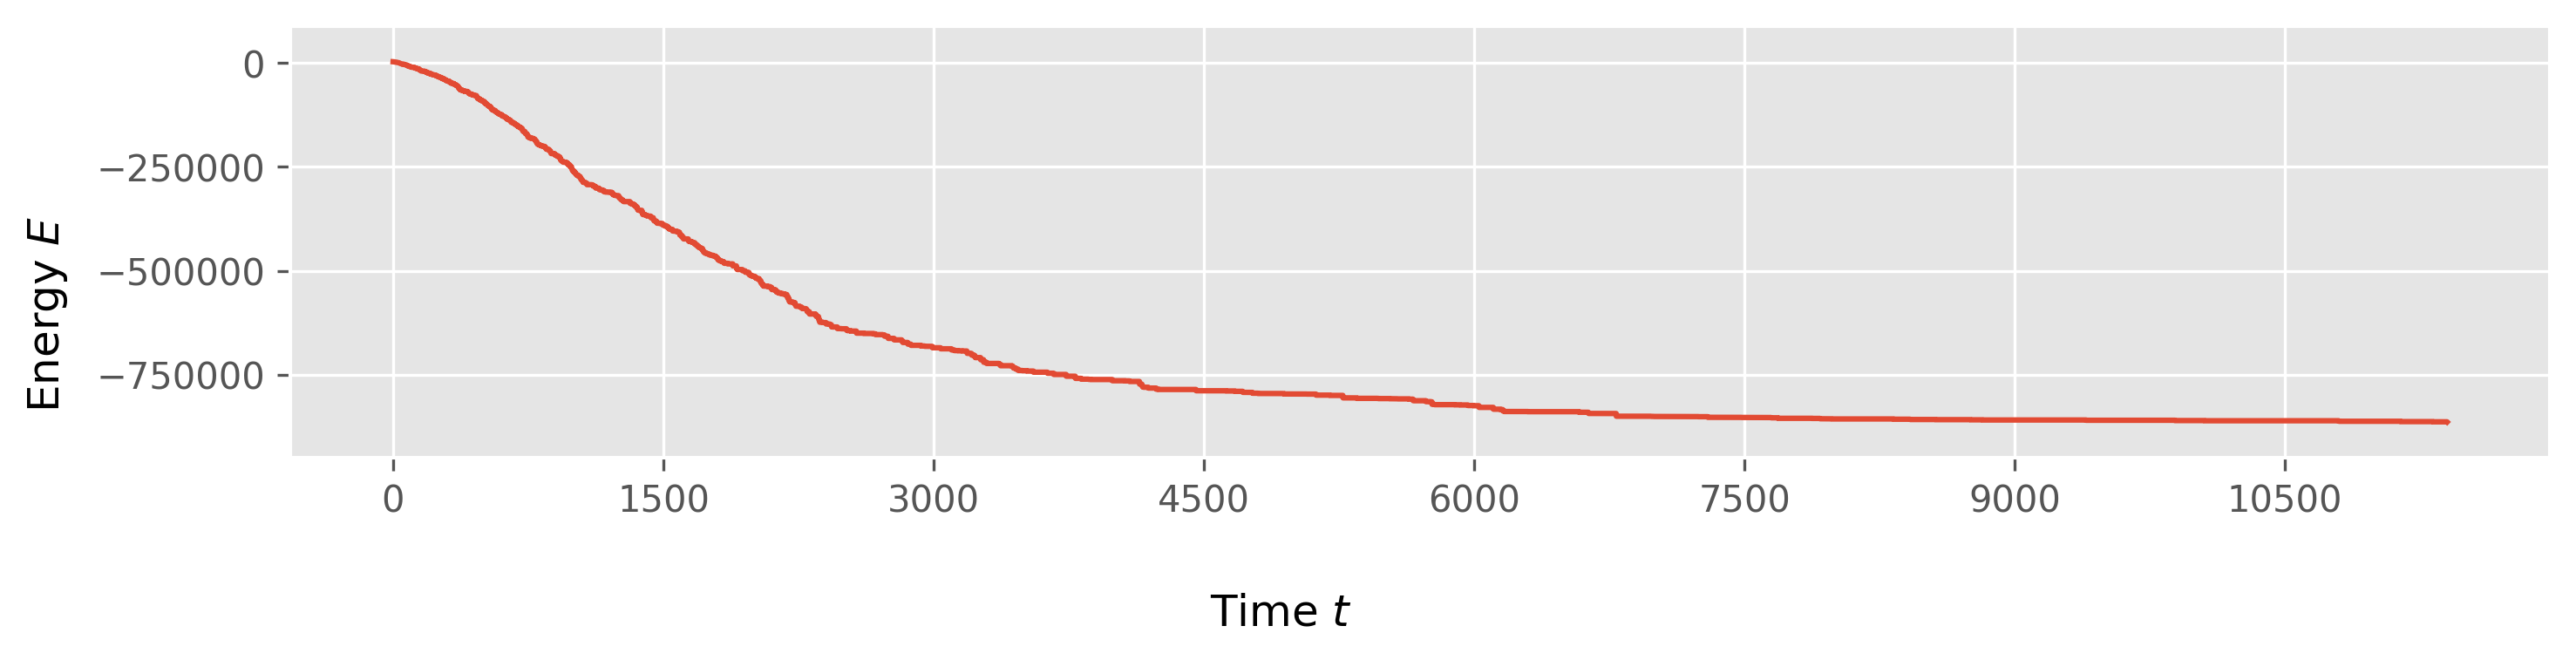

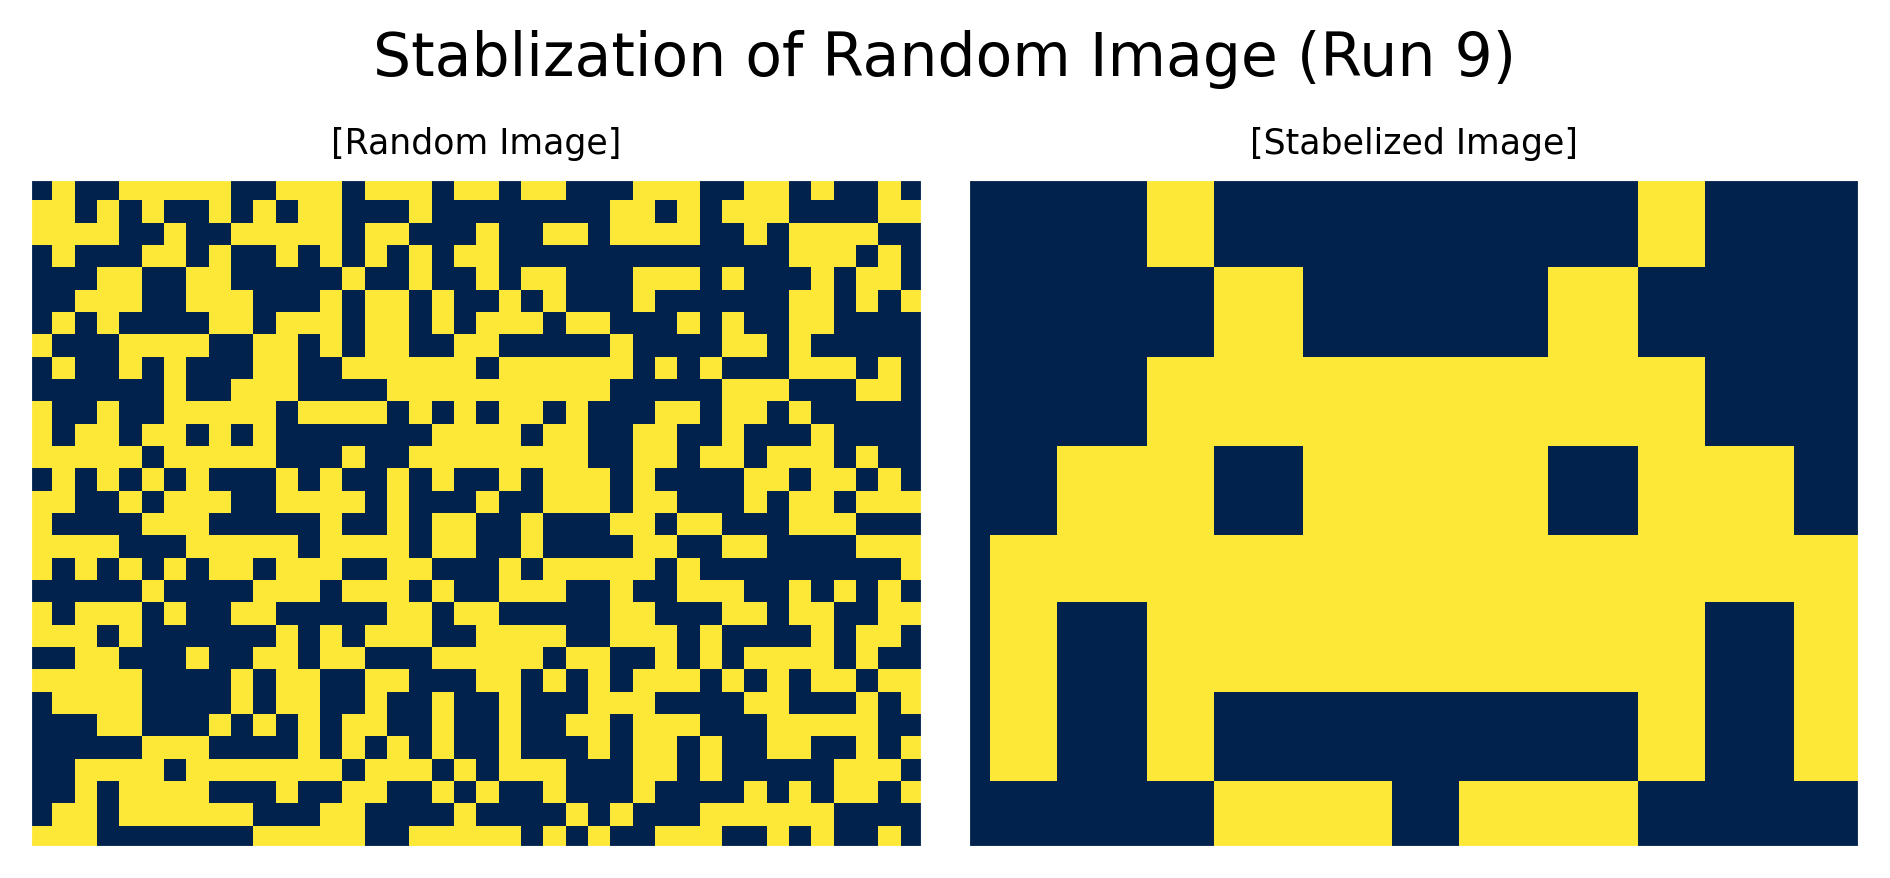

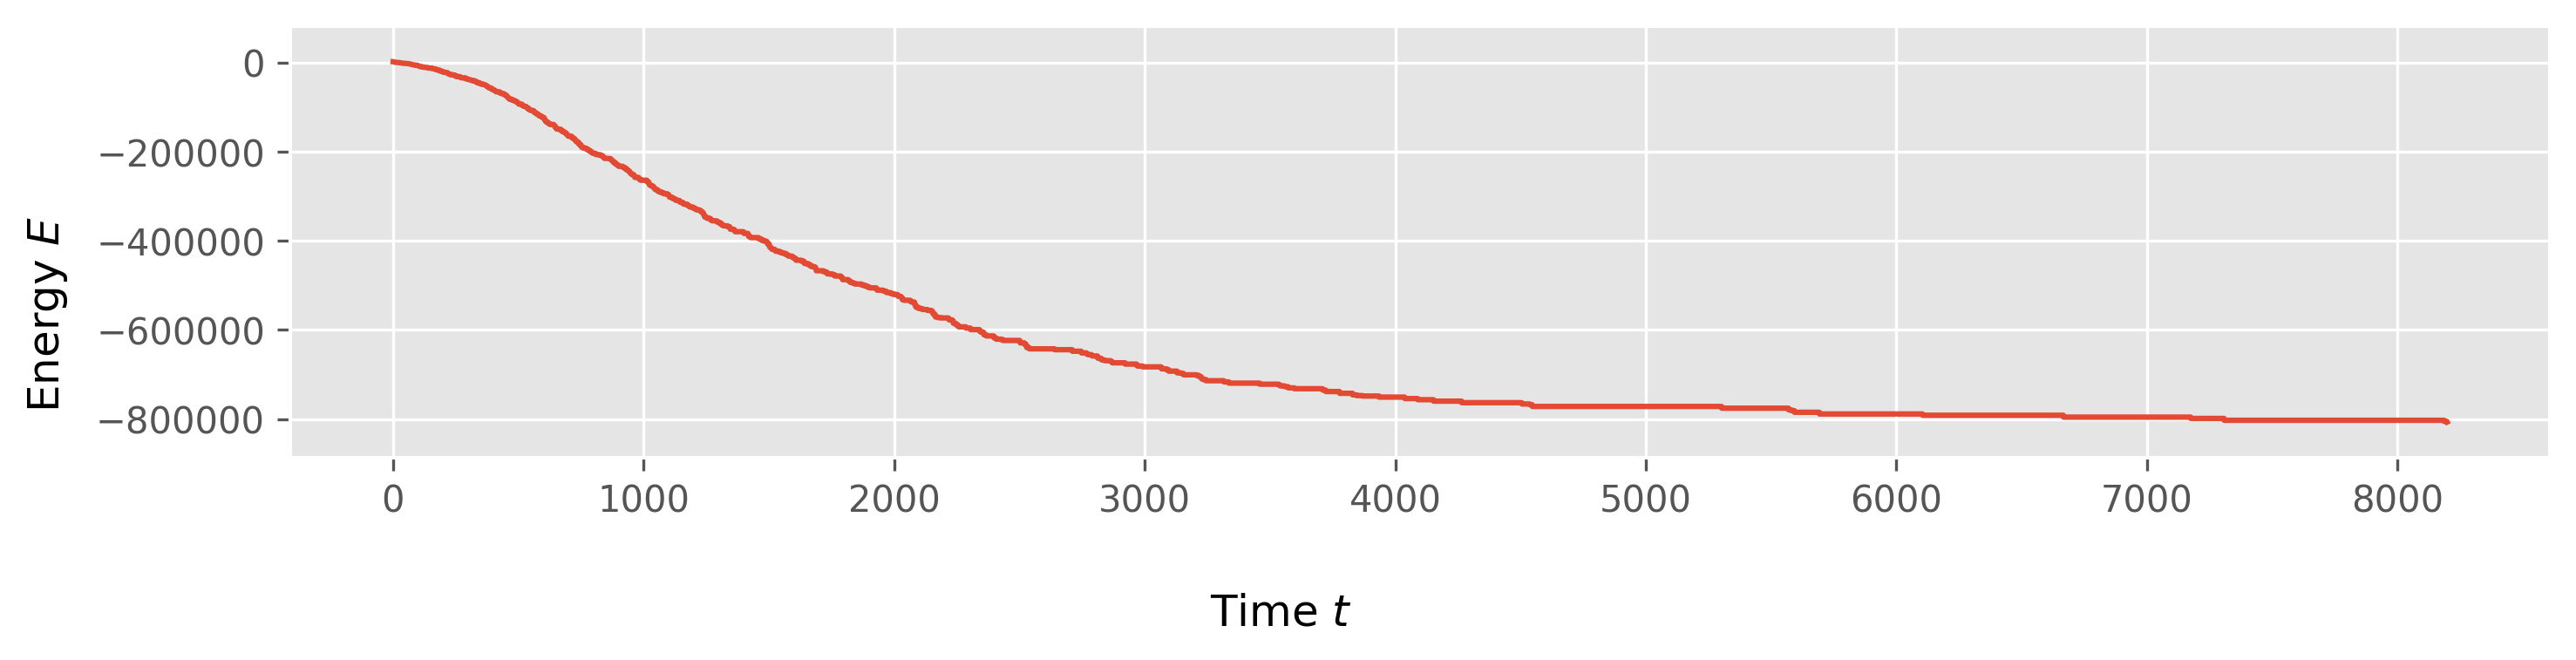

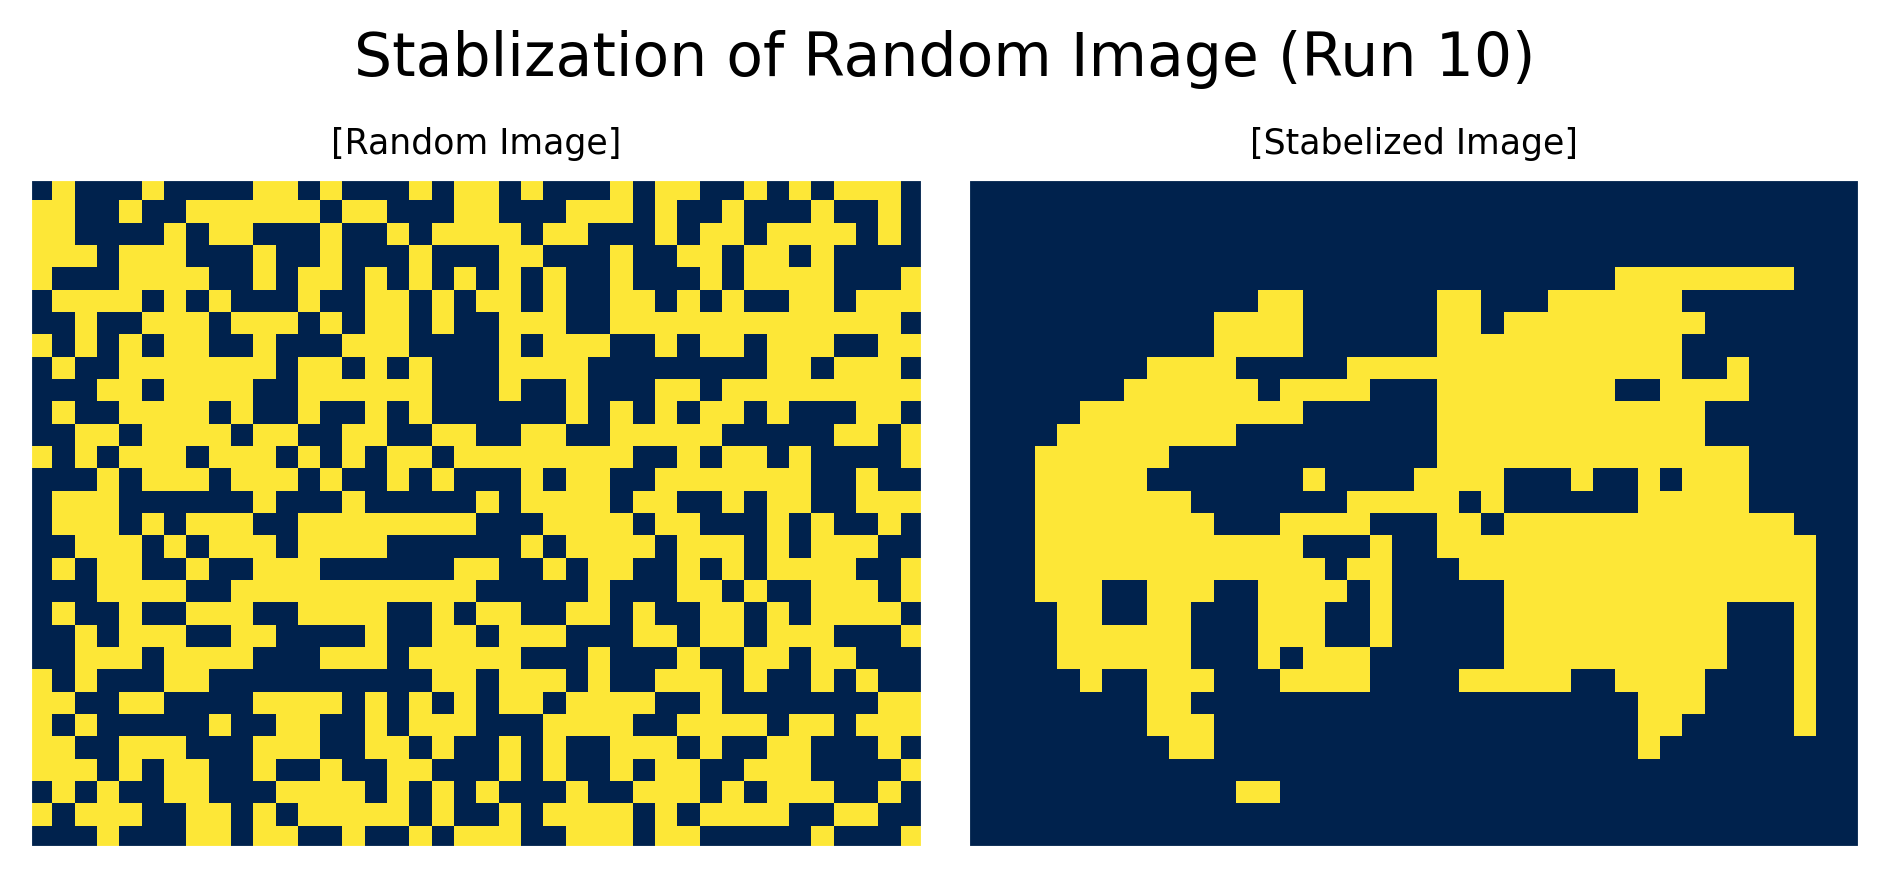

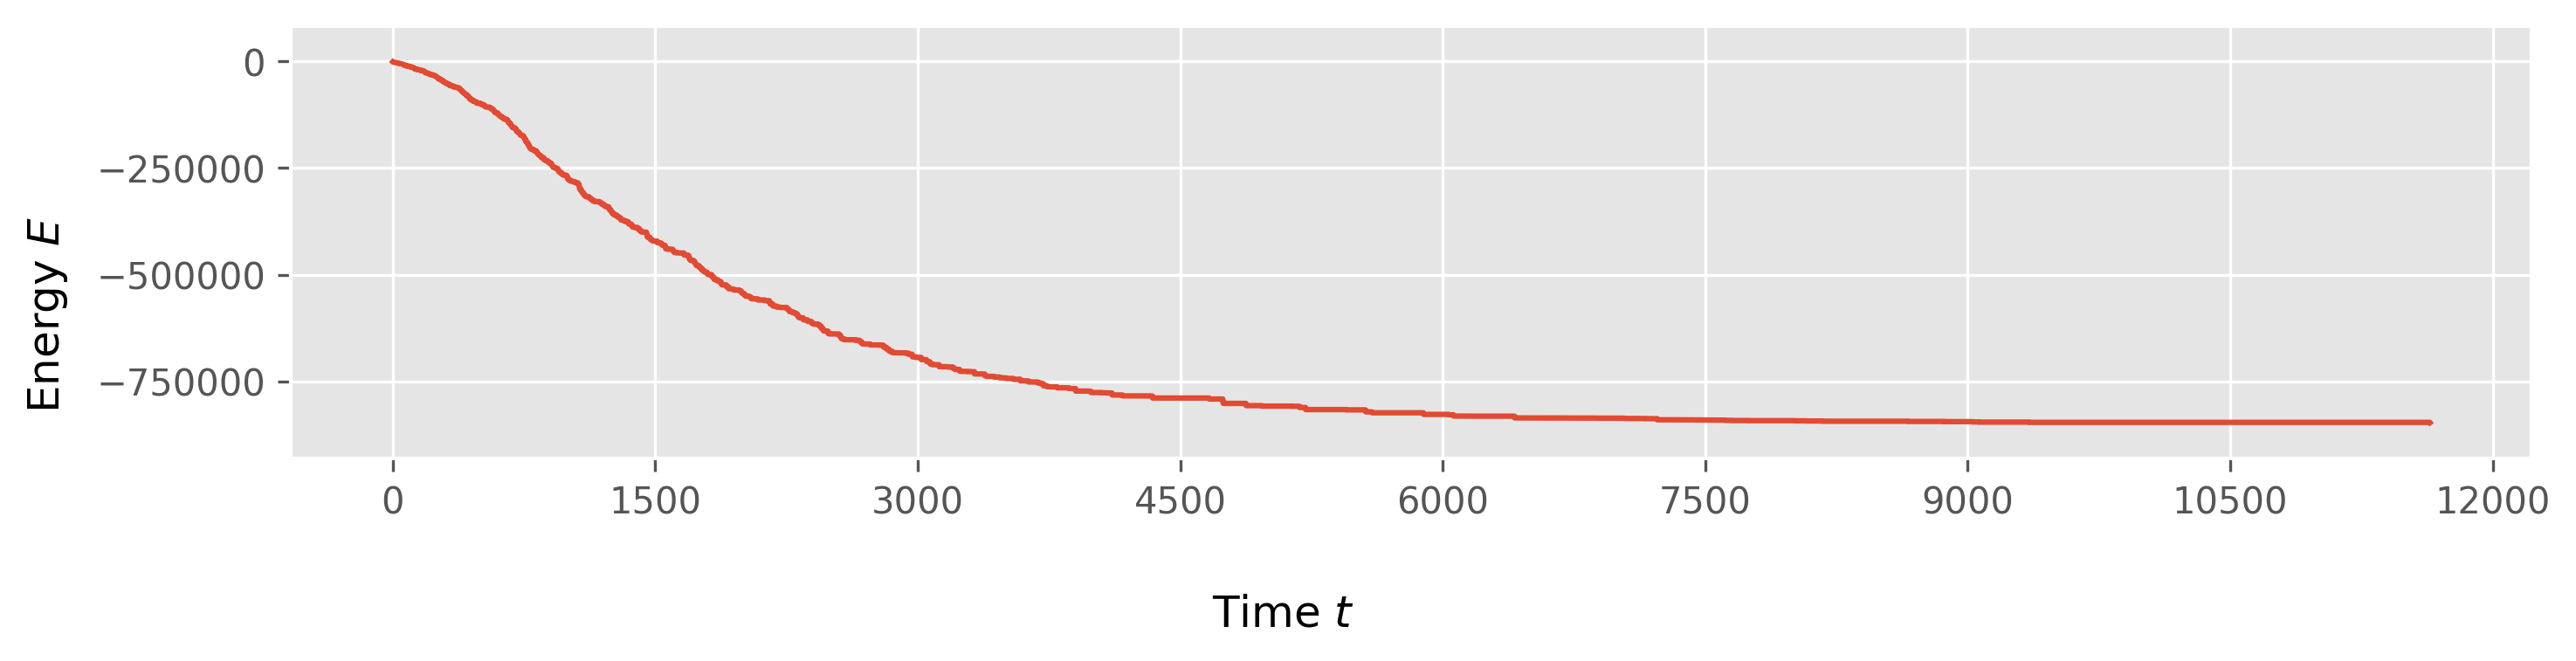

In [35]:
random_patterns: NDArray[np.int8] = generate_random_patterns(n=10)
for idx, random_pattern in enumerate(random_patterns, start=1):
    stabelized_state, energies = hopfield_network.stabilize(
        random_pattern, synchron=False
    )
    figure, axes = multi_plot_states(
        np.stack(
            [random_pattern.reshape(image_shape), stabelized_state.reshape(image_shape)]
        ),
        orientation="horizontal",
        show_axis=False,
        show_legend=False,
    )

    axes[0, 0].set_title("[Random Image]", fontsize="small")
    axes[0, 1].set_title("[Stabelized Image]", fontsize="small")

    figure.suptitle(
        f"Stablization of Random Image (Run {idx})", fontsize="x-large", y=0.8
    )
    figure.tight_layout()

    figure, _ = multi_plot_energy_evolution([energies], style="line", figsize=(10, 2.5))
    figure.tight_layout()

**Interpretation of Results**

TODO

### Stabilization of Partially Random Images

In [18]:
def generate_partially_random_patterns(
    source_pattern: NDArray[np.int8],
    p: float = 0.25,
    n: int = 2,
    rng: np.random.Generator = RNG,
) -> NDArray[np.int8]:
    patterns: NDArray[np.int8] = generate_random_patterns(n=n, rng=rng)
    replacement_indices: NDArray[np.int32] = rng.choice(
        patterns.size, size=int(patterns.size * p), replace=False
    )
    patterns.flat[replacement_indices] = source_pattern[
        np.mod(replacement_indices, source_pattern.shape[0])
    ]
    return patterns

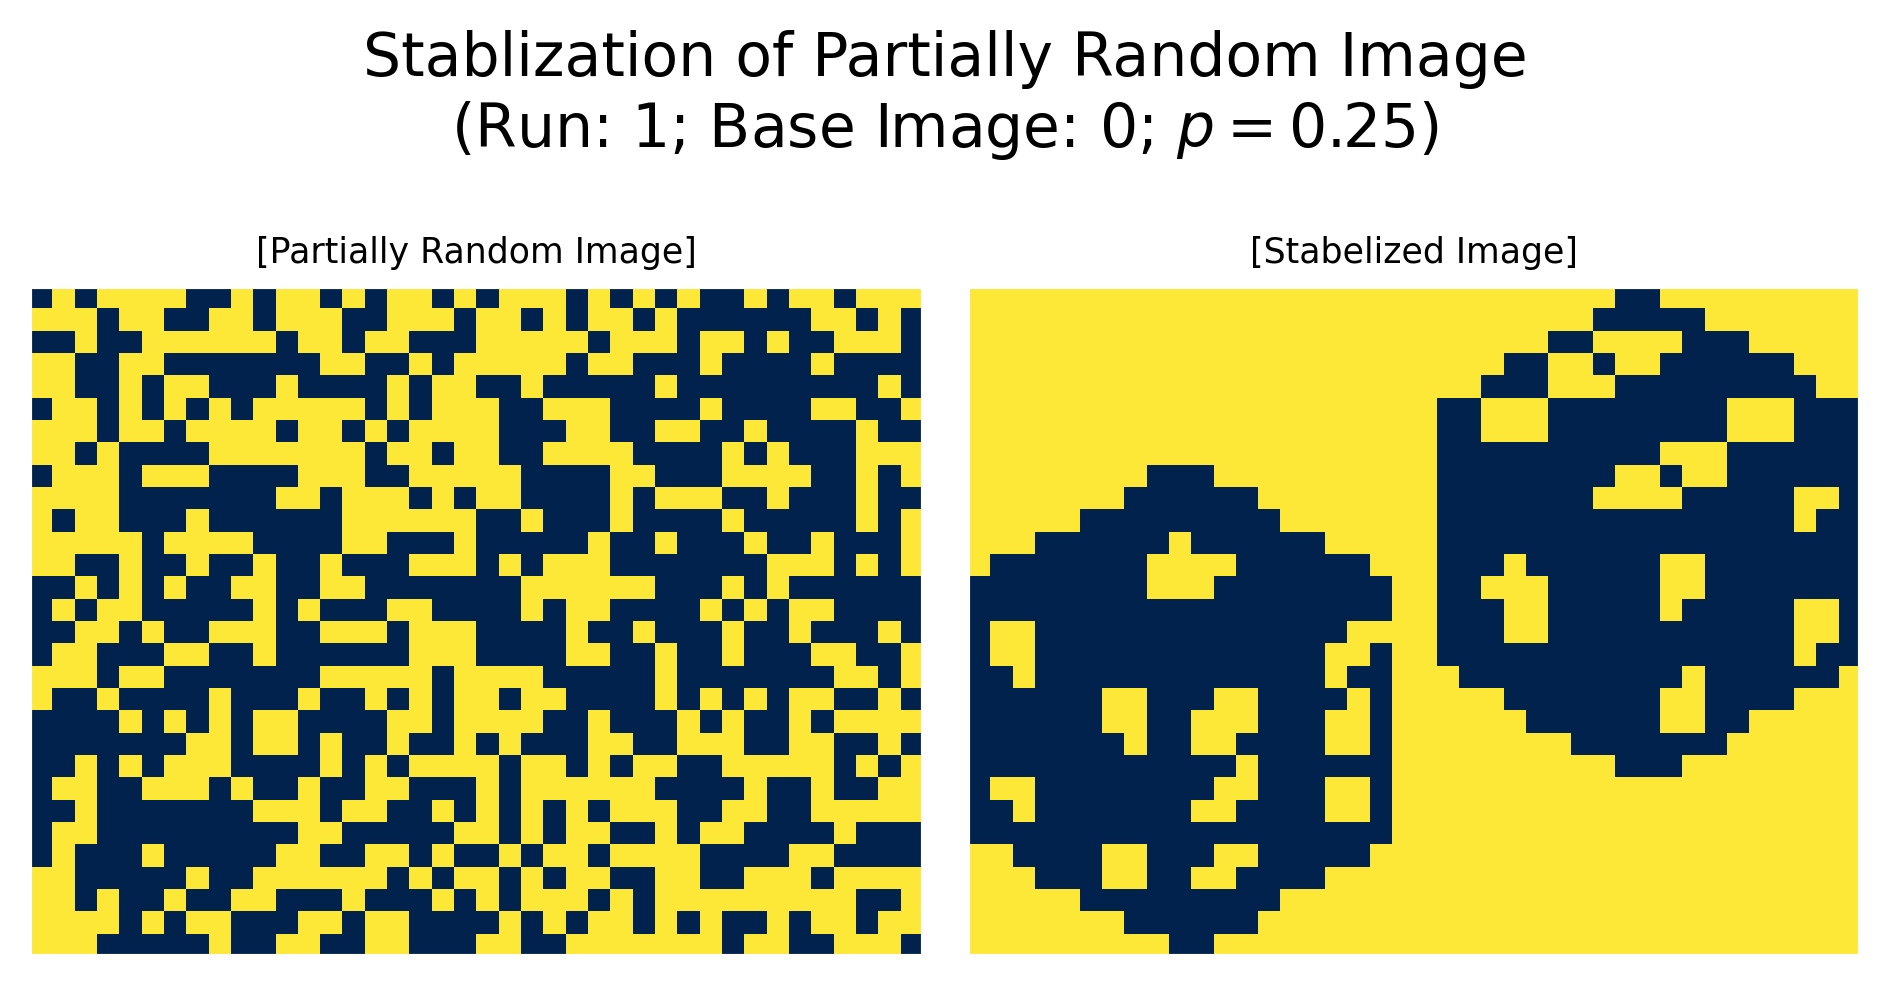

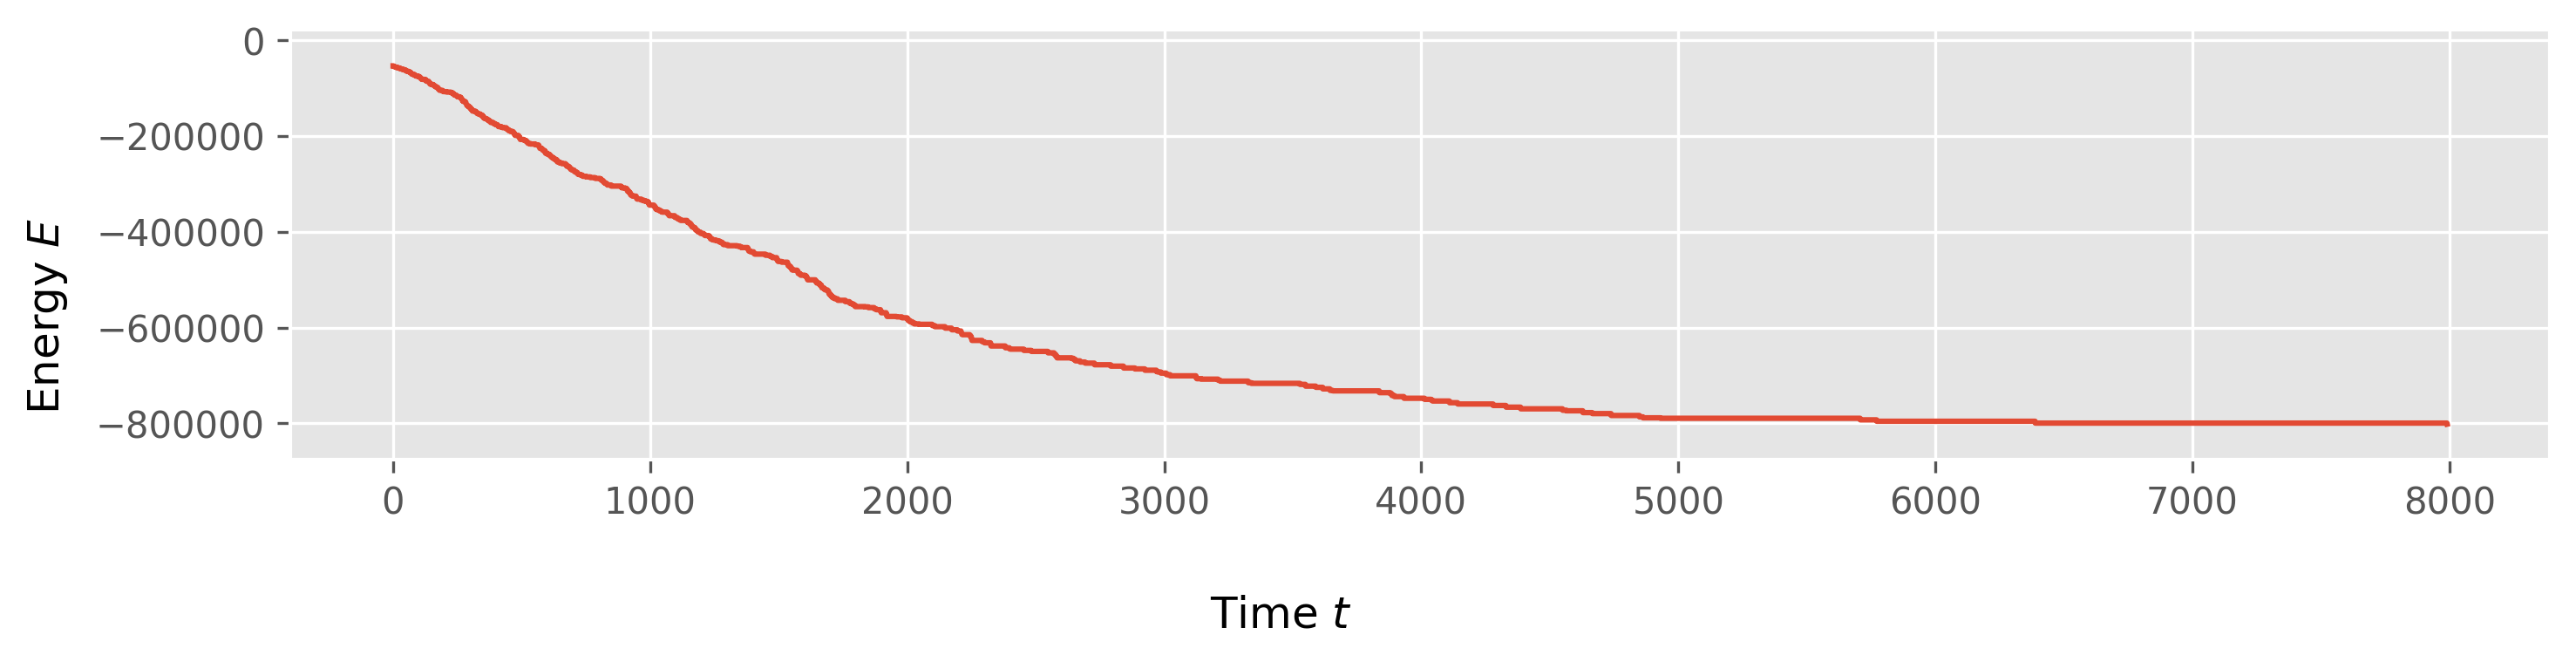

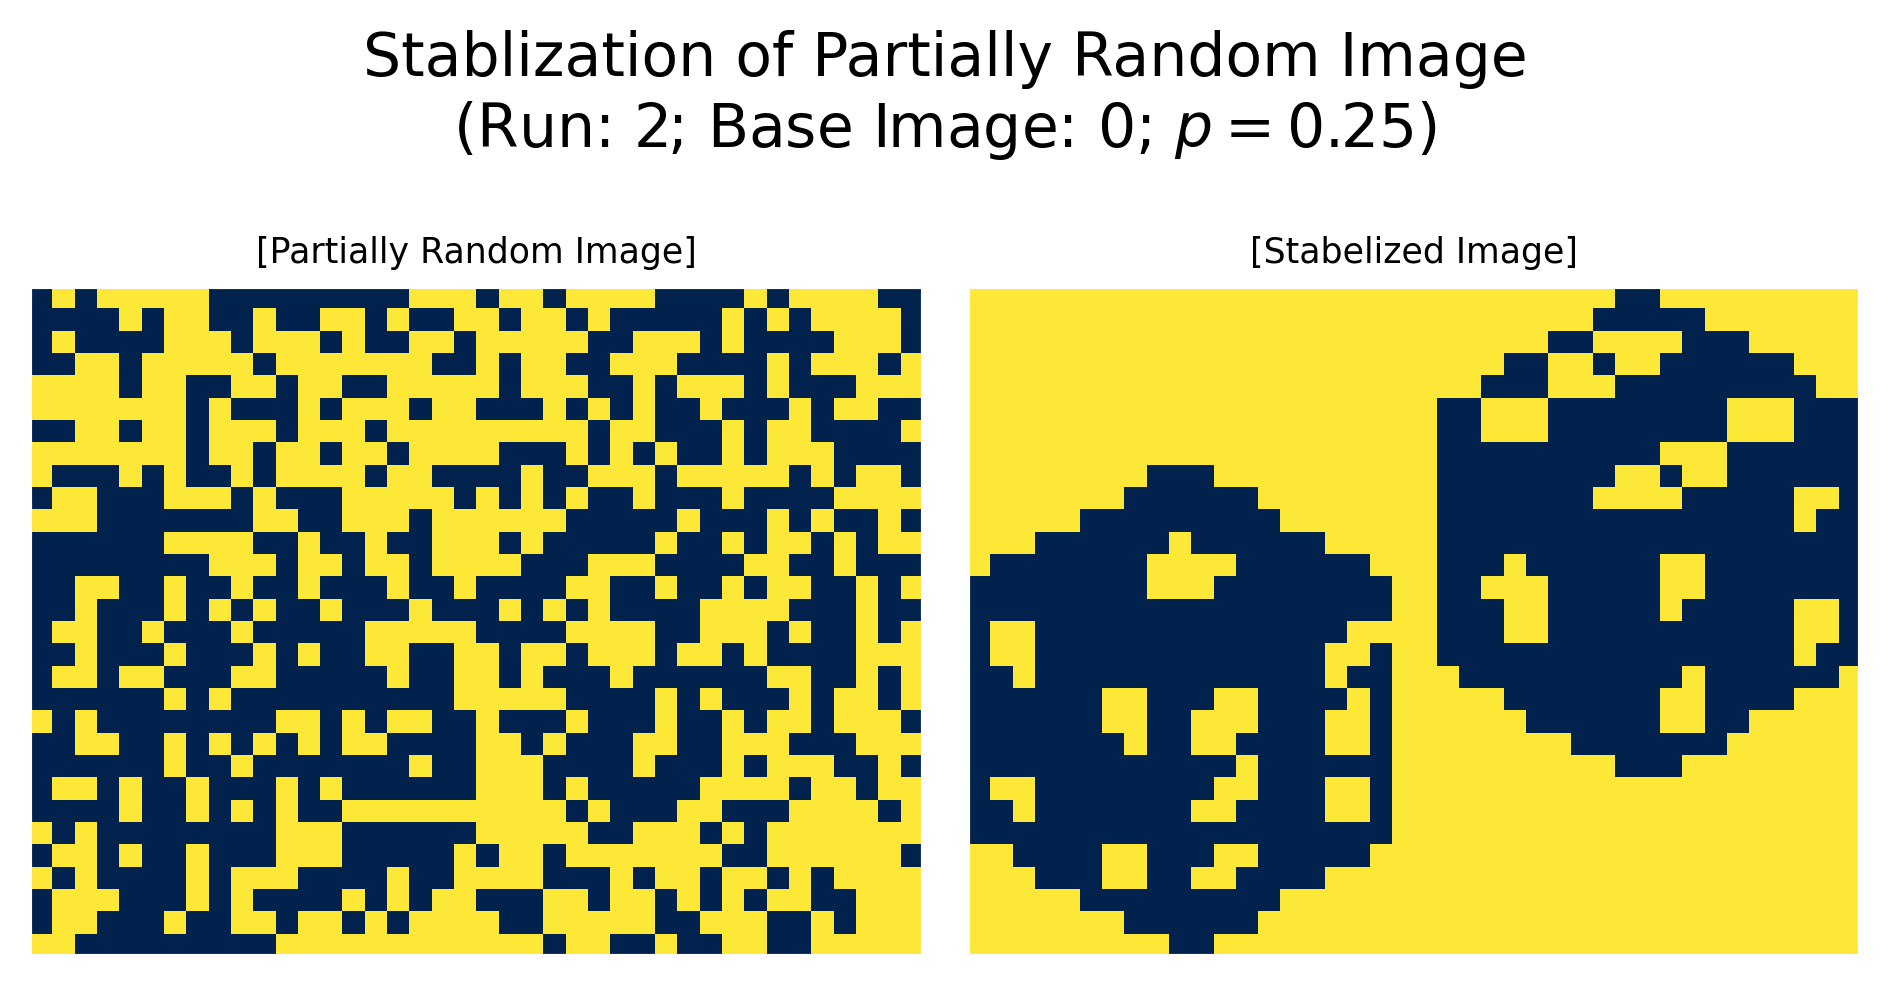

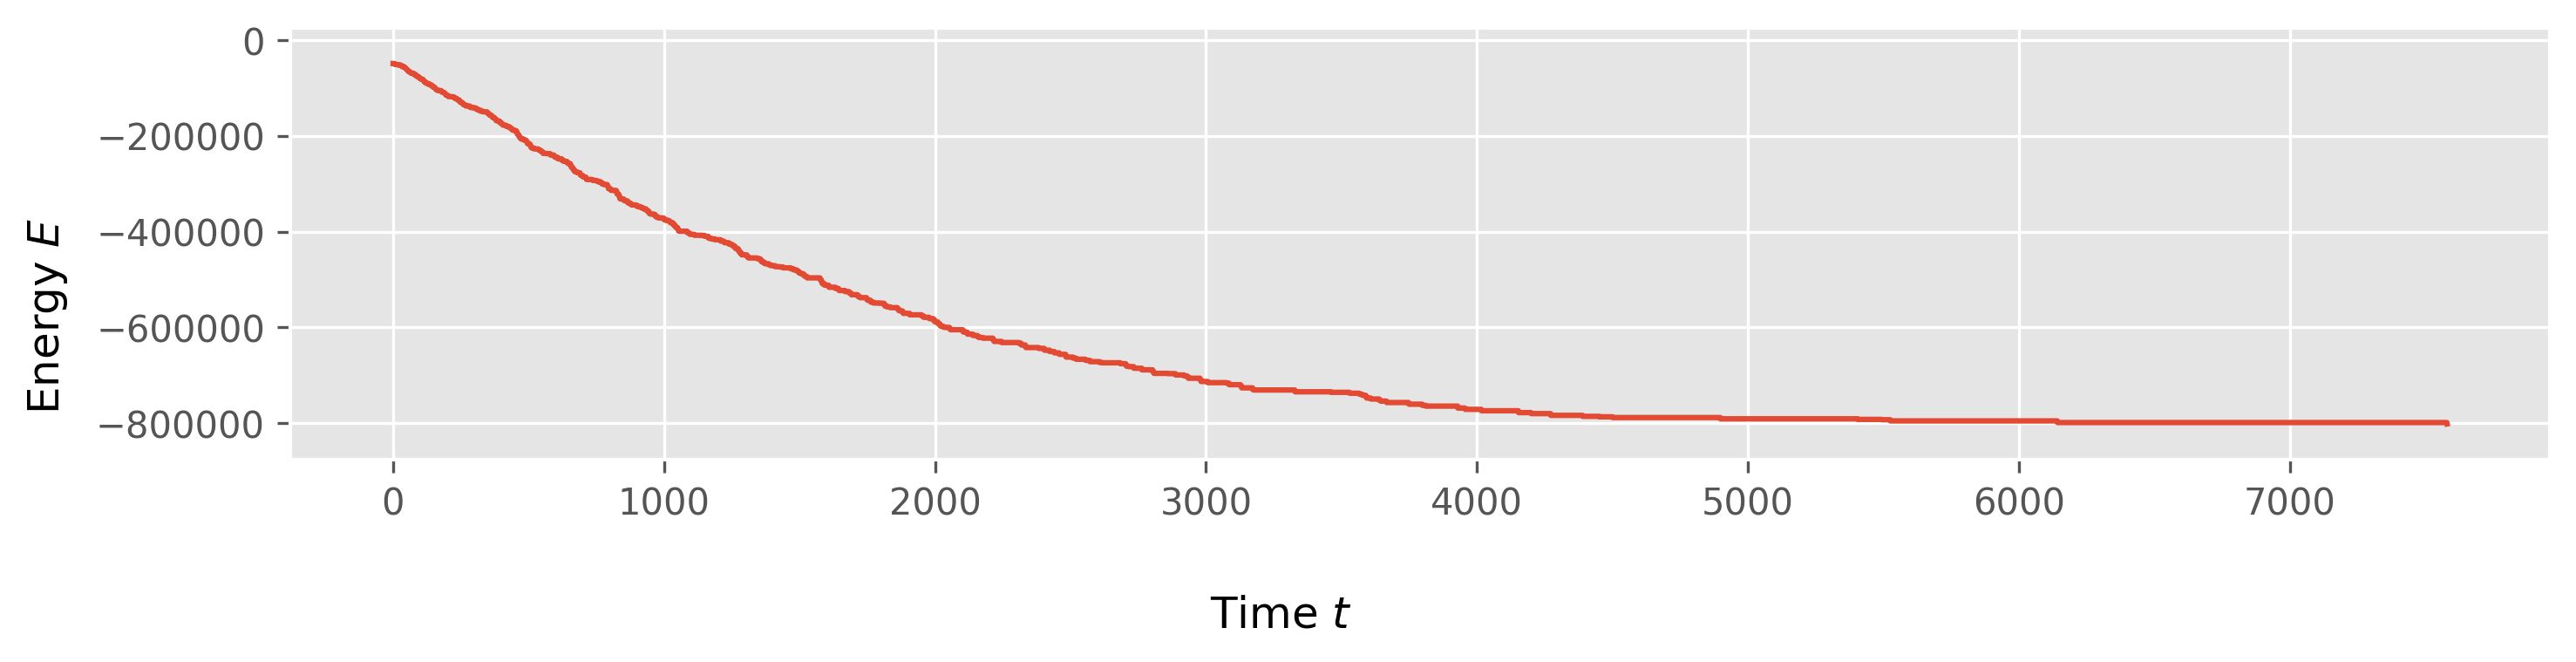

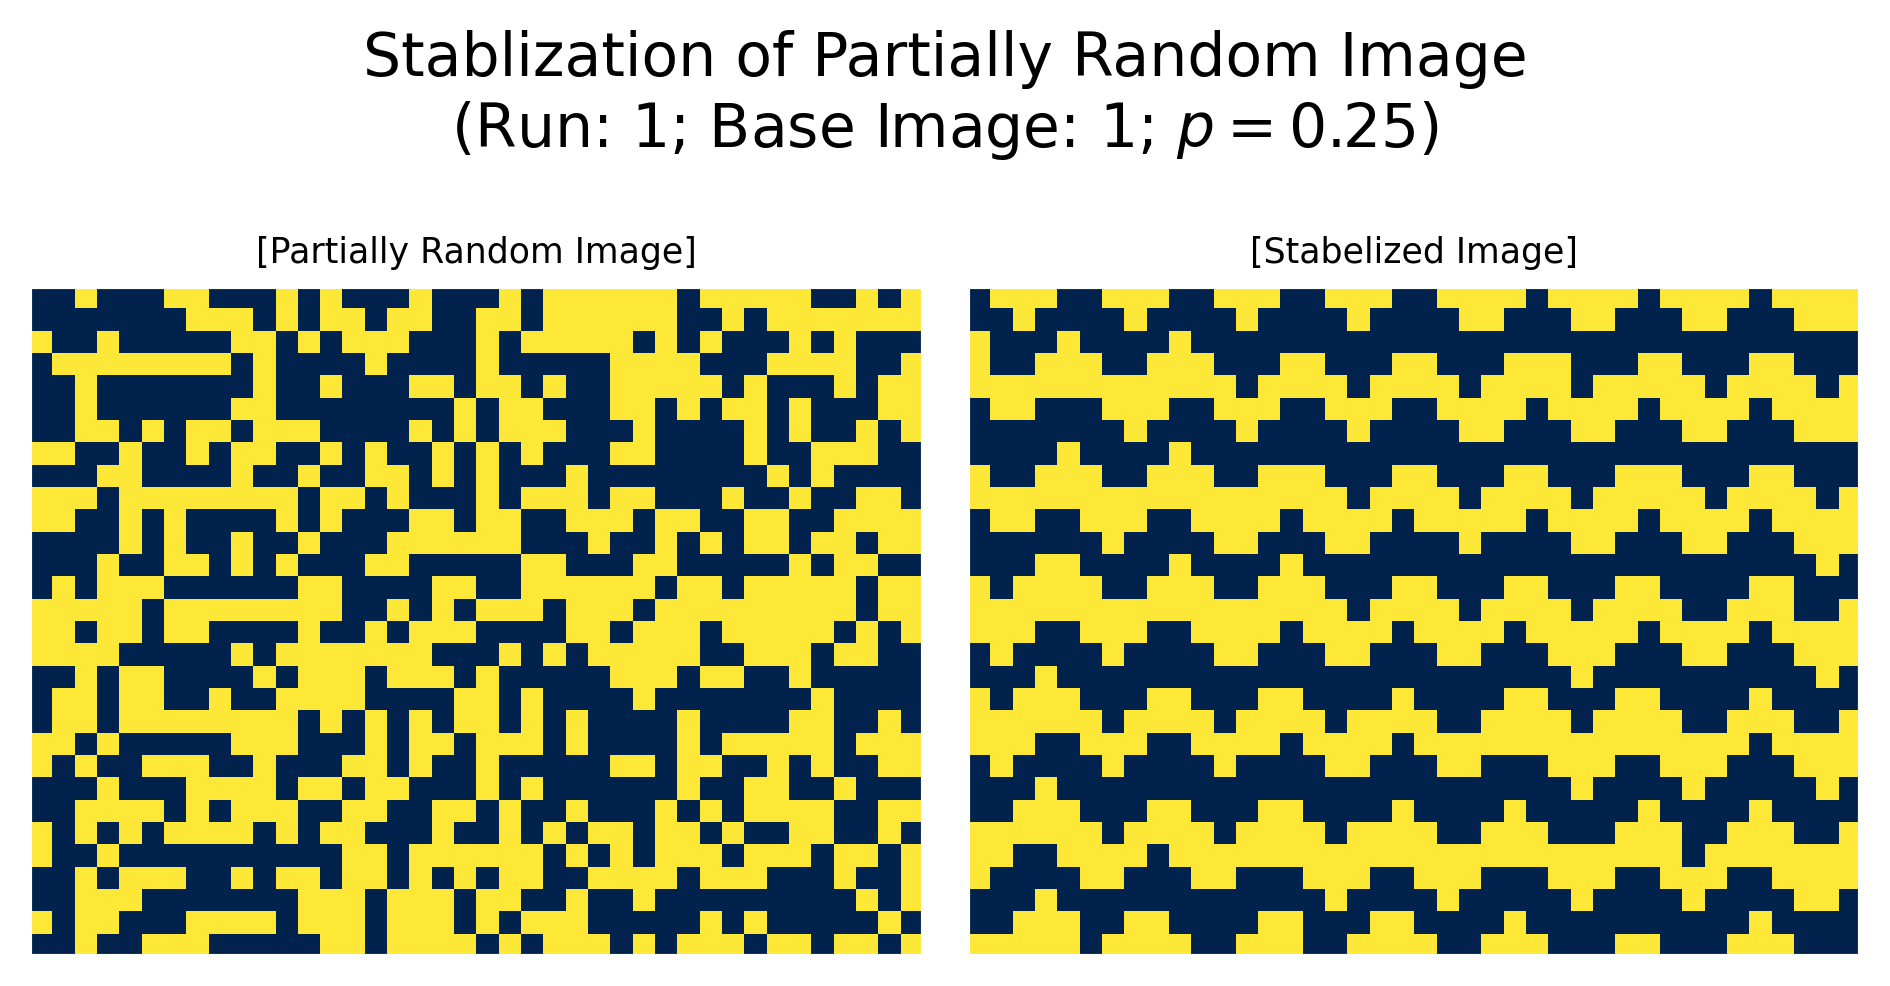

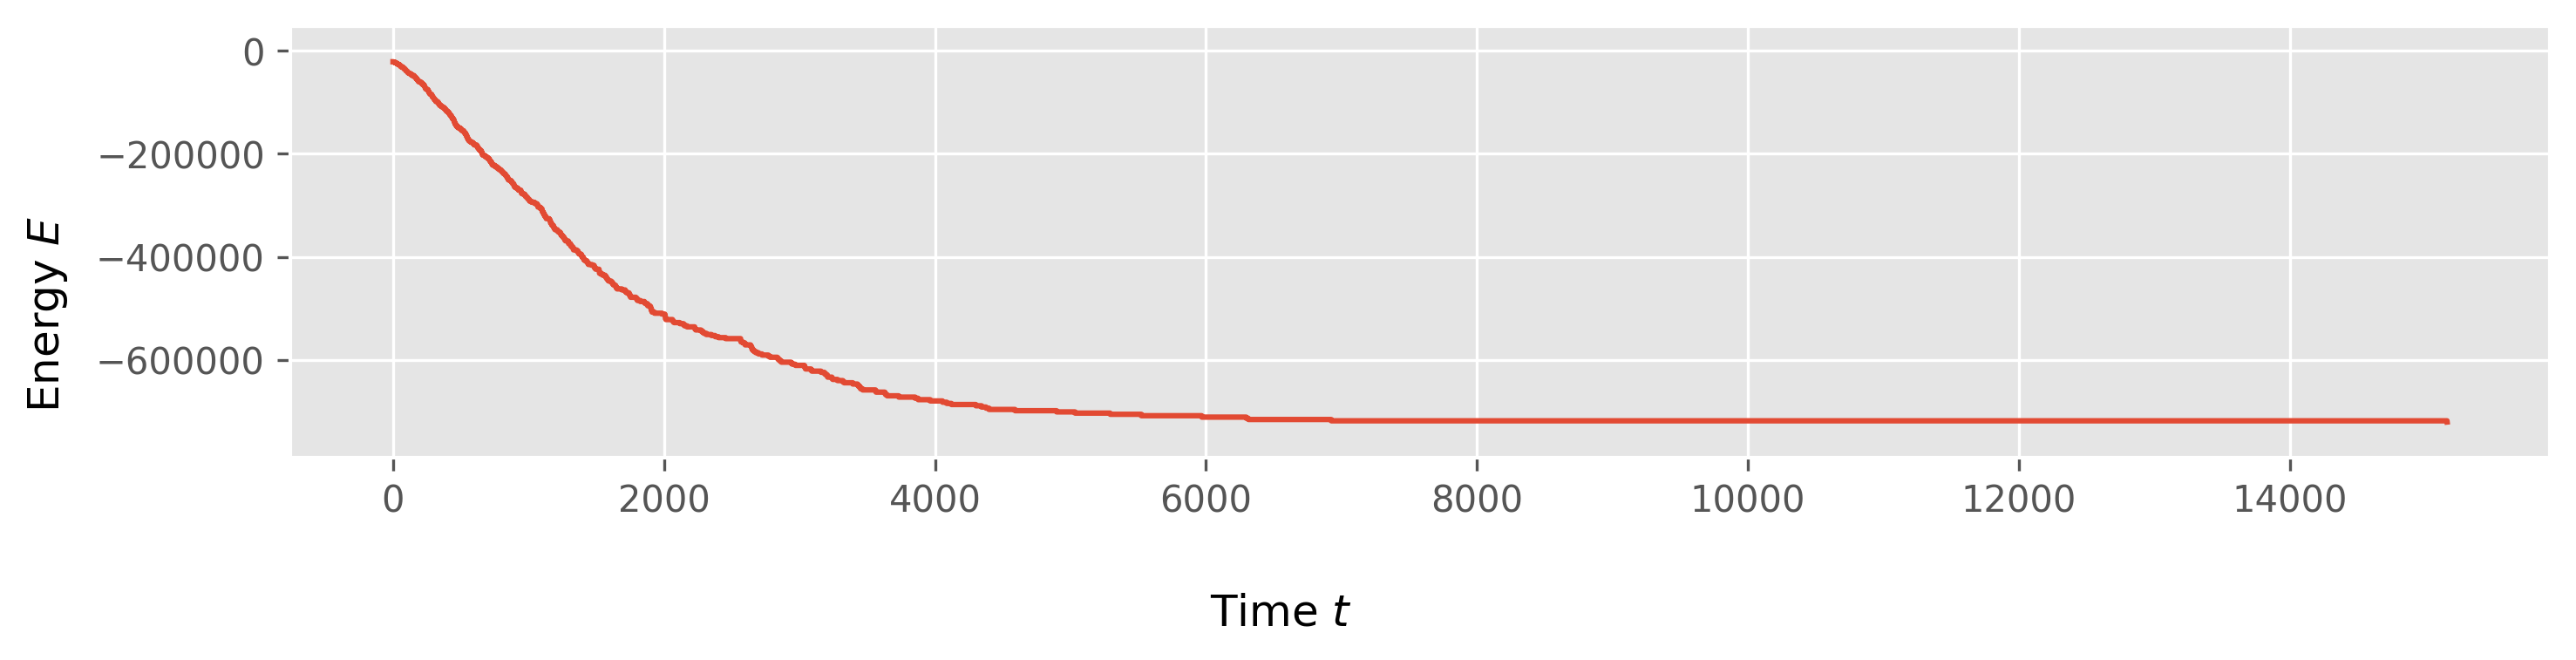

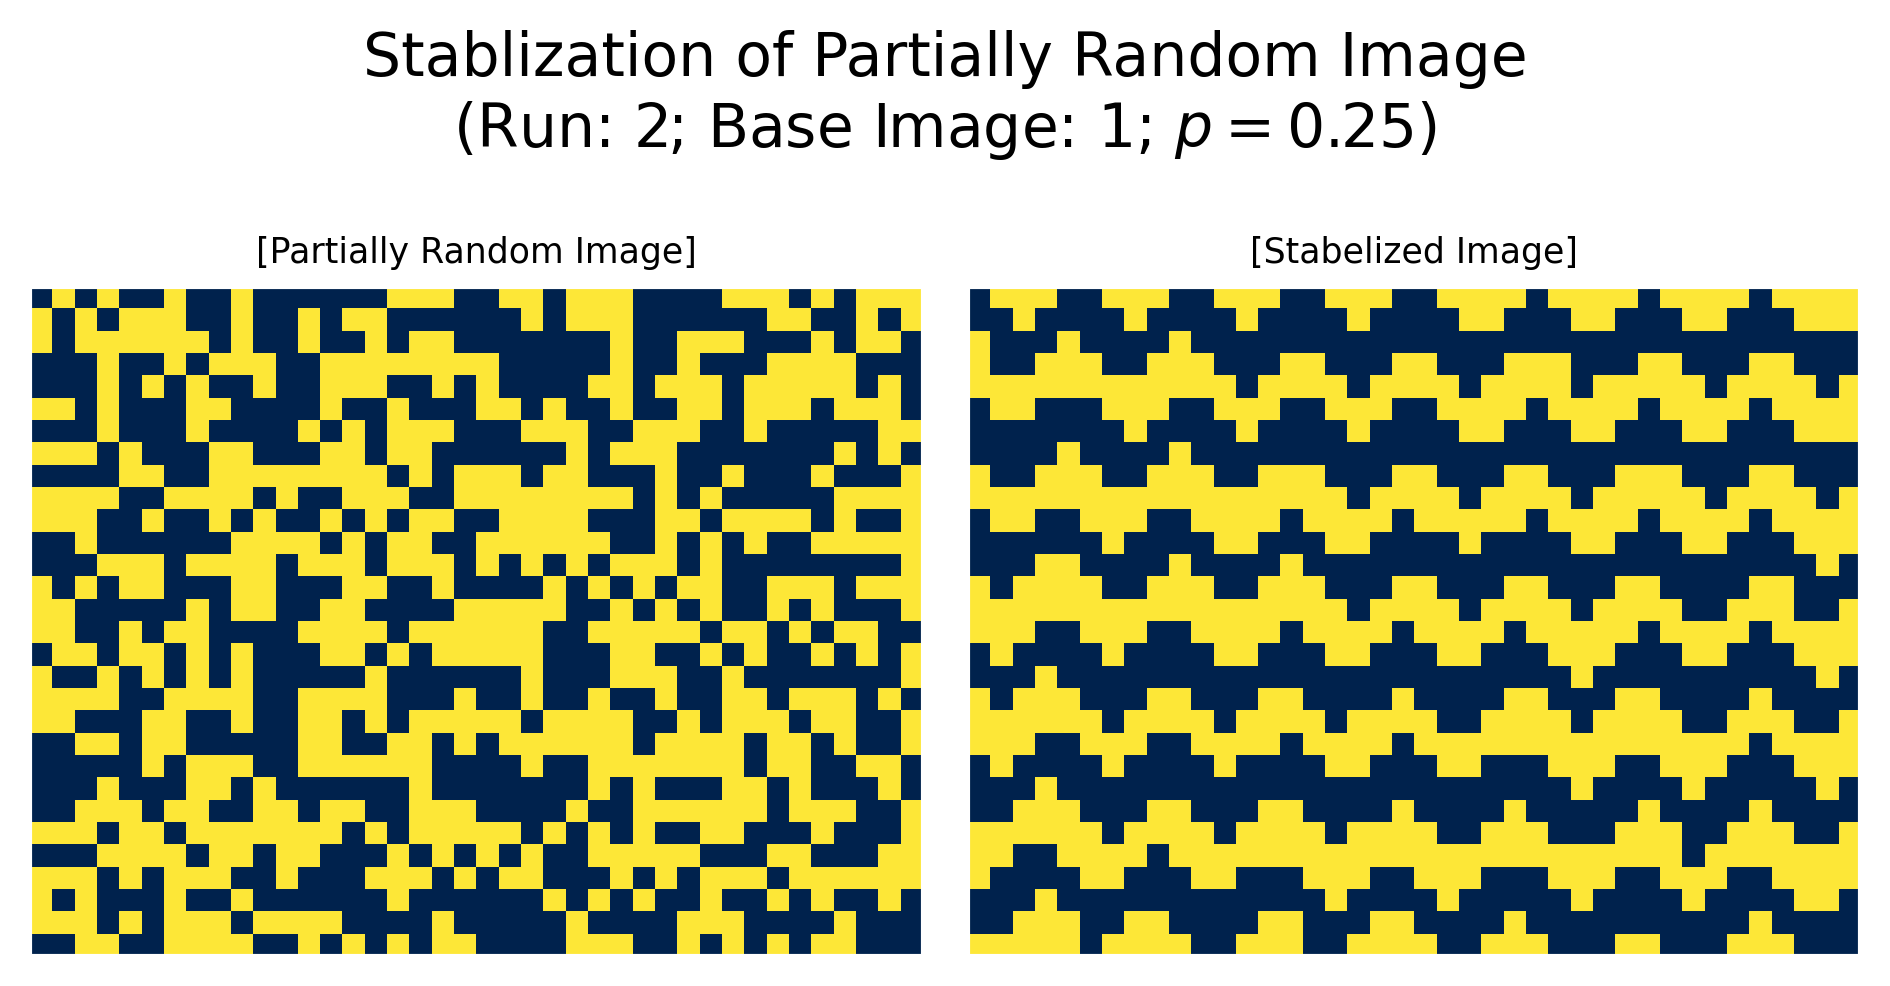

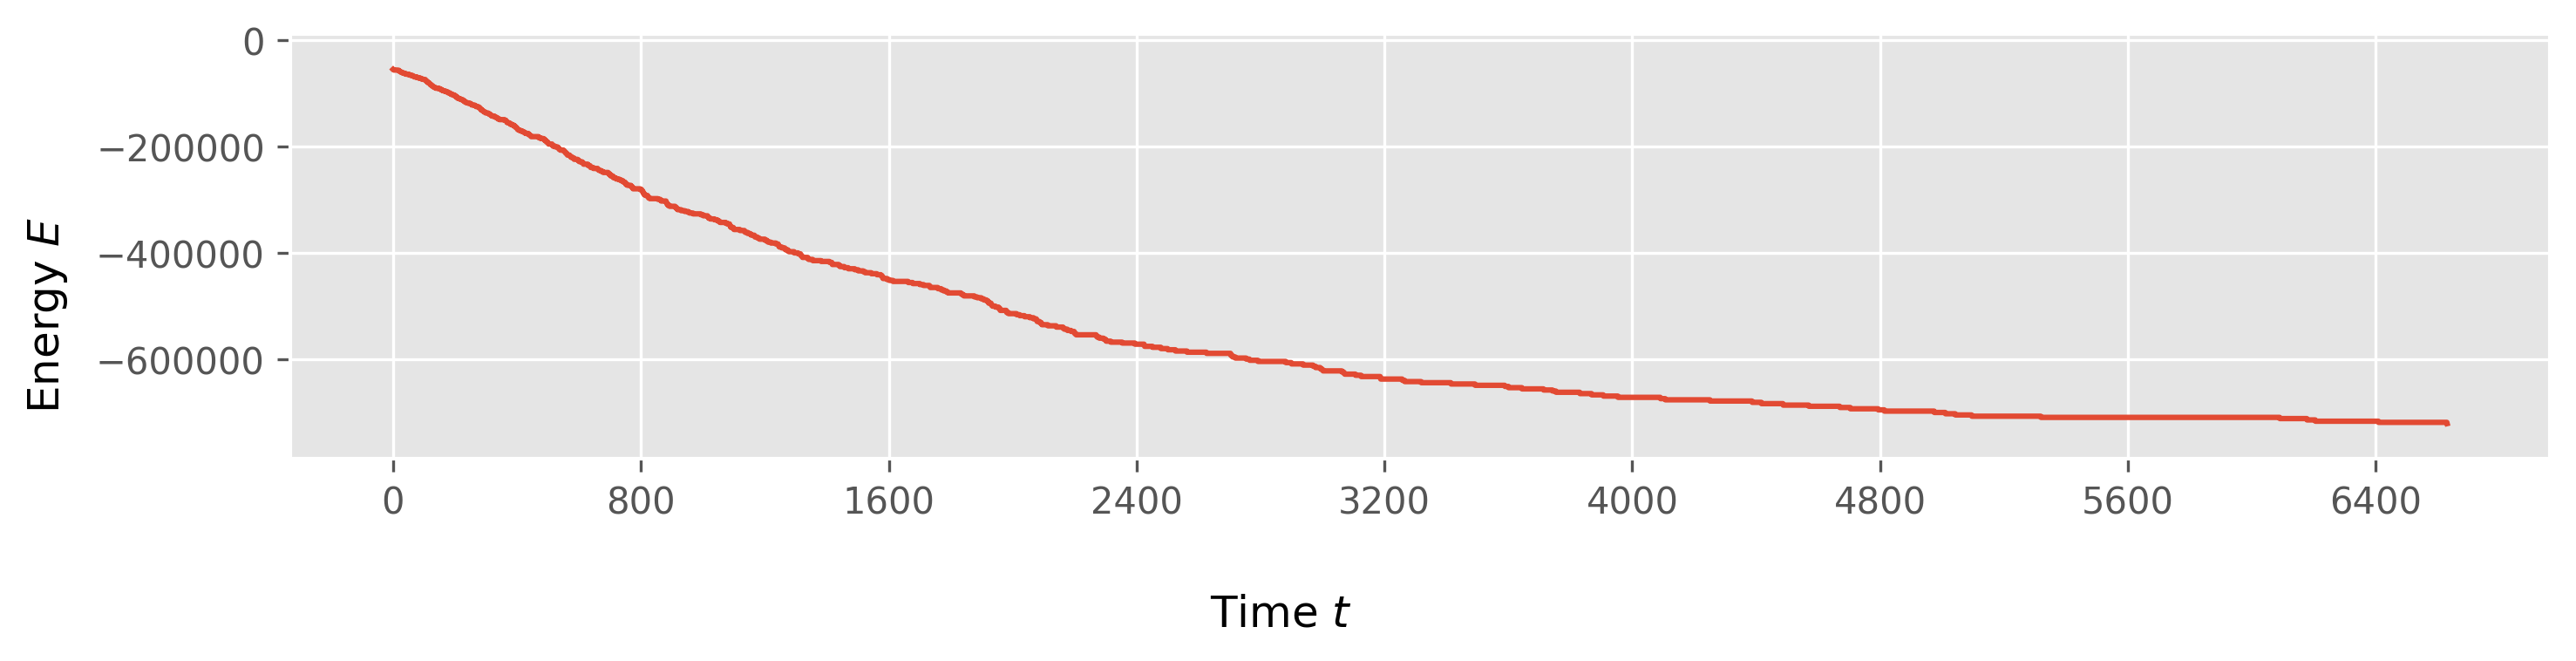

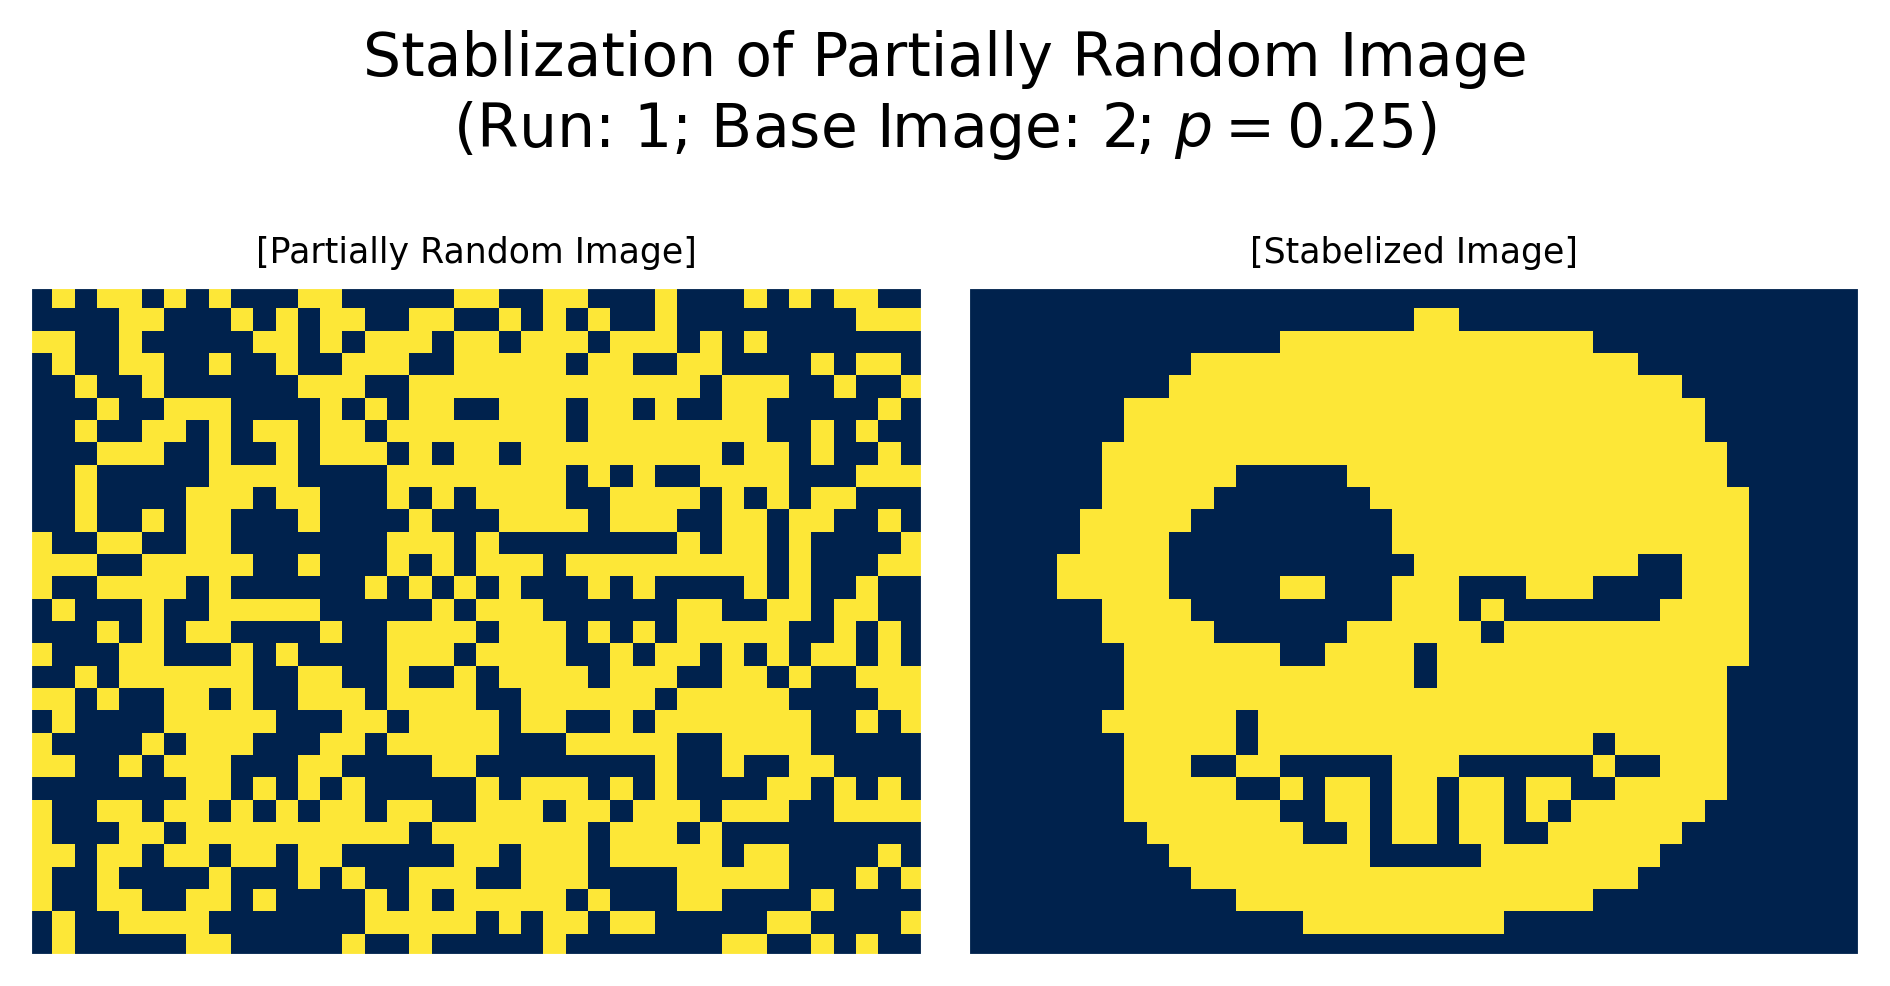

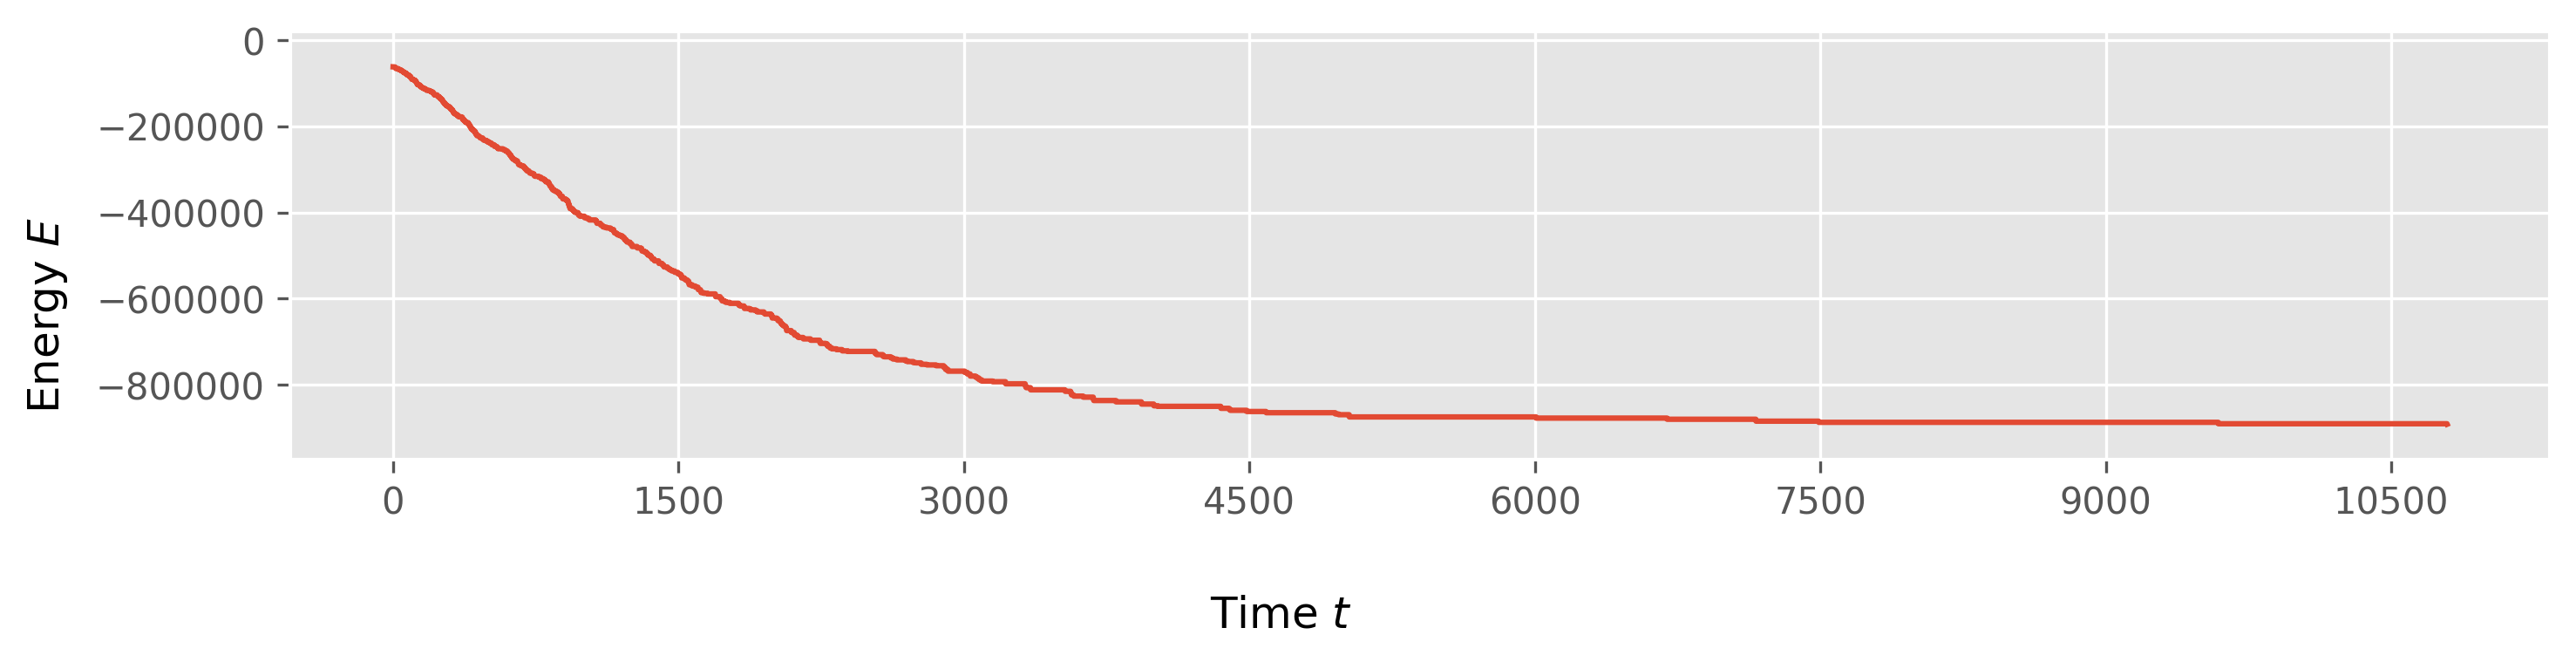

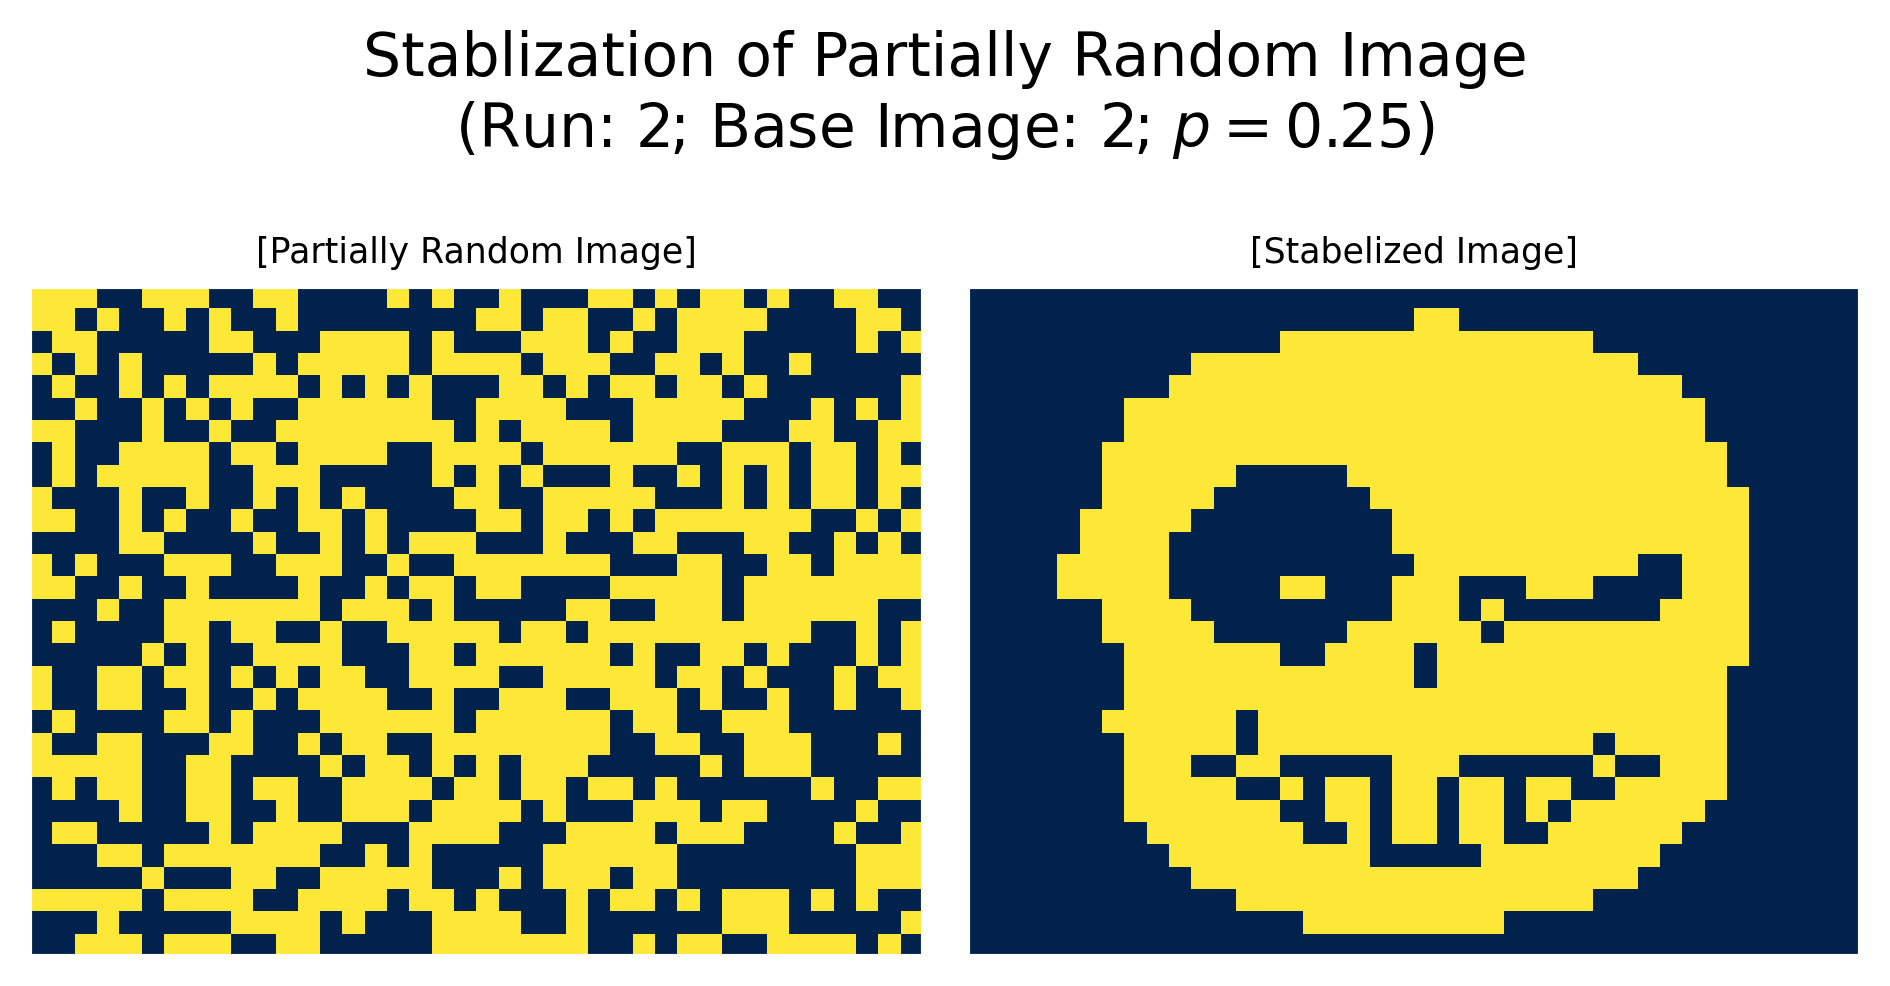

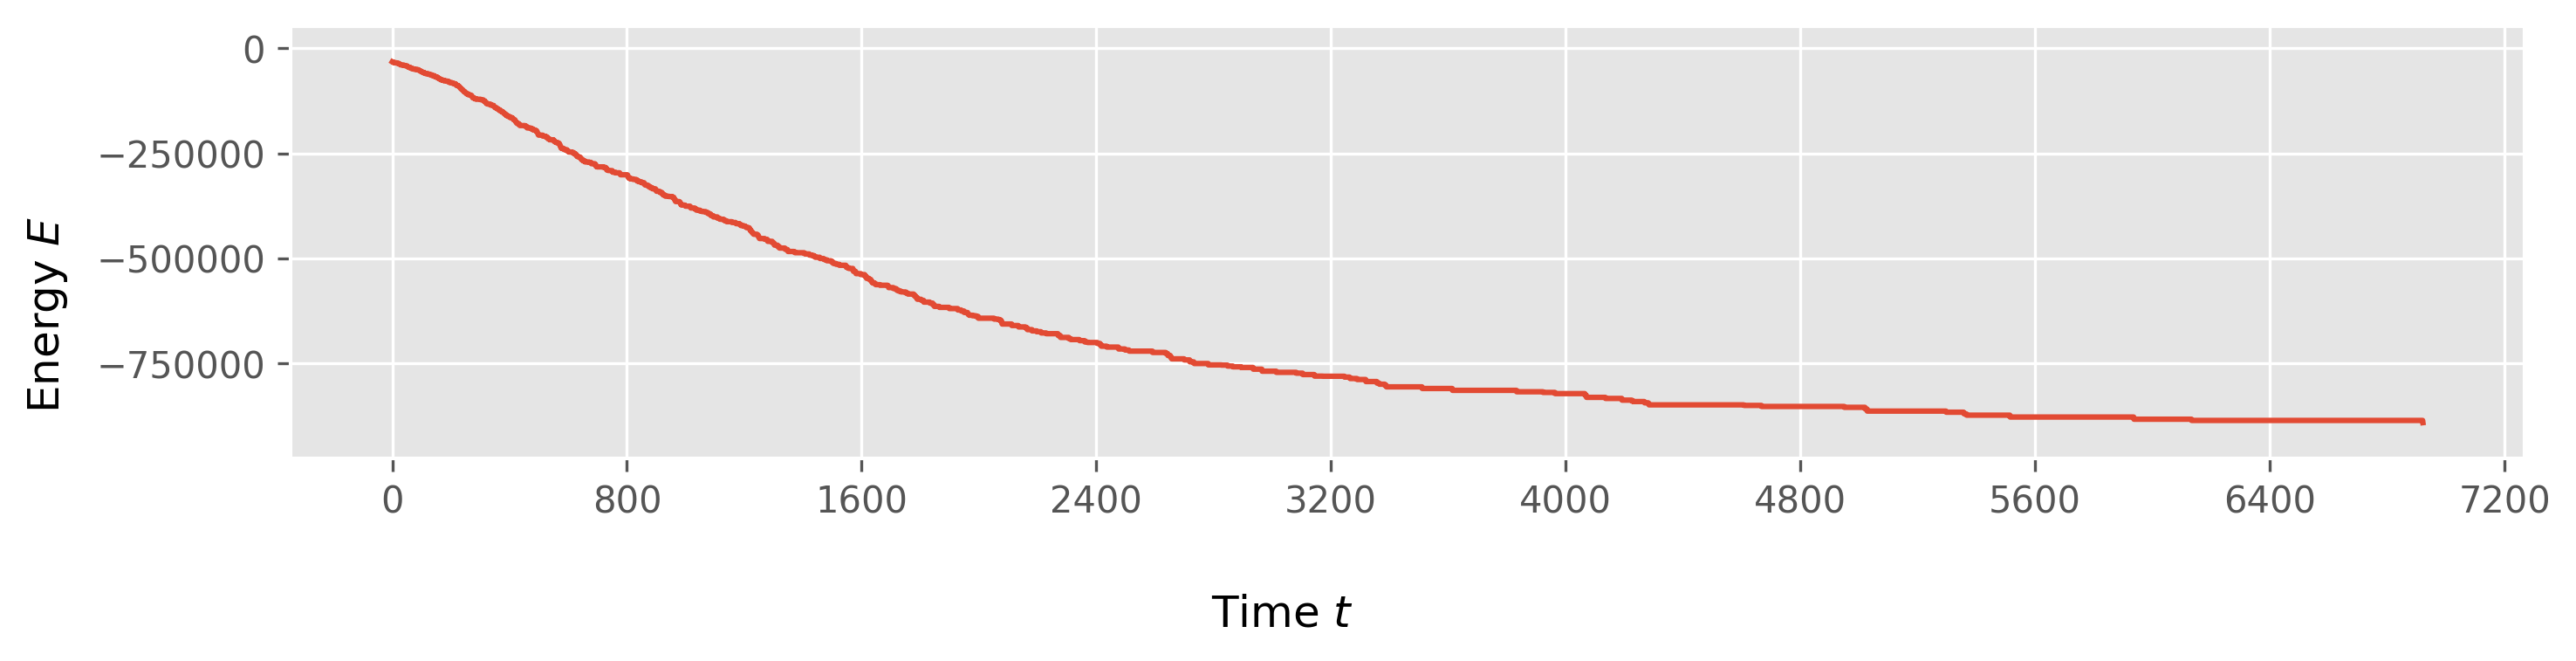

In [19]:
p: float = 0.25
for image_idx, source_pattern in enumerate(flattened_images[:3]):
    partially_random_patterns: NDArray[np.int8] = generate_partially_random_patterns(
        source_pattern, p=p
    )

    for idx, random_pattern in enumerate(partially_random_patterns, start=1):
        stabelized_state, energies = hopfield_network.stabilize(
            random_pattern, synchron=False
        )
        figure, axes = multi_plot_states(
            np.stack(
                [
                    random_pattern.reshape(image_shape),
                    stabelized_state.reshape(image_shape),
                ]
            ),
            orientation="horizontal",
            show_axis=False,
            show_legend=False,
        )

        axes[0, 0].set_title("[Partially Random Image]", fontsize="small")
        axes[0, 1].set_title("[Stabelized Image]", fontsize="small")

        figure.suptitle(
            f"Stablization of Partially Random Image\n(Run: {idx}; Base Image: {image_idx}; $p={p}$)",
            fontsize="x-large",
            y=0.85,
        )
        figure.tight_layout()

        figure, _ = multi_plot_energy_evolution(
            [energies], style="line", figsize=(10, 2.5)
        )
        figure.tight_layout()

**Interpretation of Results**

TODO